# Multi-morbidity networks in the oldest old (90yo+) via Bayesian network reconstruction

This notebook applies the Bayesian inference techniques from [`MLTC_inference.ipynb`](MLTC_inference.ipynb) to PCCIU dataset divided into age and sex, while using results from [`MLTC_atomic.ipynb`](MLTC_atomic.ipynb) as a reference. It is recommended to view those notebooks first.

**Author**: Guillermo Romero Moreno <Guillermo.RomeroMoreno@ed.ac.uk> <br/>
**Date**: November 2022 <br/>
**License**: CC-BY-4.0<br/>

In [1]:
%load_ext autoreload
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

import os, sys
thisdir = os.path.abspath('')
libdir = os.path.join(thisdir, '../')  # Make sure to make it point to the root directory of the repository

if libdir not in sys.path:
    sys.path.insert(0, libdir)
    
import nest_asyncio
nest_asyncio.apply()

# core python modules
import time
import re
import itertools as it
import warnings

# external
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# internal
from lib.utils import MLTC_count, identify_LTC, compute_associations, compute_RR
from lib.data import load_dataset, stratify_dataset, beautify_index, beautify_name
from lib.results import compute_communities, get_top_associations, plot_ABC_vs_RR, plot_tops
from lib.model import ABCModel, probability_of_larger

print('python', sys.version)
print('numpy', np.__version__)
print('scipy', sp.__version__)
print('pandas', pd.__version__)
print('networkx', nx.__version__)
print('matplotlib', plt.__version__)
print('seaborn', sns.__version__)

python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
pystan 3.2.0
numpy 1.22.3
scipy 1.8.0
networkx 2.8
pandas 1.4.2
seaborn 0.13.1


For [using bokeh with jupyterLab](https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html):

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.layouts import grid
output_notebook()

## Load the dataset

In [5]:
data, names = load_dataset()

Loading dataset PCCIU...
Dataset loaded (elapsed time: 27.01s)
Length of dataset: 1751841


In [ ]:
def stratify(data, stratification_variable):
    stratified_dataframes, stratified_labels, stratified_fnames = stratify_dataset(data, stratification_variable)

    n_strata = len(stratified_dataframes)
    stratified_X = np.array([np.array(MLTC_count(df_l, names), dtype=int) for df_l in stratified_dataframes])
    stratified_P = np.array([np.array([df_l[LTC].sum() for LTC in names]) for df_l in stratified_dataframes])
    stratified_M = np.array([len(df_l) for df_l in stratified_dataframes])
    
    return stratified_dataframes, stratified_labels, stratified_fnames, n_strata, stratified_Xs, stratified_P, stratified_M

# Results WITHOUT sex stratification

These experiments are taking the whole cohort --- i.e. both men and women together.

In [6]:
dfs, labels, fnames, L, Xs, Ps, Ms = stratify(df, "Age")  # This stratifies the data in bands of 10 years old
df_eld, fname_eld = dfs[9], fnames[9]  # The 90yo+ population is the index 9
X, P, M = Xs[9], Ps[9], Ms[9]

Length of dataset: 161271
Length of dataset: 209011
Length of dataset: 224746
Length of dataset: 249399
Length of dataset: 277998
Length of dataset: 231943
Length of dataset: 189906
Length of dataset: 129879
Length of dataset: 65679
Length of dataset: 12009


In [ ]:
LTC_prev_df = pd.DataFrame(index=names, columns=["Counts", "Prevalence"], data=np.array([P,P/M]).T).sort_values("Counts", ascending=False)
LTC_prev_df["Counts"] = LTC_prev_df["Counts"].astype(int)
LTC_prev_df["Prevalence"] = LTC_prev_df["Prevalence"].apply(lambda x: f'{100*x:.2g}%')
LTC_prev_df["name+"] = LTC_prev_df.index + " (" + LTC_prev_df["Counts"].astype(int).astype(str) + ")"
LTC_prev_df[["Counts", "Prevalence"]]

## Descriptive analysis of the 90+ age group

In [92]:
df_male = df_eld[df_eld["Sex"]=="Men"]
df_female = df_eld[df_eld["Sex"]=="Women"]
print(f"N of patients: Total {M}, males:{len(df_male)} ({100 * len(df_male)/M:.2f}%), females:{len(df_female)} ({100 * len(df_female)/M:.2f}%)")

N of patients: Total 12009, males:0 (0.00%), females:0 (0.00%)


ttest Ttest_indResult(statistic=nan, pvalue=nan)


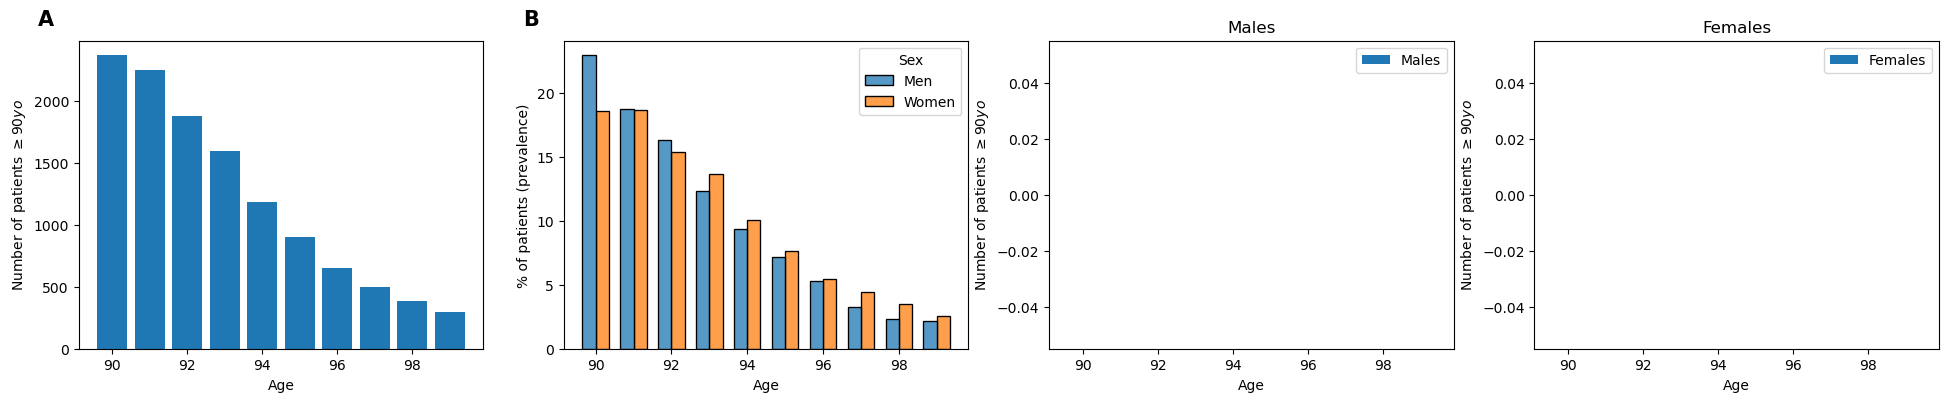

In [93]:
def describe_group(dfo, ax, label, legend=True):
    counts, _ = np.histogram(dfo["Age"], bins=np.linspace(89.5,99.5,11))
    ax.bar(range(len(counts)), counts, label=label);
    ax.set(xlabel="Age", ylabel=f"Number of patients $\geq90yo$", title=label)
    ax.legend() if legend else None
    ax.xaxis.set(ticks=range(10)[::2], ticklabels=[str(el) for el in range(90,100)][::2])
    return counts

fig, axes = plt.subplots(1, 4, figsize=(24, 4))
describe_group(df_eld, axes[0], "", legend=False)  # , axes[3]
axes[0].annotate("A", xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)

sns.histplot(df_eld, x="Age", hue="Sex", stat="percent", discrete=True, common_norm=False, multiple="dodge", shrink=0.7, ax=axes[1]);
axes[1].set(xlabel="Age", ylabel="% of patients (prevalence)");
axes[1].annotate("B", xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)

males = describe_group(df_male, axes[2], "Males")  # , axes[1])
females = describe_group(df_female, axes[3], "Females")  # , axes[1])
print("ttest", sp.stats.ttest_ind(males, females))

       | >=3 morb:  7814 (65.07%), >=2 morb: 81.46%, mean morb: 3.65+-0.02
Males  | >=3 morb:     0 (nan%), >=2 morb: nan%, mean morb: nan+-nan
Females| >=3 morb:     0 (nan%), >=2 morb: nan%, mean morb: nan+-nan
ttest Ttest_indResult(statistic=nan, pvalue=nan)


/tmp/ipykernel_3078824/992501821.py:14: RuntimeWarning: invalid value encountered in long_scalars
  print(f"{label:7}| >=3 morb: {counts[3:].sum():5} ({100*counts[3:].sum()/len(dfo):.2f}%), >=2 morb: {100*counts[2:].sum()/len(dfo):.2f}%, mean morb: {(mean:= sum(i * count for i, count in enumerate(counts))/len(dfo)):.2f}+-{np.sqrt(sum((i - mean)**2 * count for i, count in enumerate(counts)))/len(dfo):.2f}")


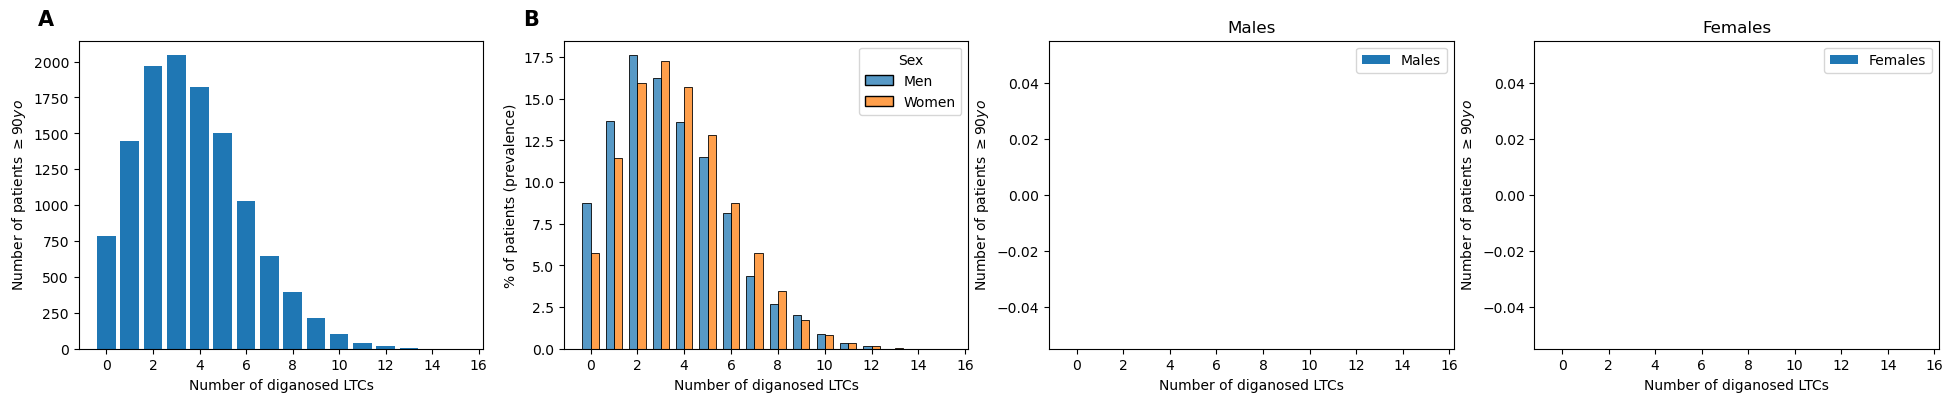

In [94]:
morb_cols = df_eld.columns[11:51]
def describe_group(dfo, ax, label, legend=True):
    individuals = dfo[morb_cols].values.sum(axis=1)
    counts, _ = np.histogram(individuals, bins=range(17))
    ax.bar(range(len(counts)), counts, label=label);
    ax.set(xlabel="Number of diganosed LTCs", ylabel=f"Number of patients $\geq90yo$", title=label)
    ax.legend() if legend else None

    print(f"{label:7}| >=3 morb: {counts[3:].sum():5} ({100*counts[3:].sum()/len(dfo):.2f}%), >=2 morb: {100*counts[2:].sum()/len(dfo):.2f}%, mean morb: {(mean:= sum(i * count for i, count in enumerate(counts))/len(dfo)):.2f}+-{np.sqrt(sum((i - mean)**2 * count for i, count in enumerate(counts)))/len(dfo):.2f}")
    return individuals

fig, axes = plt.subplots(1, 4, figsize=(24, 4))
describe_group(df_eld, axes[0], "", legend=False)  # , axes[3]
axes[0].annotate("A", xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)

sns.histplot(df_eld, x="n_morb", hue="Sex", stat="percent", discrete=True, common_norm=False, multiple="dodge", shrink=0.7, ax=axes[1]);
axes[1].set(xlabel="Number of diganosed LTCs", ylabel="% of patients (prevalence)");
axes[1].annotate("B", xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)

males = describe_group(df_male, axes[2], "Males")  # , axes[1])
females = describe_group(df_female, axes[3], "Females")  # , axes[1])
print("ttest", sp.stats.ttest_ind(males, females))

## Results with 99% CI

In [16]:
# Select model
model = ABCModel(model_name="MLTC_atomic_hyp_mult")

# Load fit (or fit new model if not saved model found)
num_warmup = 500
model.load_fit(df_eld, fname_eld + "0mu" + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)

# Compute RR and significance of RR and ABC
triu = np.triu_indices(n=len(model.morb_names), k=1)
pval = 0.01
bonferroni = False
corrected_pval = pval if not bonferroni else pval / len(triu[0])
print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")

dat_eld = model.get_results_dataframe(pval, corrected_pval)
dat_eld["i_abs"] = dat_eld["namei"].apply(lambda x: identify_LTC(x, names)[0])
dat_eld["j_abs"] = dat_eld["namej"].apply(lambda x: identify_LTC(x, names)[0])

print("Significant RR (Fisher):", model.fishers_sig[triu].sum(), ". Significant ABC:", model.r_sig[triu].sum())
print(f"Significant associatons:   Fisher (RR): {dat_eld['fisher_sig'].sum():.0f} ({100*dat_eld['fisher_sig'].sum()/len(triu[0]):.1f}%), "
      f"ABC: {dat_eld['a_sig'].sum():3.0f} ({100*dat_eld['a_sig'].sum()/len(triu[0]):.1f}%)")

Corrected p-value: 0.01, min # of samples for assessing: 100.0, required percentile: 0.5
Removing conditions without cases. Using 39 only.


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:782: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:784: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


Significant RR 410 Significant RR (Fisher) 192 Significant ABC 167


### Top associations

Plot them.

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(2,12*2))
for ax, panel in zip(axes, "AB"):
    fig2_kwargs = dict(NS_pos = 6 if panel_label == "A" else 1,
                       y_dict = {"RR": {"COPD - Alcohol problems": -2,
                                         "Glaucoma - Blindness & low vision": -8,},
                                  "ABC": {"COPD - Alcohol problems": 8,
                                         "Irritable bowel syndrome - Diverticular disease": 10,
                                         "Depression - Anxiety related disorders": 3,
                                         "Atrial fibrillation (AF) - Heart failure": -2,
                                         "Glaucoma - Blindness & low vision": -1}} if panel == "A" else {
                            "RR": {"Coronary heart disease - Dementia": 11,
                                        "Hypertension - Dementia": 3,
                                         "Treated dyspepsia - Atrial fibrillation (AF)": -2,
                                        "Chronic kidney disease - Dementia":-7,
                                        "Heart failure - Dementia": -4,},
                                  "ABC": {"Heart failure - Dementia": 6,
                                         "Chronic kidney disease - Dementia":-7}}
                       negative = True if panel == "B" else False,
                       
    
    # plot_fig2(ax, panel)
    
    sub_fig, ax = plt.subplots(figsize=(2,12))
    plot_tops(dat_eld, ax, panel, NS_pos=NS_pos, y_dict=y_dict, negative=panel=="B",)
    sub_fig.tight_layout()
    sub_fig.savefig(f"figs/fig2{panel}.eps")

# fig.tight_layout()
# fig.savefig("figs/fig2.eps")

Produce tables.

In [ ]:
tops = get_top_associations(dat_eld)

Top associations by ABC:

In [122]:
tops[0]

a_f_sig_CI  \
Asthma (currently treated) - Chronic obstructiv...  3.54 (2.87 - 4.43)   
Irritable bowel syndrome (IBS) - Diverticular d...  2.64 (1.94 - 3.25)   
Depression - Schizophrenia (and related non-org...  2.63 (1.89 - 3.84)   
Depression - Anxiety & other neurotic, stress r...  2.52 (2.25 - 2.76)   
Atrial fibrillation (AF) - Heart failure             2.48 (2.15 - 2.7)   
Chronic obstructive pulmonary disease (COPD) - ...  2.38 (1.24 - 4.24)   
Chronic obstructive pulmonary disease (COPD) - ...   2.25 (1.28 - 3.4)   
Coronary heart disease (CHD) - Heart failure        2.25 (2.05 - 2.45)   
Glaucoma - Blindness & low vision                    2.2 (1.82 - 2.71)   
Chronic kidney disease (CKD) - Heart failure         2.0 (1.77 - 2.26)   

                                                           RR_f_sig_CI  
Asthma (currently treated) - Chronic obstructiv...  3.86 (3.78 - 3.93)  
Irritable bowel syndrome (IBS) - Diverticular d...  2.69 (2.62 - 2.76)  
Depression - Schizophrenia (and related non-org...  3.31 (3.15 - 3.48)  
Depression - Anxiety & other neurotic, stress r...  2.39 (2.38 - 2.39)  
Atrial fibrillation (AF) - Heart failure             2.31 (2.3 - 2.32)  
Chronic obstructive pulmonary disease (COPD) - ...   4.9 (4.22 - 5.71)  
Chronic obstructive pulmonary disease (COPD) - ...  3.22 (2.91 - 3.57)  
Coronary heart disease (CHD) - Heart failure        2.13 (2.12 - 2.14)  
Glaucoma - Blindness & low vision                    2.3 (2.26 - 2.33)  
Chronic kidney disease (CKD) - Heart failure         1.91 (1.9 - 1.92)

Top associations by RR:

In [123]:
tops[2]

RR_f_sig_CI  \
Irritable bowel syndrome (IBS) - Migraine           11.0 (4.65 - 26.0)   
Schizophrenia (and related non-organic psychosi...  9.01 (3.81 - 21.3)   
Irritable bowel syndrome (IBS) - Chronic sinusitis   5.37 (3.5 - 8.25)   
Chronic obstructive pulmonary disease (COPD) - ...   4.9 (4.22 - 5.71)   
Prostate disorders - Psoriasis or eczema            4.26 (3.44 - 5.28)   
Asthma (currently treated) - Chronic obstructiv...  3.86 (3.78 - 3.93)   
Peripheral vascular disease - Anorexia or bulimia   3.69 (2.55 - 5.33)   
Chronic obstructive pulmonary disease (COPD) - ...  3.54 (2.86 - 4.39)   
Depression - Schizophrenia (and related non-org...  3.31 (3.15 - 3.48)   
Chronic obstructive pulmonary disease (COPD) - ...  3.22 (2.91 - 3.57)   

                                                            a_f_sig_CI  
Irritable bowel syndrome (IBS) - Migraine                           NS  
Schizophrenia (and related non-organic psychosi...                  NS  
Irritable bowel syndrome (IBS) - Chronic sinusitis                  NS  
Chronic obstructive pulmonary disease (COPD) - ...  2.38 (1.24 - 4.24)  
Prostate disorders - Psoriasis or eczema                            NS  
Asthma (currently treated) - Chronic obstructiv...  3.54 (2.87 - 4.43)  
Peripheral vascular disease - Anorexia or bulimia                   NS  
Chronic obstructive pulmonary disease (COPD) - ...                  NS  
Depression - Schizophrenia (and related non-org...  2.63 (1.89 - 3.84)  
Chronic obstructive pulmonary disease (COPD) - ...   2.25 (1.28 - 3.4)

In [124]:
f'Median significant association by RR: {dat_eld[dat_eld["fisher_sig"]]["RR"].median():.2f}"
f"[IQR {np.percentile(dat_eld[dat_eld["fisher_sig"]]["RR"], 25):.2f}, {np.percentile(dat_eld[dat_eld["fisher_sig"]]["RR"], 75):.2f}]'

'median (significant) RR: 1.34 [IQR 1.21, 1.60]'

Top negative associations by RR:

In [49]:
tops[3]

RR_f_sig_CI  \
Thyroid disorders - Prostate disorders              0.351 (0.305 - 0.405)   
Rheumatoid arthritis, other inflammatory polyar...   0.394 (0.273 - 0.57)   
Asthma (currently treated) - Dementia               0.505 (0.469 - 0.543)   
Treated dyspepsia - Stroke & transient ischaemi...  0.673 (0.663 - 0.683)   
Painful condition - Dementia                        0.695 (0.686 - 0.704)   
Coronary heart disease (CHD) - Treated dyspepsia    0.752 (0.745 - 0.758)   
Hypertension - Parkinson’s disease                  0.764 (0.729 - 0.801)   
Heart failure - Dementia                            0.802 (0.792 - 0.813)   
Chronic kidney disease (CKD) - Dementia              0.82 (0.811 - 0.829)   
Treated dyspepsia - Atrial fibrillation (AF)        0.825 (0.814 - 0.837)   
Hypertension - Dementia                             0.832 (0.829 - 0.835)   
Coronary heart disease (CHD) - Dementia               0.835 (0.83 - 0.84)   
Hypertension - Chronic obstructive pulmonary di...   0.904 (0.898 - 0.91)   
Hypertension - Depression                           0.939 (0.936 - 0.942)   

                                                               a_f_sig_CI  
Thyroid disorders - Prostate disorders              0.491 (0.313 - 0.771)  
Rheumatoid arthritis, other inflammatory polyar...                     NS  
Asthma (currently treated) - Dementia                0.58 (0.408 - 0.847)  
Treated dyspepsia - Stroke & transient ischaemi...  0.708 (0.575 - 0.834)  
Painful condition - Dementia                         0.694 (0.587 - 0.86)  
Coronary heart disease (CHD) - Treated dyspepsia    0.753 (0.668 - 0.896)  
Hypertension - Parkinson’s disease                                     NS  
Heart failure - Dementia                            0.853 (0.699 - 0.989)  
Chronic kidney disease (CKD) - Dementia              0.825 (0.72 - 0.998)  
Treated dyspepsia - Atrial fibrillation (AF)                           NS  
Hypertension - Dementia                              0.83 (0.754 - 0.912)  
Coronary heart disease (CHD) - Dementia             0.844 (0.752 - 0.966)  
Hypertension - Chronic obstructive pulmonary di...                     NS  
Hypertension - Depression                                              NS

### Heatmaps

6
max ABC: 5.00
max ABC: 5.00
max RR: 5.00
max RR: 5.00
max RR: 5.00
max RR: 5.00


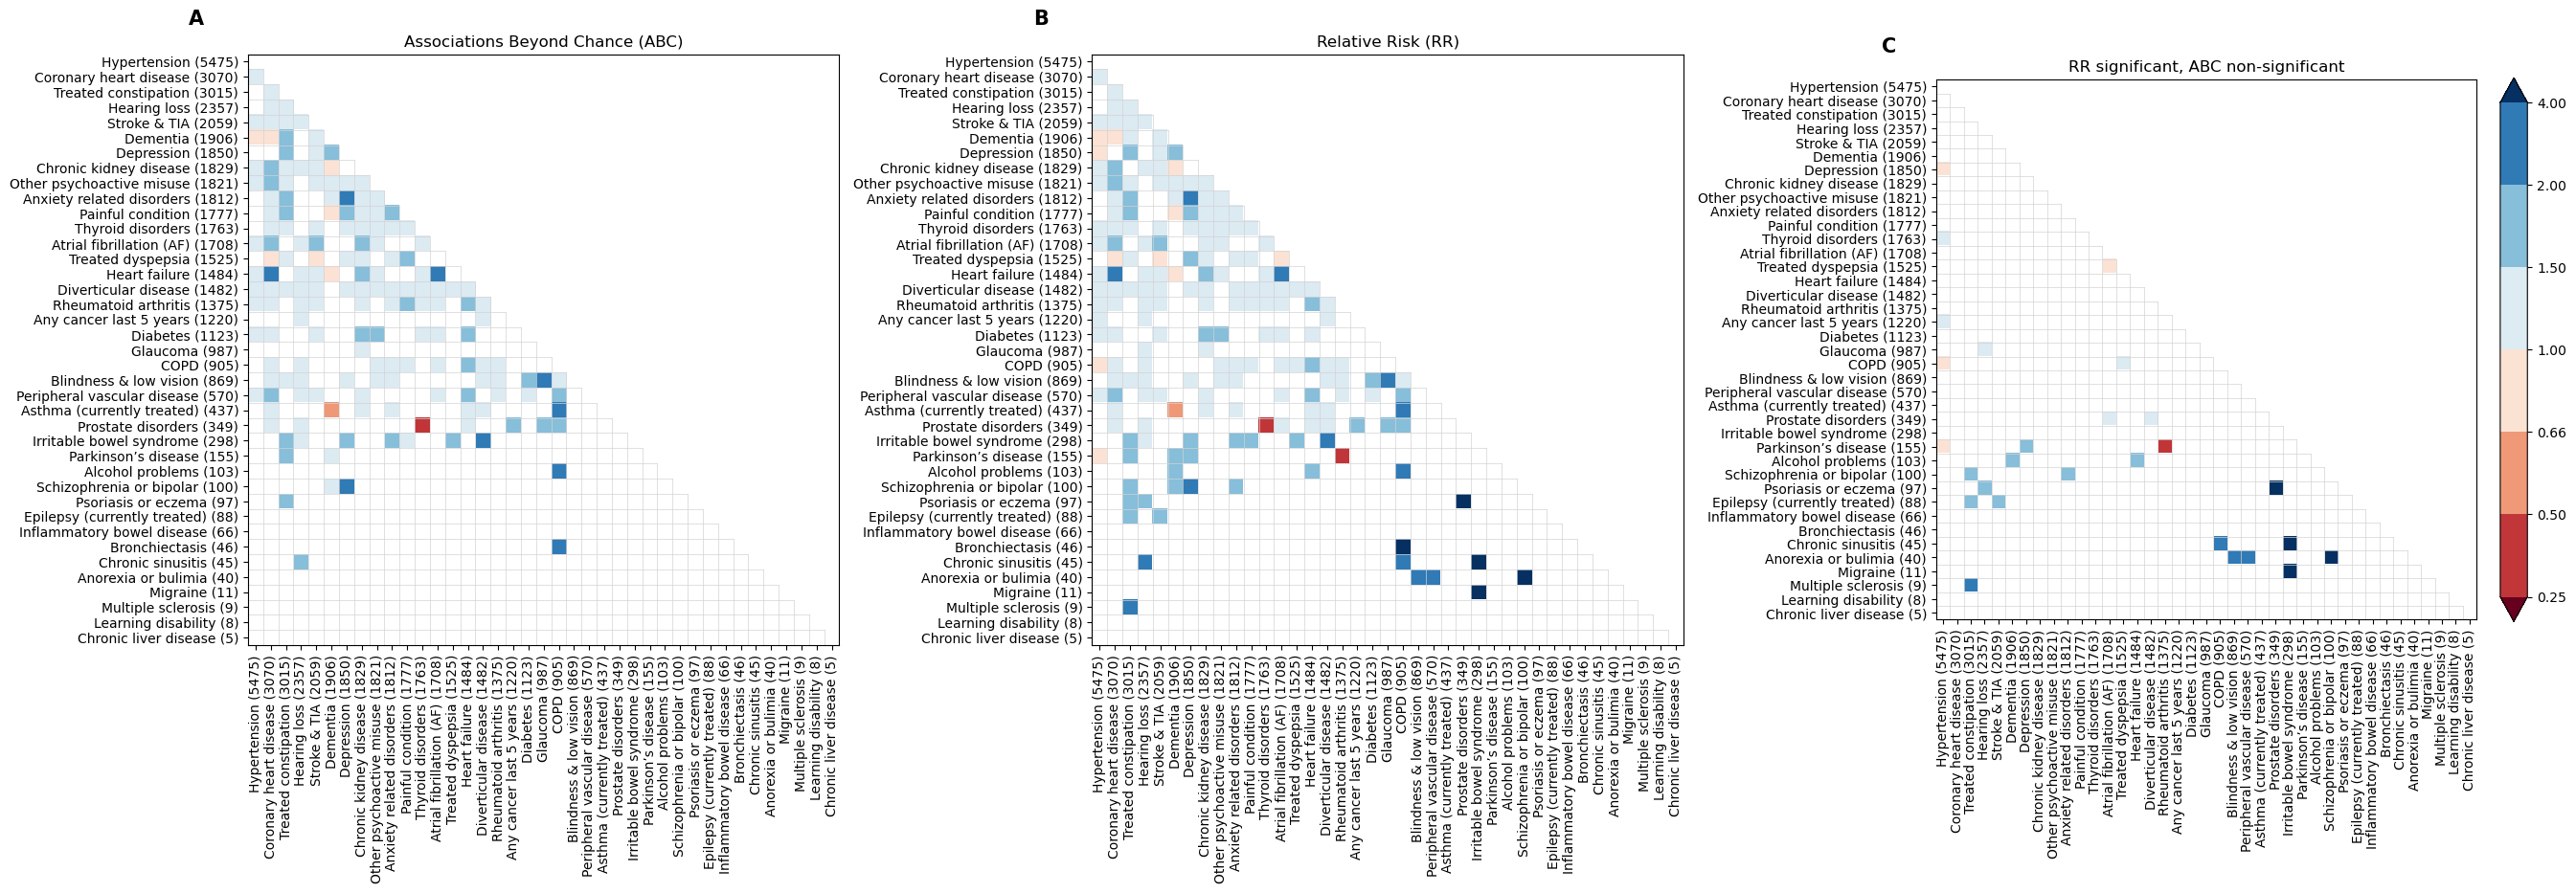

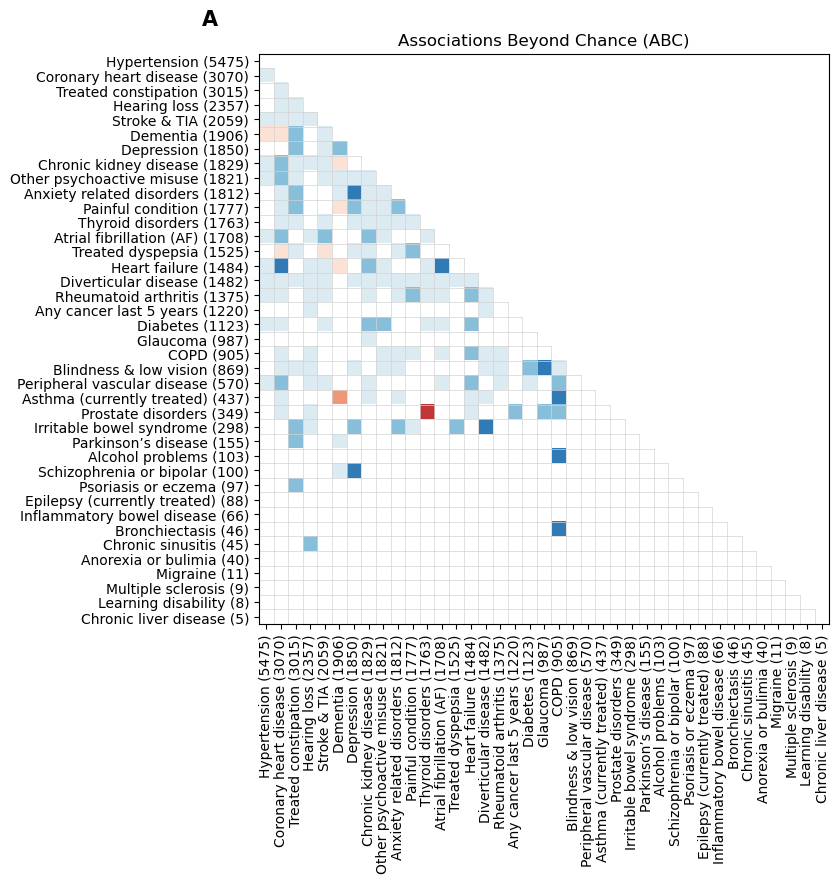

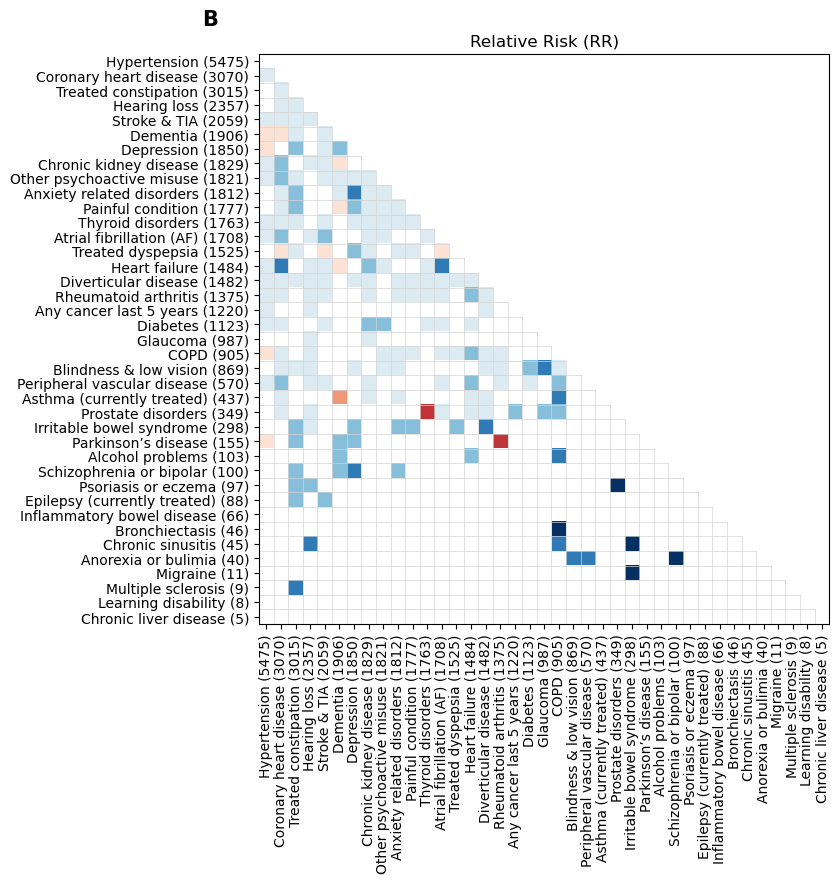

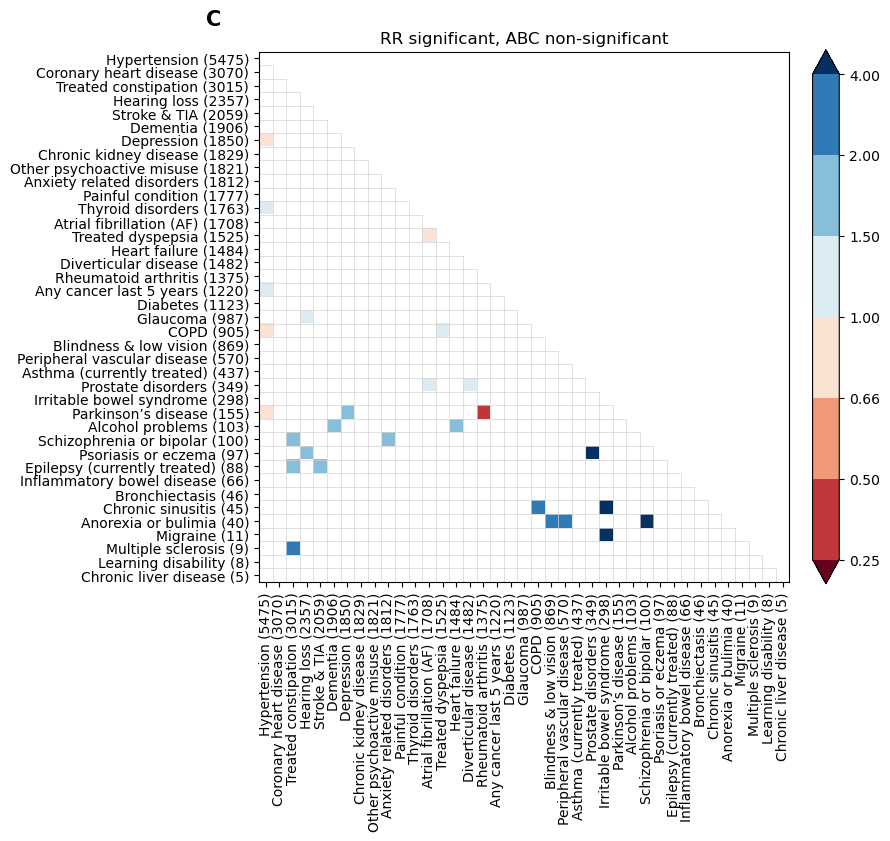

In [118]:
def plot_fig1(ax, panel):
    # max_val = 5
    # print((model.RRs[model.fishers_sig] > max_val).sum())
    # heatmap_kwargs = {"norm_kwargs": {"extend":"both"}, "max_val": max_val, "cbar_ticklabels": ["0.3", "0.5", "0.7", "1", "2", "3", "4", "5"]}
    heatmap_kwargs = dict(norm_kwargs={"extend":"both"}, boundaries=(0.25, 0.5, 0.66, 1, 1.5, 2, 4), highlight_top=False, ax=ax)
    # heatmap_kwargs = {"norm_kwargs": {"extend":"both"}, "max_val": max_val}

    if panel == "A":
        model.plot_heatmap("ABC", title="Associations Beyond Chance (ABC)", cbar=False, **heatmap_kwargs)
    elif panel == "B":
        model.plot_heatmap("RR", title="Relative Risk (RR)", cbar=False, **heatmap_kwargs)
    elif panel == "C":
        model.plot_heatmap("RR_only", title="RR significant, ABC non-significant", **heatmap_kwargs)
    
    ax.annotate(panel, xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)
    
    
# fig, axes = plt.subplots(1, 3, figsize=(9*3, 9))
for i, panel in enumerate("ABC"):
    # ax = axes[i]
    # plot_fig1(ax, panel)
    
    sub_fig, ax = plt.subplots(figsize=(9,)*2)
    plot_fig1(ax, panel)
    sub_fig.tight_layout()
    sub_fig.savefig(f"figs/fig1{panel}.eps")

# fig.tight_layout()
# fig.savefig("figs/fig1.eps")

### ABC vs RR scatterplots

165/741 data points
2/741 data points
27/741 data points
547/741 data points


/tmp/ipykernel_2618861/3211861927.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type if title is None else title);
/tmp/ipykernel_2618861/3211861927.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type if title is None else title);
/tmp/ipykernel_2618861/3211861927.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type if title is None else title);
/tmp/ipykernel_2618861/3211861927.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is N

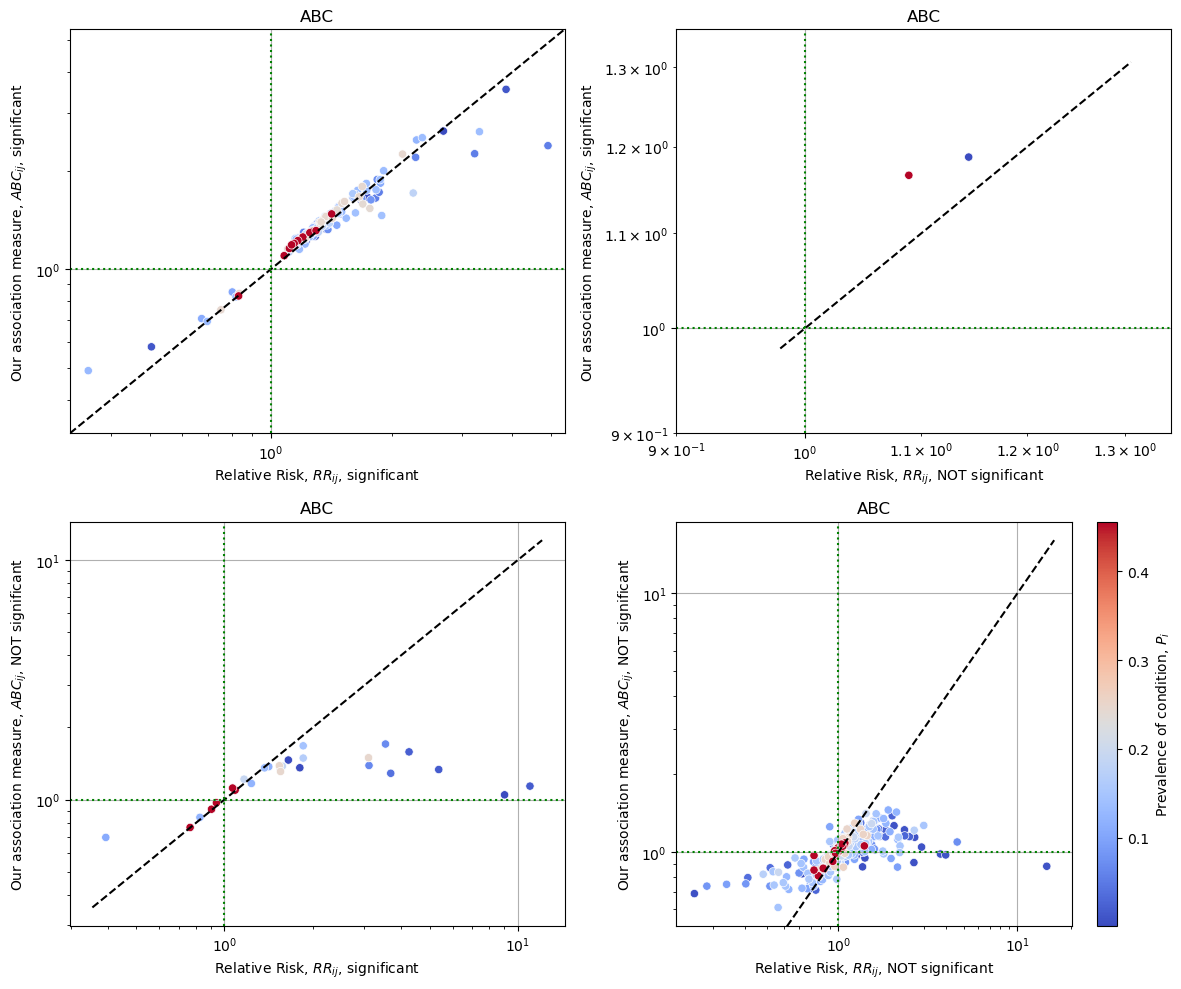

In [210]:
fig, axes = plt.subplots(2,2, figsize=(12,10)) #, sharex=True) #, sharey=True)
plot_kwargs = dict(log=True)
plot_ABC_vs_RR(axes[0][0], dat_eld, **plot_kwargs)  # xlim=[0, 5.1], ylim=[0, 4])
plot_ABC_vs_RR(axes[0][1], dat_eld, RR_conf=False, xlim=[0.9,1.35], ylim=[0.9,1.35], **plot_kwargs)
plot_ABC_vs_RR(axes[1][0], dat_eld, a_conf=False, xlim=0, ylim=0, **plot_kwargs)
plot_ABC_vs_RR(axes[1][1], dat_eld, RR_conf=False, a_conf=False, colorbar=True, xlim=0, ylim=0, fig=fig, **plot_kwargs)
fig.tight_layout();

Associations significant by ABC but not by RR:

In [56]:
model.association_df[(model.association_df["fisher_sig"]==False) & (model.association_df["a_sig"]==True)].loc[:,['Xij', 'namei+', 'namej+', 
       'fisher_sig', 'a_f_sig_CI', 'RR_f', 'RR CI (99%)', 'RR_f_sig_CI']]

Xij                       namei+  \
names                                                                    
OtherPsychoactiveMisuse-Diverticular  257  OtherPsychoactiveMisuse1821   
TreatedConstipation-CKD               500      TreatedConstipation3015   

                                                namej+  fisher_sig  \
names                                                                
OtherPsychoactiveMisuse-Diverticular  Diverticular1482       False   
TreatedConstipation-CKD                        CKD1829       False   

                                              a_f_sig_CI  RR_f  RR CI (99%)  \
names                                                                         
OtherPsychoactiveMisuse-Diverticular   1.19 (1.01 - 1.4)  1.14  1.13 - 1.15   
TreatedConstipation-CKD               1.17 (1.01 - 1.27)  1.09  1.08 - 1.09   

                                     RR_f_sig_CI  
names                                             
OtherPsychoactiveMisuse-Diverticular          NS  
TreatedConstipation-CKD                       NS

### Network visualisation and analysis

In [ ]:
def beautify_node_labels(a_list_of_names, sep="\n"):
    beautify_dict = {name: sep.join(re.findall('[A-Z]+[a-z]*|\d+', name)) for name in a_list_of_names}
    beautify_dict.update({"AnyCancer_Last5Yrs": "Any Cancer\nLast 5 Years",
                         "ChronicLiverDisease": "Chronic Liver\nDisease",
                         "PeripheralVascularDisease": "Peripheral Vascular\nDisease",
                         "RheumatoidArthritisEtc": "Rheumaotid\nArthritis",
                         "IrritableBowelSyndrome": "IBS", })
    return [beautify_dict[name] for name in a_list_of_names]

def build_and_plot_network(data, var, build_kwargs={}, **plot_kwargs):
    all_conditions = True if "layout" in plot_kwargs and plot_kwargs["layout"] == nx.circular_layout and communities == False else False
    network, network_df = build_network(data, var, morbidity_names=names, all_conditions=all_conditions, **build_kwargs)
    return plot_network(network, network_df, var, beautify_list_funct=beautify_node_labels, **plot_kwargs)

No communities.

In [64]:
plot_kwargs = dict(communities=False, figsize=(600, 550), interactive=True, prev_size=True)
# plot_kwargs = {"communities": False, "figsize":(600, 550), "layout":nx.circular_layout}

G_ABC, ax1 = build_and_plot_network(dat_eld, model, var="ABC", title=f"A: ABC", **plot_kwargs)
G_RR, ax2 = build_and_plot_network(dat_eld, model, var="RR", title=f"B: RR", **plot_kwargs)
gr = grid([[ax1, ax2]])
show(gr)

Original size: 167 edges, 32 nodes, filtered size: 167 edges, 32 nodes.
Original size: 192 edges, 36 nodes, filtered size: 192 edges, 36 nodes.


With communities.

In [283]:
plot_kwargs = {"communities": True, "figsize":(600, 550), "interactive":True, "prev_size":True, "community_weight":True,
               "layout": nx.kamada_kawai_layout, "span":9}
# plot_kwargs = {"communities": True, "layout":nx.circular_layout, "figsize":(600, 550), "build_kwargs": {"cutoff":0.25}}

G_ABC, ax1, comm_ABC = build_and_plot_network(dat_eld, var="ABC", title=f"A: ABC", **plot_kwargs)
G_RR, ax2, comm_RR = build_and_plot_network(dat_eld, var="RR", title=f"B: RR", **plot_kwargs)
gr = grid([[ax1, ax2]])
show(gr)

Original size: 167 edges, 32 nodes, filtered size: 167 edges, 32 nodes.
Modularity: 0.18146939653626876 coverage-performance (0.5389221556886228, 0.7620967741935484)
Original size: 192 edges, 36 nodes, filtered size: 192 edges, 36 nodes.
Modularity: 0.13623046874999997 coverage-performance (0.4427083333333333, 0.7301587301587301)


List of communities

In [284]:
comm_ABC, comm_RR

([['Hypertension',
   'Coronary heart disease',
   'Diabetes',
   'Thyroid disorders',
   'Rheumatoid arthritis',
   'Other psychoactive misuse',
   'Stroke & TIA',
   'Chronic kidney disease',
   'Atrial fibrillation (AF)',
   'Peripheral vascular disease',
   'Heart failure'],
  ['Depression',
   'Painful condition',
   'Parkinson’s disease',
   'Treated dyspepsia',
   'Anxiety related disorders',
   'Irritable bowel syndrome',
   'Treated constipation',
   'Diverticular disease',
   'Dementia',
   'Schizophrenia or bipolar',
   'Psoriasis or eczema'],
  ['Chronic sinusitis',
   'Prostate disorders',
   'Glaucoma',
   'Hearing loss',
   'Any cancer last 5 years',
   'Blindness & low vision'],
  ['Asthma (currently treated)',
   'COPD',
   'Bronchiectasis',
   'Alcohol problems']],
 [['Depression',
   'Painful condition',
   'Parkinson’s disease',
   'Treated dyspepsia',
   'Multiple sclerosis',
   'Thyroid disorders',
   'Anxiety related disorders',
   'Other psychoactive misuse',
  

### Average associations (and node degrees)

Node degrees (left, sorted by prevalence; right, sorted by strength)

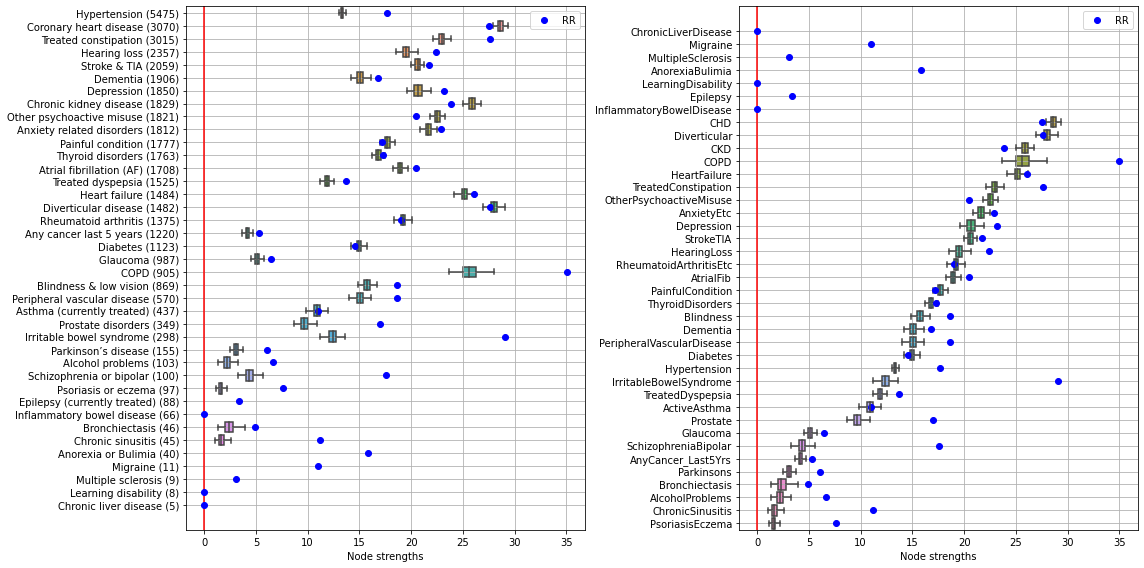

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
model.plot_node_degrees(axes[0], pvalue=pval);
model.plot_node_degrees(axes[1], pvalue=pval, sort_by="degree");
fig.tight_layout();

Average associations (sorted by prevalence)

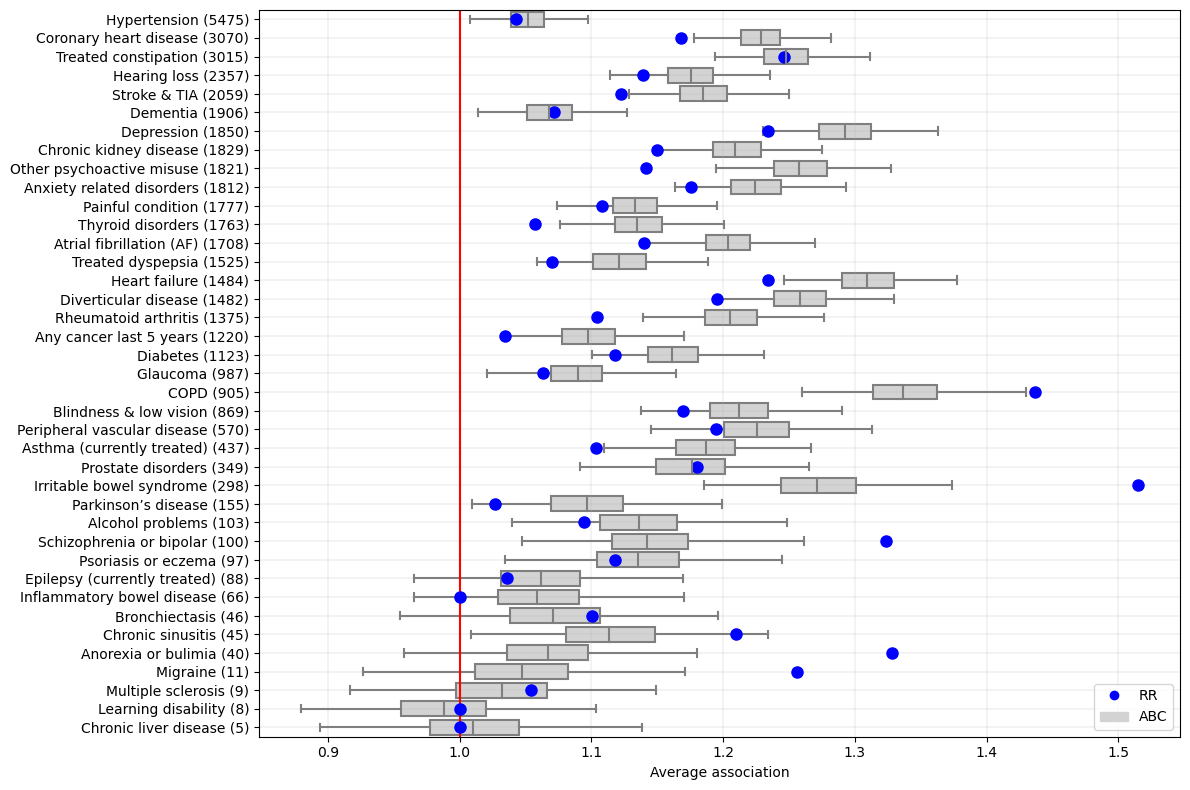

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
model.plot_node_degrees(ax, pvalue=pval, catch_all=True, log=False);
fig.tight_layout();

Average associations (sorted by strength)

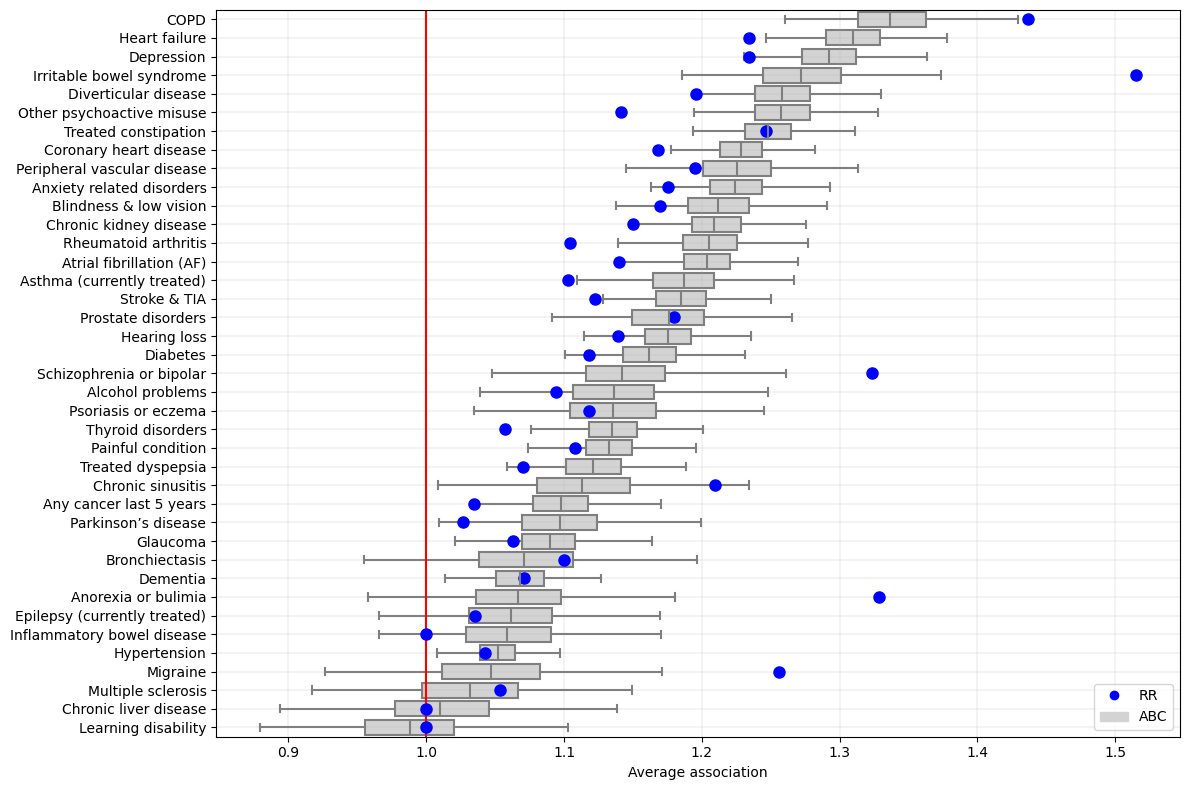

In [137]:
fig, ax = plt.subplots(figsize=(12, 8))
strengths = model.plot_node_degrees(ax, pvalue=pval, catch_all=True, sort_by="degree");
fig.tight_layout();

In [150]:
avg_assocs = {}
for LTC, avgs in strengths[0].items():
    avg_assocs[LTC] = [f"{np.median(avgs):.3} ({np.percentile(avgs, 0.5):.3} - {np.percentile(avgs, 99.5):.3})", f"{float(strengths[1][LTC]):.3}"]
                                        
avg_assocs = pd.DataFrame.from_dict(avg_assocs, orient="index", columns=["ABC (CI 99%)", "RR"])
# avg_assocs.loc[strengths[3]]
avg_assocs.sort_values("RR", ascending=False).loc[:, ["RR", "ABC (CI 99%)"]]

RR           AB (CI 99%)
IrritableBowelSyndrome     1.52    1.27 (1.18 - 1.39)
COPD                       1.44    1.34 (1.25 - 1.44)
AnorexiaBulimia            1.33   1.07 (0.951 - 1.19)
SchizophreniaBipolar       1.32    1.14 (1.04 - 1.27)
Migraine                   1.26   1.05 (0.922 - 1.19)
TreatedConstipation        1.25    1.25 (1.19 - 1.32)
HeartFailure               1.23    1.31 (1.24 - 1.38)
Depression                 1.23    1.29 (1.23 - 1.37)
ChronicSinusitis           1.21   1.11 (0.992 - 1.24)
Diverticular                1.2    1.26 (1.19 - 1.34)
PeripheralVascularDisease  1.19    1.23 (1.14 - 1.33)
AnxietyEtc                 1.18     1.22 (1.16 - 1.3)
Prostate                   1.18    1.18 (1.08 - 1.27)
CHD                        1.17    1.23 (1.17 - 1.29)
Blindness                  1.17     1.21 (1.13 - 1.3)
CKD                        1.15    1.21 (1.15 - 1.28)
OtherPsychoactiveMisuse    1.14    1.26 (1.19 - 1.34)
AtrialFib                  1.14     1.2 (1.13 - 1.28)
HearingLoss                1.14    1.18 (1.11 - 1.24)
Diabetes                   1.12    1.16 (1.09 - 1.24)
StrokeTIA                  1.12    1.18 (1.12 - 1.26)
PsoriasisEczema            1.12    1.14 (1.03 - 1.26)
PainfulCondition           1.11     1.13 (1.07 - 1.2)
Bronchiectasis              1.1   1.07 (0.948 - 1.21)
RheumatoidArthritisEtc      1.1    1.21 (1.13 - 1.29)
ActiveAsthma                1.1     1.19 (1.1 - 1.28)
AlcoholProblems            1.09    1.14 (1.03 - 1.26)
TreatedDyspepsia           1.07    1.12 (1.05 - 1.19)
Dementia                   1.07    1.07 (1.01 - 1.14)
ThyroidDisorders           1.06    1.13 (1.07 - 1.21)
Glaucoma                   1.06    1.09 (1.01 - 1.17)
MultipleSclerosis          1.05    1.03 (0.91 - 1.16)
Hypertension               1.04      1.05 (1.0 - 1.1)
Epilepsy                   1.04   1.06 (0.954 - 1.18)
Parkinsons                 1.03    1.1 (0.996 - 1.21)
AnyCancer_Last5Yrs         1.03     1.1 (1.03 - 1.18)
LearningDisability          1.0  0.988 (0.868 - 1.12)
InflammatoryBowelDisease    1.0   1.06 (0.949 - 1.18)
ChronicLiverDisease         1.0   1.01 (0.887 - 1.15)

In [47]:
print(beautify_index(avg_assocs.sort_values("RR", ascending=False).loc[:, ["RR", "ABC (CI 99%)"]], short=False).style.to_latex())

\begin{tabular}{lll}
 & AB (CI 99%) & RR \\
Chronic obstructive pulmonary disease (COPD) & 1.34 (1.25 - 1.44) & 1.44 \\
Heart failure & 1.31 (1.24 - 1.38) & 1.23 \\
Depression & 1.29 (1.23 - 1.37) & 1.23 \\
Irritable bowel syndrome (IBS) & 1.27 (1.18 - 1.39) & 1.52 \\
Diverticular disease of intestine & 1.26 (1.19 - 1.34) & 1.2 \\
Other psychoactive misuse & 1.26 (1.19 - 1.34) & 1.14 \\
Treated constipation & 1.25 (1.19 - 1.32) & 1.25 \\
Coronary heart disease (CHD) & 1.23 (1.17 - 1.29) & 1.17 \\
Peripheral vascular disease & 1.23 (1.14 - 1.33) & 1.19 \\
Anxiety & other neurotic, stress related & somatoform disorders & 1.22 (1.16 - 1.3) & 1.18 \\
Blindness & low vision & 1.21 (1.13 - 1.3) & 1.17 \\
Chronic kidney disease (CKD) & 1.21 (1.15 - 1.28) & 1.15 \\
Rheumatoid arthritis, other inflammatory polyarthropathies & systematic connective tissue disorders & 1.21 (1.13 - 1.29) & 1.1 \\
Atrial fibrillation (AF) & 1.2 (1.13 - 1.28) & 1.14 \\
Asthma (currently treated) & 1.19 (1.1 - 1.28) 

#### Bootstrapped results

In [103]:
def compute_mean_RR_degree(RRs, dat, catch_all=True, sort_by="prev"):
    RR_dat_sig = dat[dat["fisher_sig"]].loc[:, ["namei", "namej"]]
    
    RR_deg = {}
    for LTC1 in model.morb_names:
        if LTC1 in RR_dat_sig.values:
            LTC1_id = identify_LTC(LTC1, model.morb_names)[0]
            sig_RRs = []
            for LTC2 in model.morb_names:
                if (((RR_dat_sig["namei"] == LTC1) & (RR_dat_sig["namej"] == LTC2)).sum() > 0) or (
                        ((RR_dat_sig["namej"] == LTC1) & (RR_dat_sig["namei"] == LTC2)).sum() > 0):
                    RR_values = RRs[LTC1_id, identify_LTC(LTC2, model.morb_names)[0]]
                    sig_RRs.append(RR_values)  # if not log else np.log(RR_values))
                else:
                    # pass
                    sig_RRs.append(1 if catch_all else 0)
            RR_deg[LTC1] = sum(sig_RRs) if not catch_all else np.mean(sig_RRs)
        else:
            RR_deg[LTC1] = 0 if not catch_all else 1  # np.NaN

    return RR_deg


def non_parametric_bootstrap(nsim=5):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    
    M = len(df_eld)
    statistic = {LTC: np.zeros(nsim) for LTC in model.morb_names}
    
    t0 = time.time()
    t_i = t0
    for i in range(nsim):
        # Re-sample the data
        indices = np.random.randint(0, M, M)
        dat_i = df_eld.loc[df_eld.index[indices]]
        X = np.array(MLTC_count(dat_i, names), dtype=int)
        P = np.array([dat_i[name].sum() for name in names])
        
        # Compute the average RR per LTC=
        RR_i, res_i = compute_RR(X, P, M, pval=pval, corrected_pval=corrected_pval, conf_intervals=False)
        RR_i_df = pd.DataFrame(
            [{"i": i, "j": j, "namei": model.morb_names[i], "namej": model.morb_names[j], "names": f"{model.morb_names[i]}-{model.morb_names[j]}",
              "Xi": P_abs[i], "Xj": P_abs[j], "Xij": X[i, j], "Pi": P_abs[i] / M, "Pj": P_abs[j] / M, "Cij": X[i, j] / M,
              "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),
              "namei+": f"{model.morb_names[i]}{P_abs[i]}", "namej+": f"{model.morb_names[j]}{P_abs[j]}",
              "RR": RRs[i, j], "fisher_sig": fishers_sig[i, j]} for (i, j) in it.combinations(range(len(model.morb_names)), 2)])

        RR_i_df["RR_f"] = RR_i_df["RR"].apply(lambda x: f"{x:.3}")
        RR_i_df = RR_i_df.set_index(res["names"])
        
        RR_deg_i = compute_mean_RR_degree(RR_i, RR_i_df)
        for LTC in statistic.keys(): statistic[LTC][i] = RR_deg_i[LTC]
        
        if nsim <= 20:
            print(f"Sample {i} computed. Elapsed time:", time.strftime("%H hours, %M minutes, %S seconds.", time.gmtime(-(t_i - (t_i := time.time())))))
        else:
            print(i, end=" ")
    
    print(f"Total elapsed time:", time.strftime("%H hours, %M minutes, %S seconds.", time.gmtime(t_i - t0)))
    
    return statistic

In [104]:
bootstrapped_RR = non_parametric_bootstrap(nsim=1000)

0 1 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


2 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


3 4 5 6 7 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


8 9 10 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


11 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


12 13 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


14 15 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


16 17 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


18 19 20 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


21 22 23 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


24 25 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


26 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


27 28 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


29 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


30 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


31 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


32 33 34 35 36 37 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


38 39 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


40 41 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


42 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


43 44 45 46 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


47 48 49 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


50 51 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


52 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


53 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


54 55 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


56 57 58 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


59 60 61 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


62 63 64 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


65 66 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


67 68 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


69 70 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


71 72 73 74 75 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


76 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


77 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


78 79 80 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


81 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


82 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


83 84 85 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


86 87 88 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


89 90 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


91 92 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


93 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


94 95 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


96 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


97 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


98 99 100 101 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


102 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


103 104 105 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


106 107 108 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


109 110 111 112 113 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


114 115 116 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


117 118 119 120 121 122 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


123 124 125 126 127 128 129 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


130 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


131 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


132 133 134 135 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


136 137 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


138 139 140 141 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


142 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


143 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


144 145 146 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


147 148 149 150 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


151 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


152 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


153 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


154 155 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


156 157 158 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


159 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


160 161 162 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


163 164 165 166 167 168 169 170 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


171 172 173 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


174 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


175 176 177 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


178 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


179 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


180 181 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


182 183 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


184 185 186 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


187 188 189 190 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


191 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


192 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


193 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


194 195 196 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


197 198 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


199 200 201 202 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


203 204 205 206 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


207 208 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


209 210 211 212 213 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


214 215 216 217 218 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


219 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


220 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


221 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


222 223 224 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


225 226 227 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


228 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


229 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


230 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


231 232 233 234 235 236 237 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


238 239 240 241 242 243 244 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


245 246 247 248 249 250 251 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


252 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


253 254 255 256 257 258 259 260 261 262 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


263 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


264 265 266 267 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


268 269 270 271 272 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


273 274 275 276 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


277 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


278 279 280 281 282 283 284 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


285 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


286 287 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


288 289 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


290 291 292 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


293 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


294 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


295 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


296 297 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


298 299 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


300 301 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


302 303 304 305 306 307 308 309 310 311 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


312 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


313 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


314 315 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


316 317 318 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


319 320 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)


321 322 323 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


324 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


325 326 327 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


328 329 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


330 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


331 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


332 333 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


334 335 336 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


337 338 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


339 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


340 341 342 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


343 344 345 346 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


347 348 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


349 350 351 352 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


353 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


354 355 356 357 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


358 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


359 360 361 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


362 363 364 365 366 367 368 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


369 370 371 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


372 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


373 374 375 376 377 378 379 380 381 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


382 383 384 385 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


386 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


387 388 389 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


390 391 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


392 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


393 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


394 395 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


396 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


397 398 399 400 401 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


402 403 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


404 405 406 407 408 409 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


410 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


411 412 413 414 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


415 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


416 417 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


418 419 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


420 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


421 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


422 423 424 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


425 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


426 427 428 429 430 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


431 432 433 434 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


435 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


436 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


437 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


438 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


439 440 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


441 442 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


443 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


444 445 446 447 448 449 450 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


451 452 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


453 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


454 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


455 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


456 457 458 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


459 460 461 462 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


463 464 465 466 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


467 468 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


469 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


470 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


471 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


472 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


473 474 475 476 477 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


478 479 480 481 482 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


483 484 485 486 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


487 488 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


489 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


490 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


491 492 493 494 495 496 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


497 498 499 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


500 501 502 503 504 505 506 507 508 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


509 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


510 511 512 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


513 514 515 516 517 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


518 519 520 521 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


522 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


523 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


524 525 526 527 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


528 529 530 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


531 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


532 533 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


534 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


535 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


536 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


537 538 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


539 540 541 542 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


543 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


544 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


545 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


546 547 548 549 550 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


551 552 553 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


554 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


555 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


556 557 558 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


559 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


560 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


561 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


562 563 564 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


565 566 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


567 568 569 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


570 571 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


572 573 574 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)


575 576 577 578 579 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


580 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


581 582 583 584 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


585 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


586 587 588 589 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


590 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


591 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


592 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


593 594 595 596 597 598 599 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


600 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


601 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


602 603 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


604 605 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


606 607 608 609 610 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


611 612 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


613 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


614 615 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


616 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


617 618 619 620 621 622 623 624 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


625 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


626 627 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


628 629 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


630 631 632 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


633 634 635 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


636 637 638 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


639 640 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


641 642 643 644 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


645 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


646 647 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


648 649 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


650 651 652 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


653 654 655 656 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


657 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


658 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


659 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


660 661 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


662 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


663 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


664 665 666 667 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


668 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


669 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


670 671 672 673 674 675 676 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


677 678 679 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


680 681 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


682 683 684 685 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


686 687 688 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


689 690 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


691 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


692 693 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


694 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


695 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


696 697 698 699 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


700 701 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


702 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


703 704 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


705 706 707 708 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


709 710 711 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


712 713 714 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


715 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


716 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


717 718 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


719 720 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


721 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


722 723 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


724 725 726 727 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


728 729 730 731 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


732 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


733 734 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


735 736 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


737 738 739 740 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


741 742 743 744 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


745 746 747 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


748 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


749 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


750 751 752 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


753 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


754 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


755 756 757 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


758 759 760 761 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


762 763 764 765 766 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


767 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


768 769 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


770 771 772 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


773 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


774 775 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


776 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


777 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


778 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


779 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


780 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


781 782 783 784 785 786 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


787 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


788 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


789 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


790 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


791 792 793 794 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


795 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


796 797 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


798 799 800 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


801 802 803 804 805 806 807 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


808 809 810 811 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


812 813 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


814 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


815 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


816 817 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


818 819 820 821 822 823 824 825 826 827 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


828 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


829 830 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


831 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


832 833 834 835 836 837 838 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


839 840 841 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


842 843 844 845 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


846 847 848 849 850 851 852 853 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


854 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


855 856 857 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


858 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


859 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


860 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


861 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


862 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


863 864 865 866 867 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


868 869 870 871 872 873 874 875 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


876 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


877 878 879 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


880 881 882 883 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


884 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


885 886 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


887 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


888 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


889 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


890 891 892 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


893 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


894 895 896 897 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


898 899 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


900 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


901 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


902 903 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


904 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


905 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


906 907 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


908 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


909 910 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


911 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


912 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


913 914 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


915 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


916 917 918 919 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


920 921 922 923 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


924 925 926 927 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


928 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


929 930 931 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


932 933 934 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


935 936 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


937 938 939 940 941 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


942 943 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


944 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


945 946 947 948 949 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


950 951 952 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


953 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


954 955 956 957 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


958 959 960 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


961 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


962 963 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


964 965 966 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


967 968 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


969 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


970 971 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


972 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


973 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


974 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


975 976 977 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


978 979 980 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


981 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


982 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


983 984 985 986 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


987 988 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


989 990 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


991 992 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


993 994 995 

/tmp/ipykernel_147373/1315032423.py:10: RuntimeWarning: invalid value encountered in true_divide
  RRs = (X / P_abs[None, :] / P_abs[:, None] * M)
/tmp/ipykernel_147373/1315032423.py:25: RuntimeWarning: invalid value encountered in long_scalars
  "Pi|j": (Pij := X[i, j] / P_abs[j]), "Pj|i": (Pji := X[i, j] / P_abs[i]), "maxPi|j": max(Pij, Pji),


996 997 998 999 Total elapsed time: 00 hours, 00 minutes, 00 seconds.


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:1181: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sorted_labels)


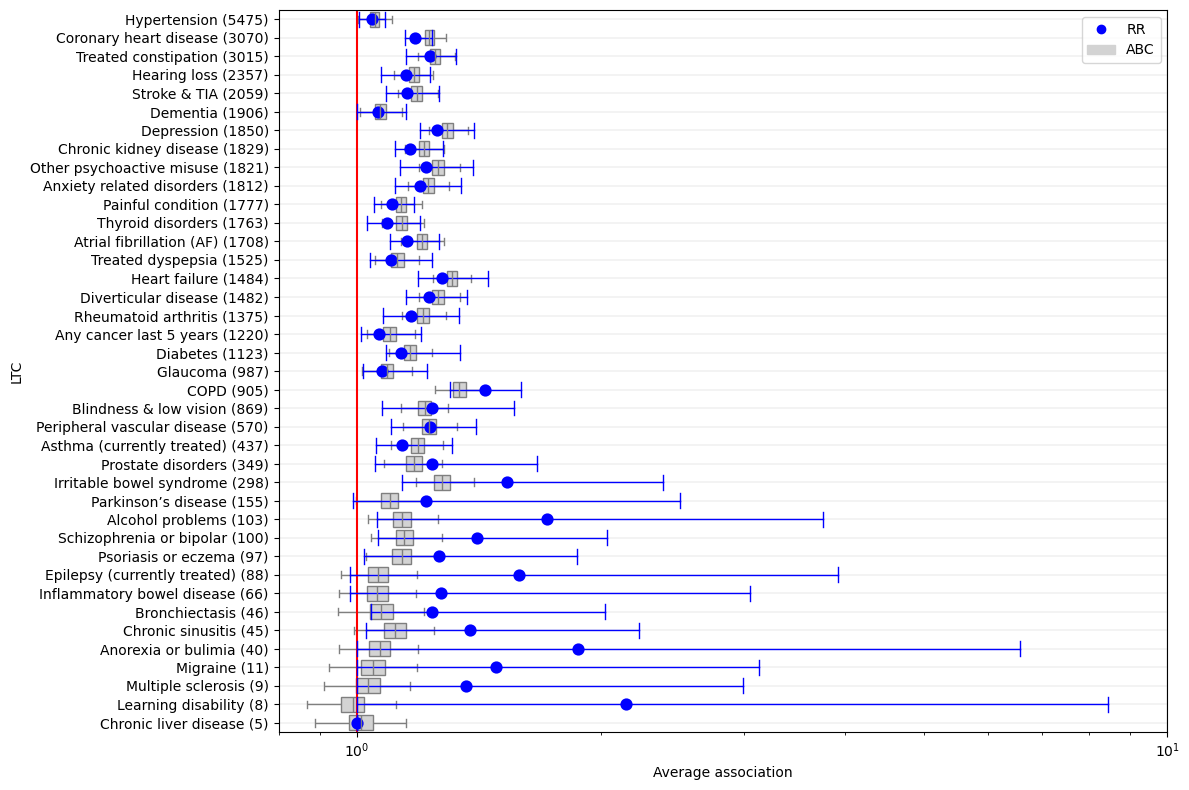

In [193]:
fig, ax = plt.subplots(figsize=(12, 8))
model.plot_node_degrees(ax, pvalue=pval, catch_all=True, log=True, bootstrapped_RR=bootstrapped_RR, xlim=(0.8,10));
fig.tight_layout();
fig.savefig("figs/bootstraped_node_degrees.pdf");

### All associations

In [58]:
# Since all significant associations by ABC are also significant by RR, it's enough to get the 2nd
_, _, all_RR_assoc, _ = get_top_associations(dat_eld, top_N_positive=None, short=True)
print(all_RR_assoc.style.to_latex())

\begin{tabular}{lll}
 & RR_f_sig_CI & a_f_sig_CI \\
Irritable bowel syndrome - Migraine & 11.0 (4.65 - 26.0) & NS \\
Schizophrenia or bipolar - Anorexia or bulimia & 9.01 (3.81 - 21.3) & NS \\
Irritable bowel syndrome - Chronic sinusitis & 5.37 (3.5 - 8.25) & NS \\
COPD - Bronchiectasis & 4.9 (4.22 - 5.71) & 2.38 (1.24 - 4.24) \\
Prostate disorders - Psoriasis or eczema & 4.26 (3.44 - 5.28) & NS \\
Asthma (currently treated) - COPD & 3.86 (3.78 - 3.93) & 3.54 (2.87 - 4.43) \\
Peripheral vascular disease - Anorexia or bulimia & 3.69 (2.55 - 5.33) & NS \\
COPD - Chronic sinusitis & 3.54 (2.86 - 4.39) & NS \\
Depression - Schizophrenia or bipolar & 3.31 (3.15 - 3.48) & 2.63 (1.89 - 3.84) \\
COPD - Alcohol problems & 3.22 (2.91 - 3.57) & 2.25 (1.28 - 3.4) \\
Blindness & low vision - Anorexia or bulimia & 3.11 (2.34 - 4.14) & NS \\
Treated constipation - Multiple sclerosis & 3.1 (2.14 - 4.48) & NS \\
Irritable bowel syndrome - Diverticular disease & 2.69 (2.62 - 2.76) & 2.64 (1.94 - 3.25) \

## Results with other CIs

In [14]:
num_warmup = 500

models = {}
for pval in (0.99, 0.9, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001):
    model = ABCModel(model_name="MLTC_atomic_hyp_mult")
    model.load_fit(df_eld, fname_eld + "0mu" + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    
    triu = np.triu_indices(n=len(model.morb_names), k=1)
    bonferroni = False
    corrected_pval = pval if not bonferroni else pval / len(triu[0])
    print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")
    model.get_results_dataframe(pval, corrected_pval)
    
    models[CI] = model


max_val = 5
for pval, model in models.items():
    print("Significant RR", model.RRs_signif[triu_l].sum(), "Significant RR (Fisher)", model.fishers_sig[triu_l].sum(), "Significant ABC", model.r_sig[triu_l].sum())
    print((model.RRs[model.fishers_sig] > max_val).sum())
    heatmap_kwargs = dict(norm_kwargs={"extend":"both"}, boundaries=(0.25, 0.5, 0.66, 1, 1.5, 2, 4), cbar=False)

    fig, axes = plt.subplots(1, 2, figsize=(18,)*2)
    model.plot_heatmap("ABC", title="Associations Beyond Chance (ABC)", ax=axes[0], **heatmap_kwargs)
    model.plot_heatmap("RR", title="Relative Risk (RR)", ax=axes[1], **heatmap_kwargs)
    for i, panel in enumerate("AB"):
        axes[i].annotate(panel, xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)
    fig.tight_layout()

## Bonferroni correction (CI 95%)

In [16]:
# Select model
model = ABCModel(model_name="MLTC_atomic_hyp_mult")

# Load fit (or fit new model if not saved model found)
num_warmup = 500
model.load_fit(df_eld, fname_eld + "0mu" + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)

# Compute RR and significance of RR and ABC
triu = np.triu_indices(n=len(model.morb_names), k=1)
pval = 0.05
bonferroni = True
corrected_pval = pval if not bonferroni else pval / len(triu[0])
print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")

res_bonf = model.get_results_dataframe(pval, corrected_pval)
res_bonf["i_abs"] = res_bonf["namei"].apply(lambda x: identify_LTC(x, names)[0])
res_bonf["j_abs"] = res_bonf["namej"].apply(lambda x: identify_LTC(x, names)[0])

print("Significant RR (Fisher):", model.fishers_sig[triu].sum(), ". Significant ABC:", model.r_sig[triu].sum())
print(f"Significant associatons:   Fisher (RR): {res_bonf['fisher_sig'].sum():.0f} ({100*res_bonf['fisher_sig'].sum()/len(triu[0]):.1f}%), "
      f"ABC: {res_bonf['a_sig'].sum():3.0f} ({100*res_bonf['a_sig'].sum()/len(triu[0]):.1f}%)")

Corrected p-value: 0.01, min # of samples for assessing: 100.0, required percentile: 0.5
Removing conditions without cases. Using 39 only.


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:782: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:784: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


Significant RR 410 Significant RR (Fisher) 192 Significant ABC 167


6
max ABC: 5.00 max RR: 5.00 

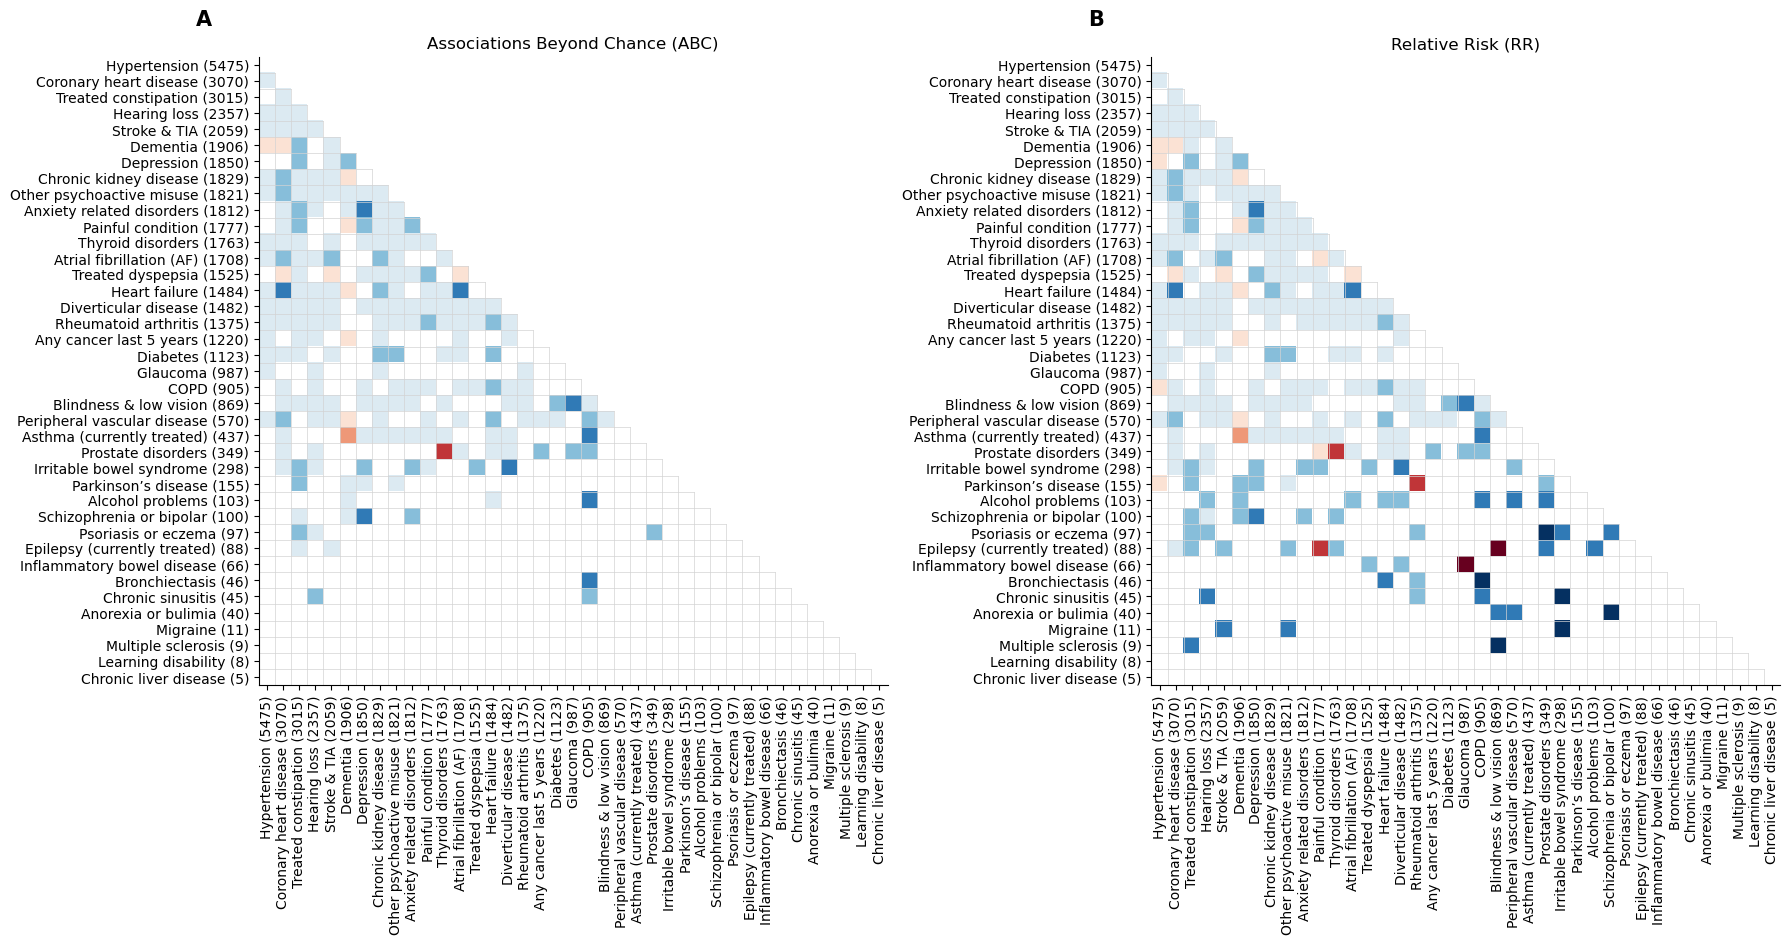

In [13]:
heatmap_kwargs = dict(norm_kwargs={"extend":"both"}, boundaries=(0.25, 0.5, 0.66, 1, 1.5, 2, 4)}

fig, axes = plt.subplots(1, 2, figsize=(18,)*2)
model.plot_heatmap("ABC", title="Associations Beyond Chance (ABC)", ax=axes[0], highlight_top=False, cbar=False, **heatmap_kwargs)
model.plot_heatmap("RR", title="Relative Risk (RR)", ax=axes[1], highlight_top=False, cbar=False, **heatmap_kwargs)
for i, panel in enumerate("AB"):
    axes[i].annotate(panel, xy=(-0.1, 1.05), xycoords='axes fraction', fontweight='bold', fontsize=15)
fig.tight_layout()

# Results WITH sex stratification

Here we stratify old patients (>90yo) into sex cohorts to find the potentially different patterns of multiple long-term conditions (MLTCs) among them.

In [7]:
dfs, labels, fnames, L, Xs, Ps, Ms = stratify(df, "Age-Sex")
fnames = [el for elo in fnames for el in elo]

indices = (18, 19)
ind_dict = {"male": indices[0], "female": indices[1]}

Length of dataset: 82798
Length of dataset: 78473
Length of dataset: 107144
Length of dataset: 101867
Length of dataset: 114115
Length of dataset: 110631
Length of dataset: 127652
Length of dataset: 121747
Length of dataset: 141623
Length of dataset: 136375
Length of dataset: 116868
Length of dataset: 115075
Length of dataset: 92461
Length of dataset: 97445
Length of dataset: 57774
Length of dataset: 72105
Length of dataset: 23947
Length of dataset: 41732
Length of dataset: 3039
Length of dataset: 8970


In [9]:
LTC_prev_df = pd.DataFrame(columns=["i"], index=names)  # index=beautify_names(names, sep=" "))
LTC_prev_df["i"] = range(len(LTC_prev_df))

for name, ind in ind_dict.items():
    LTC_prev_df["Counts_"+name] = Ps[ind]
    LTC_prev_df["Prev_"+name] = Ps[ind] / Ms[ind]
LTC_prev_df["Counts"] = LTC_prev_df["Counts_male"] + LTC_prev_df["Counts_female"]
LTC_prev_df["Prev"] = LTC_prev_df["Counts"] / (Ms[indices[0]] + Ms[indices[1]])
    
LTC_prev_df["diff_counts"] = LTC_prev_df["Counts_male"] - LTC_prev_df["Counts_female"]
LTC_prev_df["diff_prev"] = LTC_prev_df["Prev_male"] - LTC_prev_df["Prev_female"]
LTC_prev_df.sort_values(by="diff_prev")

i  Counts_male  Prev_male  Counts_female  \
Hypertension                0         1142   0.375782           4333   
ThyroidDisorders            7          206   0.067785           1557   
AnxietyEtc                 11          271   0.089174           1541   
Dementia                   26          310   0.102007           1596   
Depression                  1          299   0.098388           1551   
PainfulCondition            2          309   0.101678           1468   
OtherPsychoactiveMisuse    15          349   0.114840           1472   
TreatedConstipation        16          672   0.221125           2343   
TreatedDyspepsia            5          306   0.100691           1219   
Diverticular               19          311   0.102336           1171   
RheumatoidArthritisEtc      8          319   0.104969           1056   
IrritableBowelSyndrome     12           49   0.016124            249   
Blindness                  31          199   0.065482            670   
CKD                        18          454   0.149391           1375   
SchizophreniaBipolar       27           18   0.005923             82   
ActiveAsthma                3          104   0.034222            333   
InflammatoryBowelDisease   29           11   0.003620             55   
AnorexiaBulimia            34            7   0.002303             33   
MultipleSclerosis          37            0   0.000000              9   
ChronicSinusitis           32           10   0.003291             35   
Migraine                   30            2   0.000658              9   
Bronchiectasis             35           11   0.003620             35   
LearningDisability         33            2   0.000658              6   
ChronicLiverDisease        39            2   0.000658              3   
ViralHepatitis             38            1   0.000329              0   
PsoriasisEczema            28           38   0.012504             59   
Epilepsy                   25           38   0.012504             50   
Parkinsons                 36           59   0.019414             96   
AlcoholProblems            14           49   0.016124             54   
HeartFailure               22          410   0.134913           1074   
Diabetes                    6          321   0.105627            802   
AtrialFib                  20          472   0.155314           1236   
Glaucoma                   24          290   0.095426            697   
PeripheralVascularDisease  21          190   0.062521            380   
StrokeTIA                  17          568   0.186904           1491   
HearingLoss                 9          646   0.212570           1711   
AnyCancer_Last5Yrs         13          399   0.131293            821   
COPD                       10          343   0.112866            562   
CHD                         4          900   0.296150           2170   
Prostate                   23          349   0.114840              0   

                           Prev_female  Counts      Prev  diff_counts  \
Hypertension                  0.483055    5475  0.455908        -3191   
ThyroidDisorders              0.173579    1763  0.146807        -1351   
AnxietyEtc                    0.171795    1812  0.150887        -1270   
Dementia                      0.177926    1906  0.158714        -1286   
Depression                    0.172910    1850  0.154051        -1252   
PainfulCondition              0.163657    1777  0.147972        -1159   
OtherPsychoactiveMisuse       0.164103    1821  0.151636        -1123   
TreatedConstipation           0.261204    3015  0.251062        -1671   
TreatedDyspepsia              0.135897    1525  0.126988         -913   
Diverticular                  0.130546    1482  0.123407         -860   
RheumatoidArthritisEtc        0.117726    1375  0.114497         -737   
IrritableBowelSyndrome        0.027759     298  0.024815         -200   
Blindness                     0.074693     869  0.072362         -471   
CKD                           0.153289    1829  0.152

In [10]:
def beautify_names(a_list_of_names, sep=" ", short=False):
    beautify_dict = {}
    for name in a_list_of_names:
        words = [word if i == 0 else word.lower() for i, word in enumerate(re.findall('[A-Z]+[a-z]*|\d+', name))]
        beautify_dict[name] = sep.join(words)
        
    beautify_dict.update({
        # "PainfulCondition": "Painful condition",
        "ActiveAsthma": "Asthma (currently treated)",
        "CHD": "Coronary heart disease",
        # "TreatedDyspepsia": "Treated dyspepsia",
        # "ThyroidDisorders": "Thyroid disorders",
        "RheumatoidArthritisEtc": "Rheumatoid arthritis, other inflammatory polyarthropathies & systematic connective tissue disorders",
        # "HearingLoss": "Hearing loss",
        "COPD": "Chronic obstructive pulmonary disease (COPD)",
        "AnxietyEtc": "Anxiety & other neurotic, stress related & somatoform disorders",
        "IrritableBowelSyndrome": "Irritable bowel syndrome (IBS)",
        "AnyCancer_Last5Yrs": "New diagnosis of cancer in last five years",
        # "AlcoholProblems": "Alcohol problems",
        "Other Psychoactive Misuse": "Other psychoactive substance misuse",
        # "TreatedConstipation": "Treated constipation",
        "StrokeTIA": "Stroke & transient ischaemic attack (TIA)",
        "CKD": "Chronic kidney disease (CKD)",
        "Diverticular": "Diverticular disease of intestine",
        "AtrialFib": "Atrial fibrillation (AF)",
        # "PeripheralVascularDisease": "Peripheral vascular disease",
        # "HeartFailure": "Heart failure",
        "Prostate": "Prostate disorders",
        "Epilepsy": "Epilepsy (currently treated)",
        "SchizophreniaBipolar": "Schizophrenia (and related non-organic psychosis) or bipolar disorder",
        "PsoriasisEczema": "Psoriasis or eczema",
        # "InflammatoryBowelDisease": "Inflammatory bowel disease",
        "Blindness": "Blindness & low vision",
        "AnorexiaBulimia": "Anorexia or Bulimia",
        "Parkinsons": "Parkinson’s disease",
        "ViralHepatitis": "Viral Hepatitis",
    })
    return [beautify_dict[name] for name in a_list_of_names]

In [11]:
conds_display = LTC_prev_df.copy()

def display(x):
    return f" ({100*x:.2g}%)"

conds_display["Counts_t"] = LTC_prev_df["Counts"].astype(str) + LTC_prev_df["Prev"].apply(display)
conds_display["Counts_m"] = LTC_prev_df["Counts_male"].astype(str) + LTC_prev_df["Prev_male"].apply(display)
conds_display["Counts_f"] = LTC_prev_df["Counts_female"].astype(str) + LTC_prev_df["Prev_female"].apply(display)

conds_display.loc[(LTC_prev_df["Counts"] < 5) & (LTC_prev_df["Counts"] != 0), "Counts_t"] = "<5 (<0.04%)"
conds_display.loc[(LTC_prev_df["Counts_male"] < 5) & (LTC_prev_df["Counts_male"] != 0), "Counts_m"] = "<5 (<0.2%)"
conds_display.loc[(LTC_prev_df["Counts_female"] < 5) & (LTC_prev_df["Counts_female"] != 0), "Counts_f"] = "<5 (<0.06%)"
conds_display.sort_values(by="Counts", ascending=False).loc[:, ["Counts_t", "Counts_m", "Counts_f"]]

conds_display.index = beautify_names(conds_display.index)
conds_display.sort_values(by="Counts", ascending=False).loc[:, ["Counts_t", "Counts_m", "Counts_f"]]

Counts_t    Counts_m  \
Hypertension                                         5475 (46%)  1142 (38%)   
Coronary heart disease                               3070 (26%)   900 (30%)   
Treated constipation                                 3015 (25%)   672 (22%)   
Hearing loss                                         2357 (20%)   646 (21%)   
Stroke & transient ischaemic attack (TIA)            2059 (17%)   568 (19%)   
Dementia                                             1906 (16%)   310 (10%)   
Depression                                           1850 (15%)  299 (9.8%)   
Chronic kidney disease (CKD)                         1829 (15%)   454 (15%)   
Other psychoactive misuse                            1821 (15%)   349 (11%)   
Anxiety & other neurotic, stress related & soma...   1812 (15%)  271 (8.9%)   
Painful condition                                    1777 (15%)   309 (10%)   
Thyroid disorders                                    1763 (15%)  206 (6.8%)   
Atrial fibrillation (AF)                             1708 (14%)   472 (16%)   
Treated dyspepsia                                    1525 (13%)   306 (10%)   
Heart failure                                        1484 (12%)   410 (13%)   
Diverticular disease of intestine                    1482 (12%)   311 (10%)   
Rheumatoid arthritis, other inflammatory polyar...   1375 (11%)   319 (10%)   
New diagnosis of cancer in last five years           1220 (10%)   399 (13%)   
Diabetes                                            1123 (9.4%)   321 (11%)   
Glaucoma                                             987 (8.2%)  290 (9.5%)   
Chronic obstructive pulmonary disease (COPD)         905 (7.5%)   343 (11%)   
Blindness & low vision                               869 (7.2%)  199 (6.5%)   
Peripheral vascular disease                          570 (4.7%)  190 (6.3%)   
Asthma (currently treated)                           437 (3.6%)  104 (3.4%)   
Prostate disorders                                   349 (2.9%)   349 (11%)   
Irritable bowel syndrome (IBS)                       298 (2.5%)   49 (1.6%)   
Parkinson’s disease                                  155 (1.3%)   59 (1.9%)   
Alcohol problems                                    103 (0.86%)   49 (1.6%)   
Schizophrenia (and related non-organic psychosi...  100 (0.83%)  18 (0.59%)   
Psoriasis or eczema                                  97 (0.81%)   38 (1.3%)   
Epilepsy (currently treated)                         88 (0.73%)   38 (1.3%)   
Inflammatory bowel disease                           66 (0.55%)  11 (0.36%)   
Bronchiectasis                                       46 (0.38%)  11 (0.36%)   
Chronic sinusitis                                    45 (0.37%)  10 (0.33%)   
Anorexia or Bulimia                                  40 (0.33%)   7 (0.23%)   
Migraine                                            11 (0.092%)  <5 (<0.2%)   
Multiple sclerosis                                   9 (0.075%)      0 (0%)   
Learning disability                                  8 (0.067%)  <5 (<0.2%)   
Chronic liver disease                                5 (0.042%)  <5 (<0.2%)   
Viral Hepatitis                                     <5 (<0.04%)  <5 (<0.2%)   

                                                       Counts_f  
Hypertension                                         4333 (48%)  
Coronary heart disease                               2170 (24%)  
Treated constipation                                 2343 (26%)  
Hearing loss                                         1711 (19%)  
Stroke & transient ischaemic attack (TIA)            1491 (17%)  
Dementia                                             1596 (18%)  
Depression                                           1551 (17%)  
Chronic kidney disease (CKD)                         1375 (15%)  
Other psychoactive misuse                            1472 (16%)  
Anxiety & other neurotic, stress related & soma...   1541 (17%)  
Painful condition                                    1468 (16%)  
Thyroid disorders      

In [12]:
print(conds_display.sort_values(by="Counts", ascending=False).loc[:, ["Counts_t", "Counts_m", "Counts_f"]].to_latex())

\begin{tabular}{llll}
\toprule
{} &     Counts\_t &    Counts\_m &     Counts\_f \\
\midrule
Hypertension                                       &   5475 (46\%) &  1142 (38\%) &   4333 (48\%) \\
Coronary heart disease                             &   3070 (26\%) &   900 (30\%) &   2170 (24\%) \\
Treated constipation                               &   3015 (25\%) &   672 (22\%) &   2343 (26\%) \\
Hearing loss                                       &   2357 (20\%) &   646 (21\%) &   1711 (19\%) \\
Stroke \& transient ischaemic attack (TIA)          &   2059 (17\%) &   568 (19\%) &   1491 (17\%) \\
Dementia                                           &   1906 (16\%) &   310 (10\%) &   1596 (18\%) \\
Depression                                         &   1850 (15\%) &  299 (9.8\%) &   1551 (17\%) \\
Chronic kidney disease (CKD)                       &   1829 (15\%) &   454 (15\%) &   1375 (15\%) \\
Other psychoactive misuse                          &   1821 (15\%) &   349 (11\%) &   1472 (16\%) 

/tmp/ipykernel_3078824/3322290304.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(conds_display.sort_values(by="Counts", ascending=False).loc[:, ["Counts_t", "Counts_m", "Counts_f"]].to_latex())


## Survivorship bias

In [298]:
def study_survivor_bias(morb_cols=None, lower_lim=90):
    morb_cols = dfo.columns[11:51] if morb_cols is None else morb_cols
    
    df_eld = df[df["Age"] >= lower_lim]
    df_eld_male = df_eld[df_eld["Sex"]==0]
    df_eld_female = df_eld[df_eld["Sex"]==1]

    def plot_morb_progession(dfo, ax, title):
        axos = ax, ax.twinx()
        marker = "x"
        colors = ("C0", "C1")
        for ax_morb, morb, color in zip(axos, morb_cols, colors):
            # ax_morb = ax  # .twinx();
            counts = []
            ages = sorted(dfo["Age"].unique())
            for age in ages:
                counts.append((dfo_age := dfo[dfo["Age"] == age])[morb].sum() / len(dfo_age))
            ax_morb.plot(ages, counts, label=morb, marker=marker, color=color);
        
        ax.legend(handles=[Line2D([], [], color=color, marker=marker, label=label) for color, label in zip(colors, morb_cols)]) if len(morb_cols) < 10 else None
        ax.set(xlabel="Age", ylabel="Prevalence", title=title);

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_morb_progession(df_eld, axes[0], title="Total")
    plot_morb_progession(df_eld_male, axes[1], title="Male")
    plot_morb_progession(df_eld_female, axes[2], title="Female")
    fig.tight_layout();

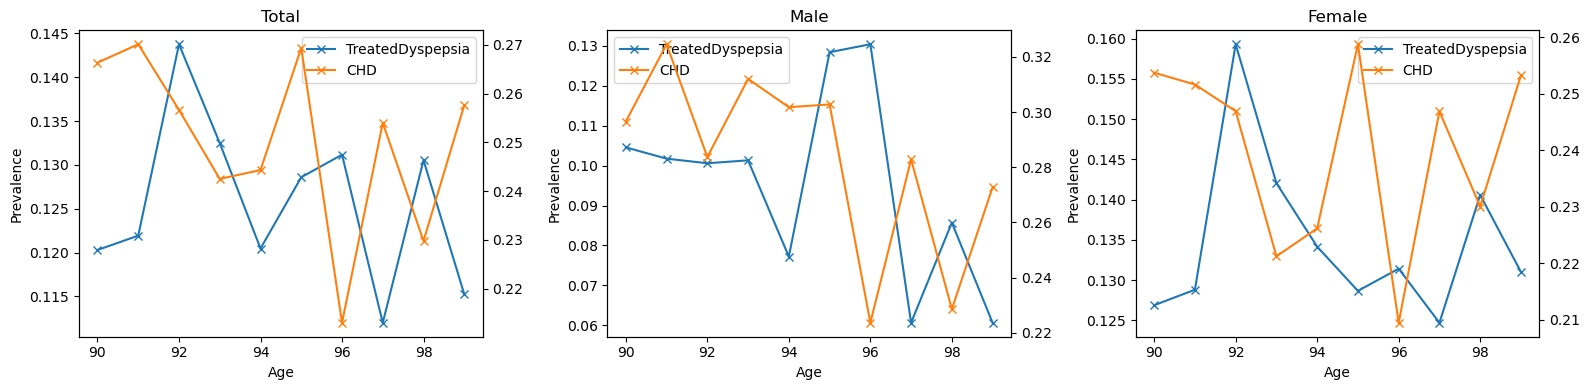

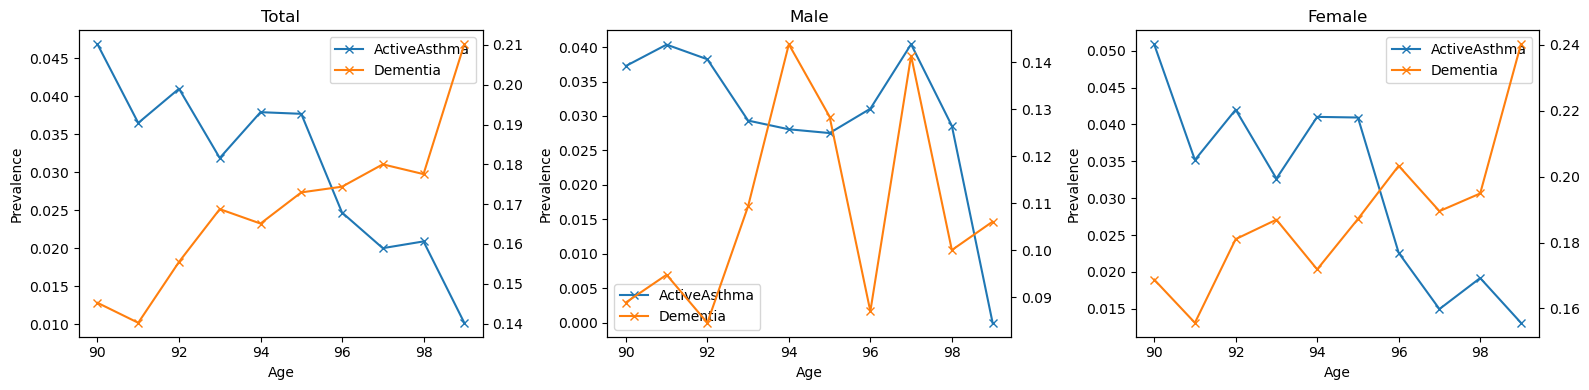

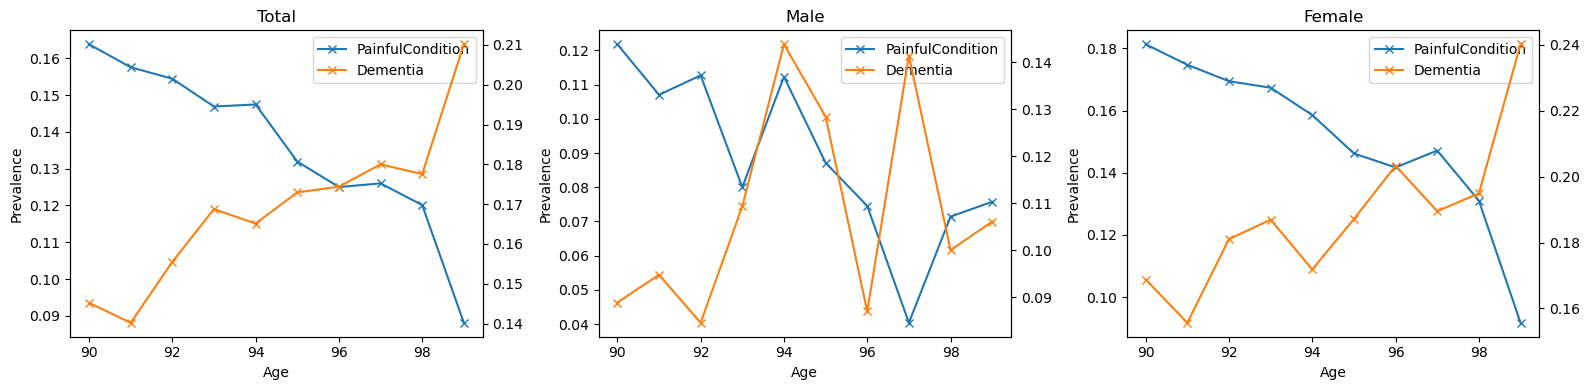

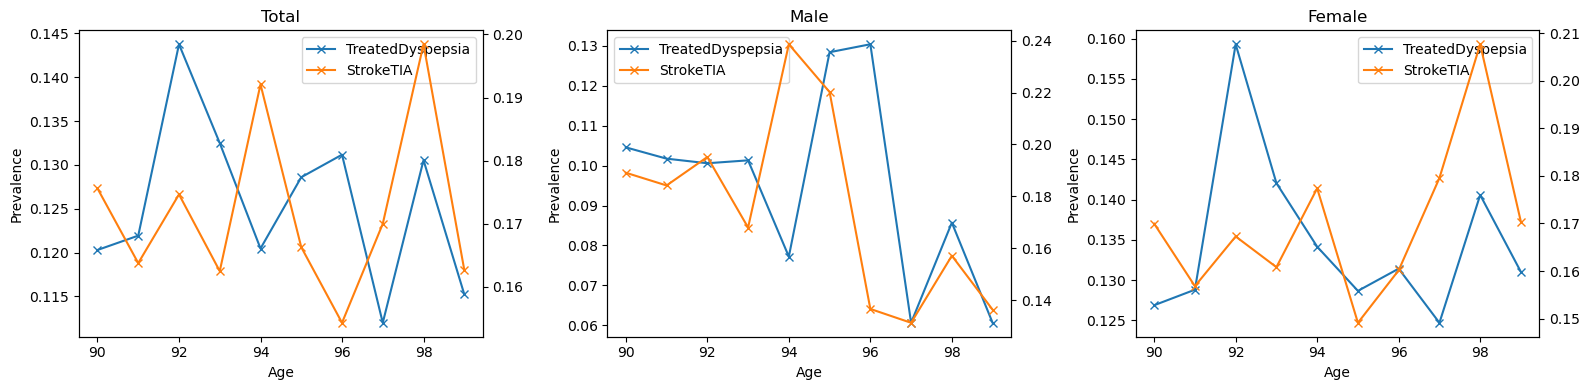

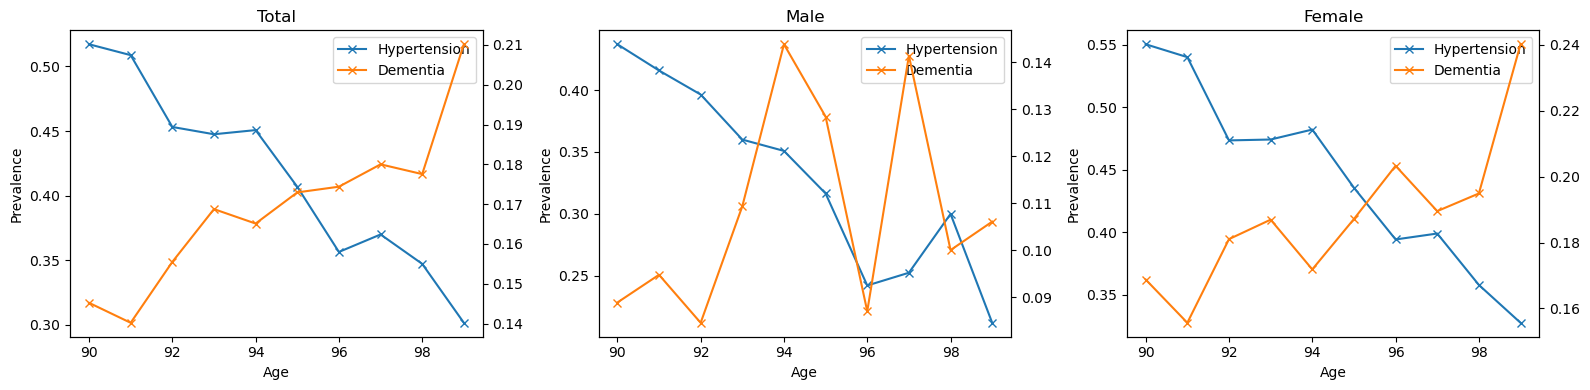

In [300]:
study_survivor_bias(morb_cols=["TreatedDyspepsia", "CHD"])
study_survivor_bias(morb_cols=["ActiveAsthma", "Dementia"])
study_survivor_bias(morb_cols=["PainfulCondition", "Dementia"])
study_survivor_bias(morb_cols=["TreatedDyspepsia", "StrokeTIA"])
study_survivor_bias(morb_cols=["Hypertension", "Dementia"])

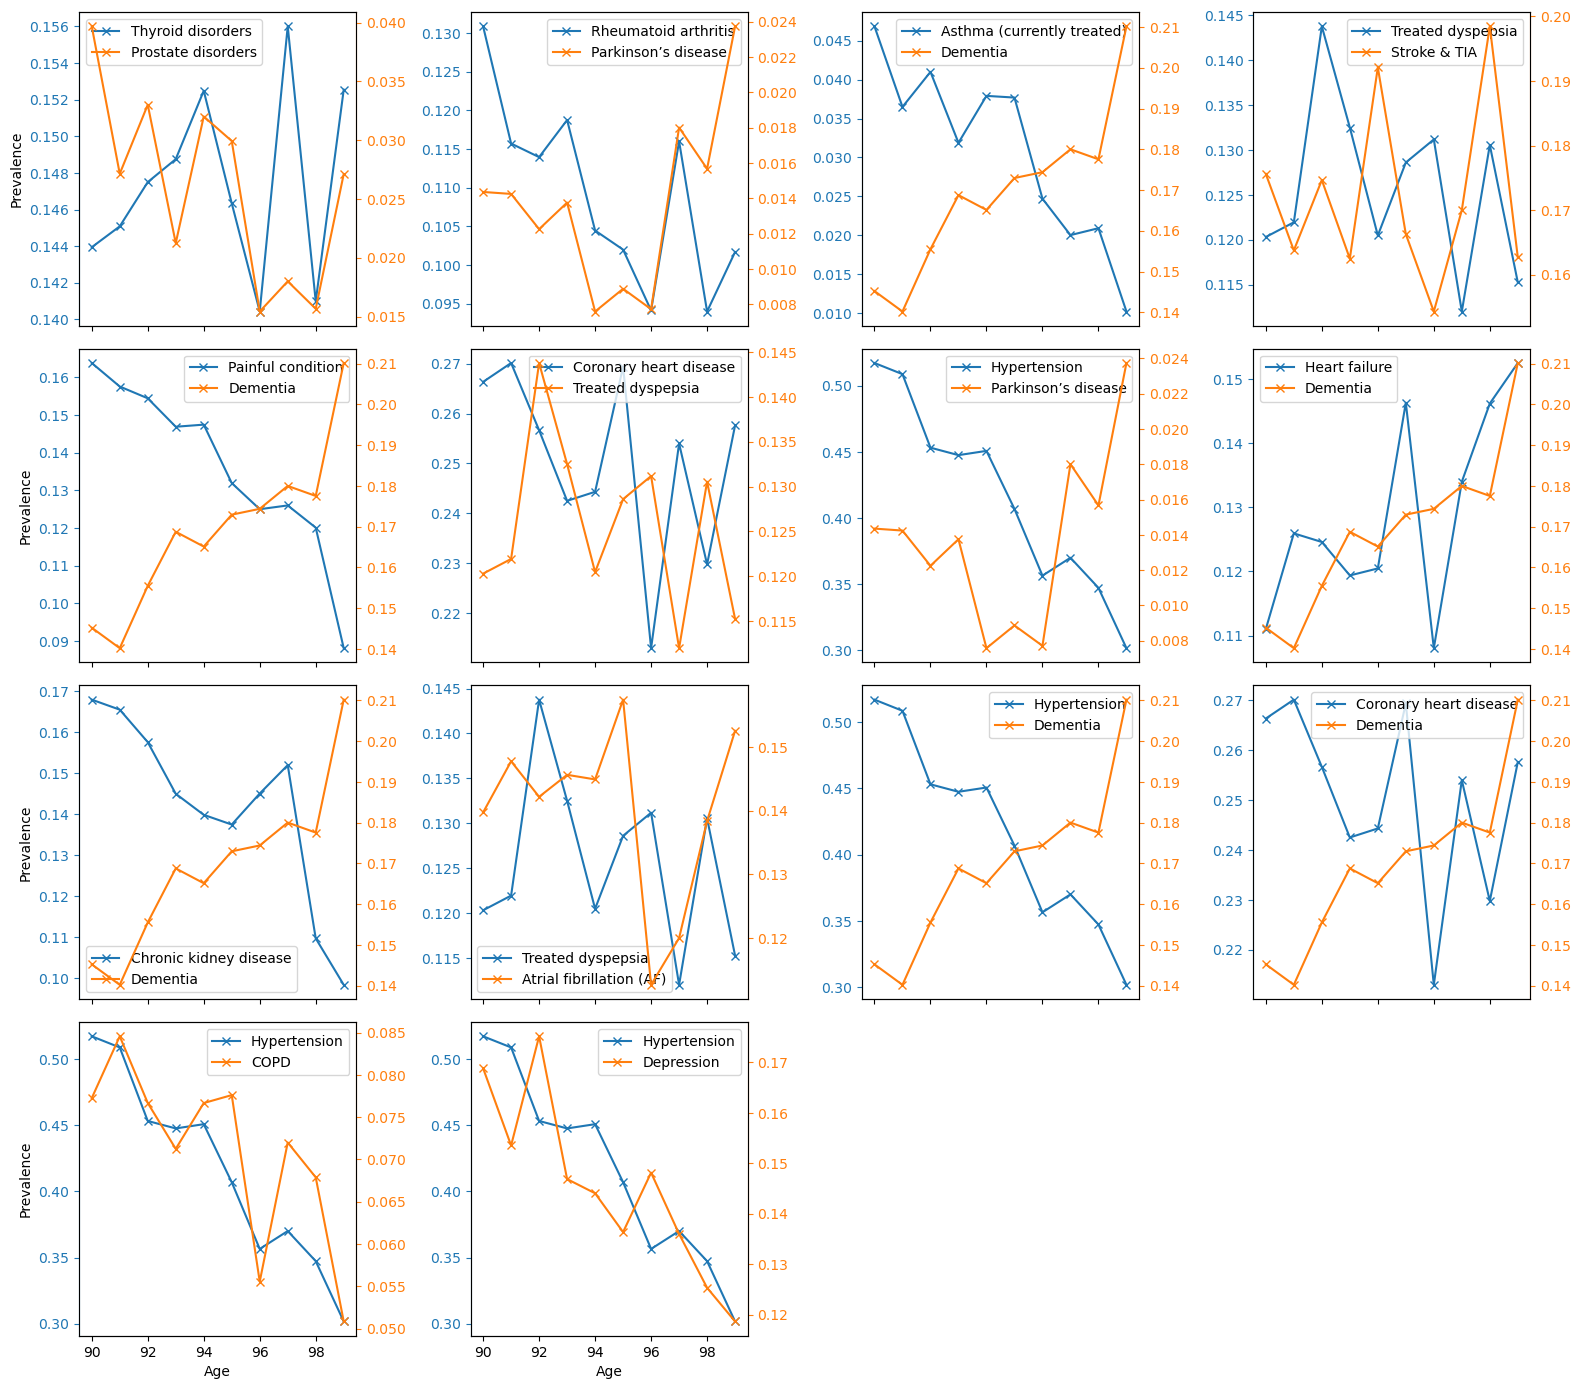

In [301]:
df_eld = df[df["Age"] >= 90]

pairs_list = [
    ["ThyroidDisorders", "Prostate"],
    ["RheumatoidArthritisEtc", "Parkinsons"],
    ["ActiveAsthma", "Dementia"],
    ["TreatedDyspepsia", "StrokeTIA"],
    ["PainfulCondition", "Dementia"],
    ["CHD", "TreatedDyspepsia"],
    ["Hypertension", "Parkinsons"],
    ["HeartFailure", "Dementia"],
    ["CKD", "Dementia"],
    ["TreatedDyspepsia", "AtrialFib"],
    ["Hypertension", "Dementia"],
    ["CHD", "Dementia"],
    ["Hypertension", "COPD"],
    ["Hypertension", "Depression"]
]

plots_per_line = 4
n_lines = int(np.ceil(len(pairs_list) / plots_per_line))

fig, axes = plt.subplots(n_lines, plots_per_line, figsize=(4*plots_per_line, 3.5*n_lines), sharex=True)
for l, pair in enumerate(pairs_list):
    ax = axes[int(l/plots_per_line)][l%plots_per_line]
    axos = ax, ax.twinx()
    
    marker, colors = "x", ("C0", "C1")
    for ax_morb, morb, color in zip(axos, pair, colors):
        # ax_morb = ax  # .twinx();
        counts = []
        ages = sorted(df_eld["Age"].unique())
        for age in ages:
            counts.append((dfo_age := df_eld[df_eld["Age"] == age])[morb].sum() / len(dfo_age))
        ax_morb.plot(ages, counts, label=morb, marker=marker, color=color);

    ax.legend(handles=[Line2D([], [], color=color, marker=marker, label=beautify_name(label, short=True)) for color, label in zip(colors, pair)])
    ax.set(xlabel="Age") if int(l/plots_per_line) == n_lines - 1 else None
    ax.set(ylabel="Prevalence") if l%plots_per_line == 0 else None  # , title=title);
    ax.spines["left"].set_color("C0")
    ax.spines["right"].set_color("C1")
    ax.tick_params(axis="y", colors='C0')
    axos[1].tick_params(axis="y", colors='C1')
    
[[fig.delaxes(axes[i][j]) for i in range(n_lines) if i*plots_per_line + j >= len(pairs_list)] for j in range(plots_per_line)]
fig.tight_layout();

In [14]:
models = {}
RRs, RRs_conf_inf, RRs_conf_sup, RRs_significant, fishers_conf, a_num_mean, a_num_median, a_num_mode, a_num_conf_up, a_num_conf_down, a_num_signif = [np.full((L, N, N), np.NaN) for _ in range(11)]

for l in range(len(dfs)):
    if l not in indices:
        continue
    print(l, end=" ")
    
    model = ABCModel()#model_name="MLTC_atomic_hyp_mult")
    model.load_fit(dfs[l], fnames[l] + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    model.compute_RR(pval, corrected_pval)
    model.get_r_stats(pval, corrected_pval * 2)
    
    models[l] = model
    triu_l = np.triu_indices(n=len(model.morb_names), k=1)
    print(model.RRs_signif[triu_l].sum(), model.fishers_sig[triu_l].sum(), model.r_sig[triu_l].sum())

18 Removing conditions without cases. Using 39 only.


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:781: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:783: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


329 113 130
19 Removing conditions without cases. Using 38 only.
379 155 155


In [11]:
statsts, ntest = sp.stats.normaltest(np.log(model._get_var("r") + 1)[triu_l], axis=-1)
(ntest < 0.05).sum() / len(triu_l[0])

0.6102418207681366

In [15]:
models = {}
# RRs, RRs_conf_inf, RRs_conf_sup, RRs_significant, fishers_conf, a_num_mean, a_num_median, a_num_mode, a_num_conf_up, a_num_conf_down, a_num_signif = [np.full((L, N, N), np.NaN) for _ in range(11)]

for l in range(len(dfs)):
    if l not in indices:
        continue
    print(l, end=" ")
    
    model = ABCModel(model_name="MLTC_atomic_hyp_mult")
    model.load_fit(dfs[l], fnames[l] + "0mu" + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    model.compute_RR(pval, corrected_pval)
    model.get_r_stats(pval, corrected_pval * 2)
    
    models[l] = model
    triu_l = np.triu_indices(n=len(model.morb_names), k=1)
    print("Significant RR", model.RRs_signif[triu_l].sum(), "Significant RR (Fisher)", model.fishers_sig[triu_l].sum(), "Significant ABC", model.r_sig[triu_l].sum())

18 Removing conditions without cases. Using 39 only.
Significant RR 329 Significant RR (Fisher) 113 Significant ABC 96
19 Removing conditions without cases. Using 38 only.
Significant RR 379 Significant RR (Fisher) 155 Significant ABC 134


In [16]:
statsts, ntest = sp.stats.normaltest(np.log(model._get_var("r") + 1)[triu_l], axis=-1)
(ntest < 0.05).sum() / len(triu_l[0])

0.7553342816500711

In [308]:
dats = {name: models[ind].get_results_dataframe(pval, corrected_pval) for name, ind in ind_dict.items()}
for group in ("male", "female"):
    dats[group]["i_abs"] = dats[group]["namei"].apply(lambda x: identify_LTC(x, names)[0])
    dats[group]["j_abs"] = dats[group]["namej"].apply(lambda x: identify_LTC(x, names)[0])
dats["male"]

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig_CI"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:872: S

i   j           namei  \
names                                                        
Hypertension-Depression              0   1    Hypertension   
Hypertension-PainfulCondition        0   2    Hypertension   
Hypertension-ActiveAsthma            0   3    Hypertension   
Hypertension-CHD                     0   4    Hypertension   
Hypertension-TreatedDyspepsia        0   5    Hypertension   
...                                 ..  ..             ...   
Bronchiectasis-ViralHepatitis       35  37  Bronchiectasis   
Bronchiectasis-ChronicLiverDisease  35  38  Bronchiectasis   
Parkinsons-ViralHepatitis           36  37      Parkinsons   
Parkinsons-ChronicLiverDisease      36  38      Parkinsons   
ViralHepatitis-ChronicLiverDisease  37  38  ViralHepatitis   

                                                  namej  \
names                                                     
Hypertension-Depression                      Depression   
Hypertension-PainfulCondition          PainfulCondition   
Hypertension-ActiveAsthma                  ActiveAsthma   
Hypertension-CHD                                    CHD   
Hypertension-TreatedDyspepsia          TreatedDyspepsia   
...                                                 ...   
Bronchiectasis-ViralHepatitis            ViralHepatitis   
Bronchiectasis-ChronicLiverDisease  ChronicLiverDisease   
Parkinsons-ViralHepatitis                ViralHepatitis   
Parkinsons-ChronicLiverDisease      ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease  ChronicLiverDisease   

                                                                 names    Xi  \
names                                                                          
Hypertension-Depression                        Hypertension-Depression  1142   
Hypertension-PainfulCondition            Hypertension-PainfulCondition  1142   
Hypertension-ActiveAsthma                    Hypertension-ActiveAsthma  1142   
Hypertension-CHD                                      Hypertension-CHD  1142   
Hypertension-TreatedDyspepsia            Hypertension-TreatedDyspepsia  1142   
...                                                                ...   ...   
Bronchiectasis-ViralHepatitis            Bronchiectasis-ViralHepatitis    11   
Bronchiectasis-ChronicLiverDisease  Bronchiectasis-ChronicLiverDisease    11   
Parkinsons-ViralHepatitis                    Parkinsons-ViralHepatitis    59   
Parkinsons-ChronicLiverDisease          Parkinsons-ChronicLiverDisease    59   
ViralHepatitis-ChronicLiverDisease  ViralHepatitis-ChronicLiverDisease     1   

                                     Xj  Xij        Pi        Pj  ...  \
names                                                             ...   
Hypertension-Depression             299  117  0.375782  0.098388  ...   
Hypertension-PainfulCondition       309  112  0.375782  0.101678  ...   
Hypertension-ActiveAsthma           104   36  0.375782  0.034222  ...   
Hypertension-CHD                    900  393  0.375782  0.296150  ...   
Hypertension-TreatedDyspepsia       306  110  0.375782  0.100691  ...   
...                                 ...  ...       ...       ...  ...   
Bronchiectasis-ViralHepatitis         1    0  0.003620  0.000329  ...   
Bronchiectasis-ChronicLiverDisease    2    0  0.003620  0.000658  ...   
Parkinsons-ViralHepatitis             1    0  0.019414  0.000329  ...   
Parkinsons-ChronicLiverDisease        2    0  0.019414  0.000658  ...   
ViralHepatitis-ChronicLiverDisease    2    0  0.000329  0.000658  ...   

                                      a CI (99%) a_f_sig          a_f_sig_CI  \
names                                                                          
Hypertension-Depression              0.911 - 1.3      NS                  NS   
Hypertension-PainfulCondition        0.87 - 1.26      NS                  NS   
Hypertension-ActiveAsthma           0.826 - 1.39      NS                  NS   
Hypertension-CHD                     1.03 - 1.28    1.14  1.14 (1.03 - 

In [18]:
dats = {name: models[ind].get_results_dataframe(pval, corrected_pval) for name, ind in ind_dict.items()}
for group in ("male", "female"):
    dats[group]["i_abs"] = dats[group]["namei"].apply(lambda x: identify_LTC(x, names)[0])
    dats[group]["j_abs"] = dats[group]["namej"].apply(lambda x: identify_LTC(x, names)[0])
dats["male"]

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:864: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:866: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig_CI"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:873: S

i   j           namei  \
names                                                        
Hypertension-Depression              0   1    Hypertension   
Hypertension-PainfulCondition        0   2    Hypertension   
Hypertension-ActiveAsthma            0   3    Hypertension   
Hypertension-CHD                     0   4    Hypertension   
Hypertension-TreatedDyspepsia        0   5    Hypertension   
...                                 ..  ..             ...   
Bronchiectasis-ViralHepatitis       35  37  Bronchiectasis   
Bronchiectasis-ChronicLiverDisease  35  38  Bronchiectasis   
Parkinsons-ViralHepatitis           36  37      Parkinsons   
Parkinsons-ChronicLiverDisease      36  38      Parkinsons   
ViralHepatitis-ChronicLiverDisease  37  38  ViralHepatitis   

                                                  namej  \
names                                                     
Hypertension-Depression                      Depression   
Hypertension-PainfulCondition          PainfulCondition   
Hypertension-ActiveAsthma                  ActiveAsthma   
Hypertension-CHD                                    CHD   
Hypertension-TreatedDyspepsia          TreatedDyspepsia   
...                                                 ...   
Bronchiectasis-ViralHepatitis            ViralHepatitis   
Bronchiectasis-ChronicLiverDisease  ChronicLiverDisease   
Parkinsons-ViralHepatitis                ViralHepatitis   
Parkinsons-ChronicLiverDisease      ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease  ChronicLiverDisease   

                                                                 names    Xi  \
names                                                                          
Hypertension-Depression                        Hypertension-Depression  1142   
Hypertension-PainfulCondition            Hypertension-PainfulCondition  1142   
Hypertension-ActiveAsthma                    Hypertension-ActiveAsthma  1142   
Hypertension-CHD                                      Hypertension-CHD  1142   
Hypertension-TreatedDyspepsia            Hypertension-TreatedDyspepsia  1142   
...                                                                ...   ...   
Bronchiectasis-ViralHepatitis            Bronchiectasis-ViralHepatitis    11   
Bronchiectasis-ChronicLiverDisease  Bronchiectasis-ChronicLiverDisease    11   
Parkinsons-ViralHepatitis                    Parkinsons-ViralHepatitis    59   
Parkinsons-ChronicLiverDisease          Parkinsons-ChronicLiverDisease    59   
ViralHepatitis-ChronicLiverDisease  ViralHepatitis-ChronicLiverDisease     1   

                                     Xj  Xij        Pi        Pj  ...  \
names                                                             ...   
Hypertension-Depression             299  117  0.375782  0.098388  ...   
Hypertension-PainfulCondition       309  112  0.375782  0.101678  ...   
Hypertension-ActiveAsthma           104   36  0.375782  0.034222  ...   
Hypertension-CHD                    900  393  0.375782  0.296150  ...   
Hypertension-TreatedDyspepsia       306  110  0.375782  0.100691  ...   
...                                 ...  ...       ...       ...  ...   
Bronchiectasis-ViralHepatitis         1    0  0.003620  0.000329  ...   
Bronchiectasis-ChronicLiverDisease    2    0  0.003620  0.000658  ...   
Parkinsons-ViralHepatitis             1    0  0.019414  0.000329  ...   
Parkinsons-ChronicLiverDisease        2    0  0.019414  0.000658  ...   
ViralHepatitis-ChronicLiverDisease    2    0  0.000329  0.000658  ...   

                                      a CI (99%) a_f_sig         a_f_sig_CI  \
names                                                                         
Hypertension-Depression             0.842 - 1.35      NS                 NS   
Hypertension-PainfulCondition       0.764 - 1.24      NS                 NS   
Hypertension-ActiveAsthma           0.637 - 1.38      NS                 NS   
Hypertension-CHD                     1.05 - 1.37     1.2  1.2 (1.05 - 1.37) 

## Loading results

In [19]:
num_warmup = 500

pval = 0.01
bonferroni = False
corrected_pval = pval if not bonferroni else pval / len(triu[0])
print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")

Corrected p-value: 0.01, min # of samples for assessing: 100.0, required percentile: 0.5


In [20]:
models = {}
for l in range(len(dfs)):
    if l not in indices:
        continue
    print(l, end=" ")
    
    model = ABCModel(model_name="MLTC_atomic_hyp_mult")
    model.load_fit(dfs[l], fnames[l] + "0mu" + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    model.compute_RR(pval, corrected_pval)
    model.get_r_stats(pval, corrected_pval)
    
    models[l] = model
    triu_l = np.triu_indices(n=len(model.morb_names), k=1)
    print(model.RRs_signif[triu_l].sum(), model.fishers_sig[triu_l].sum(), model.r_sig[triu_l].sum())

18 Removing conditions without cases. Using 39 only.


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:781: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:783: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


329 113 68
19 Removing conditions without cases. Using 38 only.
379 155 124


In [21]:
dats = {name: models[ind].get_results_dataframe(pval, corrected_pval) for name, ind in ind_dict.items()}
for group in ("male", "female"):
    dats[group]["i_abs"] = dats[group]["namei"].apply(lambda x: identify_LTC(x, names)[0])
    dats[group]["j_abs"] = dats[group]["namej"].apply(lambda x: identify_LTC(x, names)[0])
dats["male"]

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:864: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:866: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig_CI"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:873: S

i   j           namei  \
names                                                        
Hypertension-Depression              0   1    Hypertension   
Hypertension-PainfulCondition        0   2    Hypertension   
Hypertension-ActiveAsthma            0   3    Hypertension   
Hypertension-CHD                     0   4    Hypertension   
Hypertension-TreatedDyspepsia        0   5    Hypertension   
...                                 ..  ..             ...   
Bronchiectasis-ViralHepatitis       35  37  Bronchiectasis   
Bronchiectasis-ChronicLiverDisease  35  38  Bronchiectasis   
Parkinsons-ViralHepatitis           36  37      Parkinsons   
Parkinsons-ChronicLiverDisease      36  38      Parkinsons   
ViralHepatitis-ChronicLiverDisease  37  38  ViralHepatitis   

                                                  namej  \
names                                                     
Hypertension-Depression                      Depression   
Hypertension-PainfulCondition          PainfulCondition   
Hypertension-ActiveAsthma                  ActiveAsthma   
Hypertension-CHD                                    CHD   
Hypertension-TreatedDyspepsia          TreatedDyspepsia   
...                                                 ...   
Bronchiectasis-ViralHepatitis            ViralHepatitis   
Bronchiectasis-ChronicLiverDisease  ChronicLiverDisease   
Parkinsons-ViralHepatitis                ViralHepatitis   
Parkinsons-ChronicLiverDisease      ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease  ChronicLiverDisease   

                                                                 names    Xi  \
names                                                                          
Hypertension-Depression                        Hypertension-Depression  1142   
Hypertension-PainfulCondition            Hypertension-PainfulCondition  1142   
Hypertension-ActiveAsthma                    Hypertension-ActiveAsthma  1142   
Hypertension-CHD                                      Hypertension-CHD  1142   
Hypertension-TreatedDyspepsia            Hypertension-TreatedDyspepsia  1142   
...                                                                ...   ...   
Bronchiectasis-ViralHepatitis            Bronchiectasis-ViralHepatitis    11   
Bronchiectasis-ChronicLiverDisease  Bronchiectasis-ChronicLiverDisease    11   
Parkinsons-ViralHepatitis                    Parkinsons-ViralHepatitis    59   
Parkinsons-ChronicLiverDisease          Parkinsons-ChronicLiverDisease    59   
ViralHepatitis-ChronicLiverDisease  ViralHepatitis-ChronicLiverDisease     1   

                                     Xj  Xij        Pi        Pj  ...  \
names                                                             ...   
Hypertension-Depression             299  117  0.375782  0.098388  ...   
Hypertension-PainfulCondition       309  112  0.375782  0.101678  ...   
Hypertension-ActiveAsthma           104   36  0.375782  0.034222  ...   
Hypertension-CHD                    900  393  0.375782  0.296150  ...   
Hypertension-TreatedDyspepsia       306  110  0.375782  0.100691  ...   
...                                 ...  ...       ...       ...  ...   
Bronchiectasis-ViralHepatitis         1    0  0.003620  0.000329  ...   
Bronchiectasis-ChronicLiverDisease    2    0  0.003620  0.000658  ...   
Parkinsons-ViralHepatitis             1    0  0.019414  0.000329  ...   
Parkinsons-ChronicLiverDisease        2    0  0.019414  0.000658  ...   
ViralHepatitis-ChronicLiverDisease    2    0  0.000329  0.000658  ...   

                                      a CI (99%) a_f_sig         a_f_sig_CI  \
names                                                                         
Hypertension-Depression             0.842 - 1.35      NS                 NS   
Hypertension-PainfulCondition       0.764 - 1.24      NS                 NS   
Hypertension-ActiveAsthma           0.637 - 1.38      NS                 NS   
Hypertension-CHD                     1.05 - 1.37     1.2  1.2 (1.05 - 1.37) 

### Top associations

In [45]:
print(f"Significant (males):   Fisher: {dats['male']['fisher_sig'].sum():.0f} ({100*dats['male']['fisher_sig'].sum()/len(triu[0]):.1f}%), ABC: {dats['male']['a_sig'].sum():3.0f} ({100*dats['male']['a_sig'].sum()/len(triu[0]):.1f}%)")
print(f"Significant (females): Fisher: {dats['female']['fisher_sig'].sum():.0f} ({100*dats['female']['fisher_sig'].sum()/len(triu[0]):.1f}%), ABC: {dats['female']['a_sig'].sum():.0f} ({100*dats['female']['a_sig'].sum()/len(triu[0]):.1f}%)")

Significant (males):   Fisher: 113 (14.5%), ABC:  68 (8.7%)
Significant (females): Fisher: 155 (19.9%), ABC: 124 (15.9%)


In [46]:
[(models[index].RRs[models[index].fishers_sig] > 5).sum() for index in indices]

[4, 8]

max ABC: 5.00
max ABC: 5.00
max RR: 5.00
max RR: 5.00


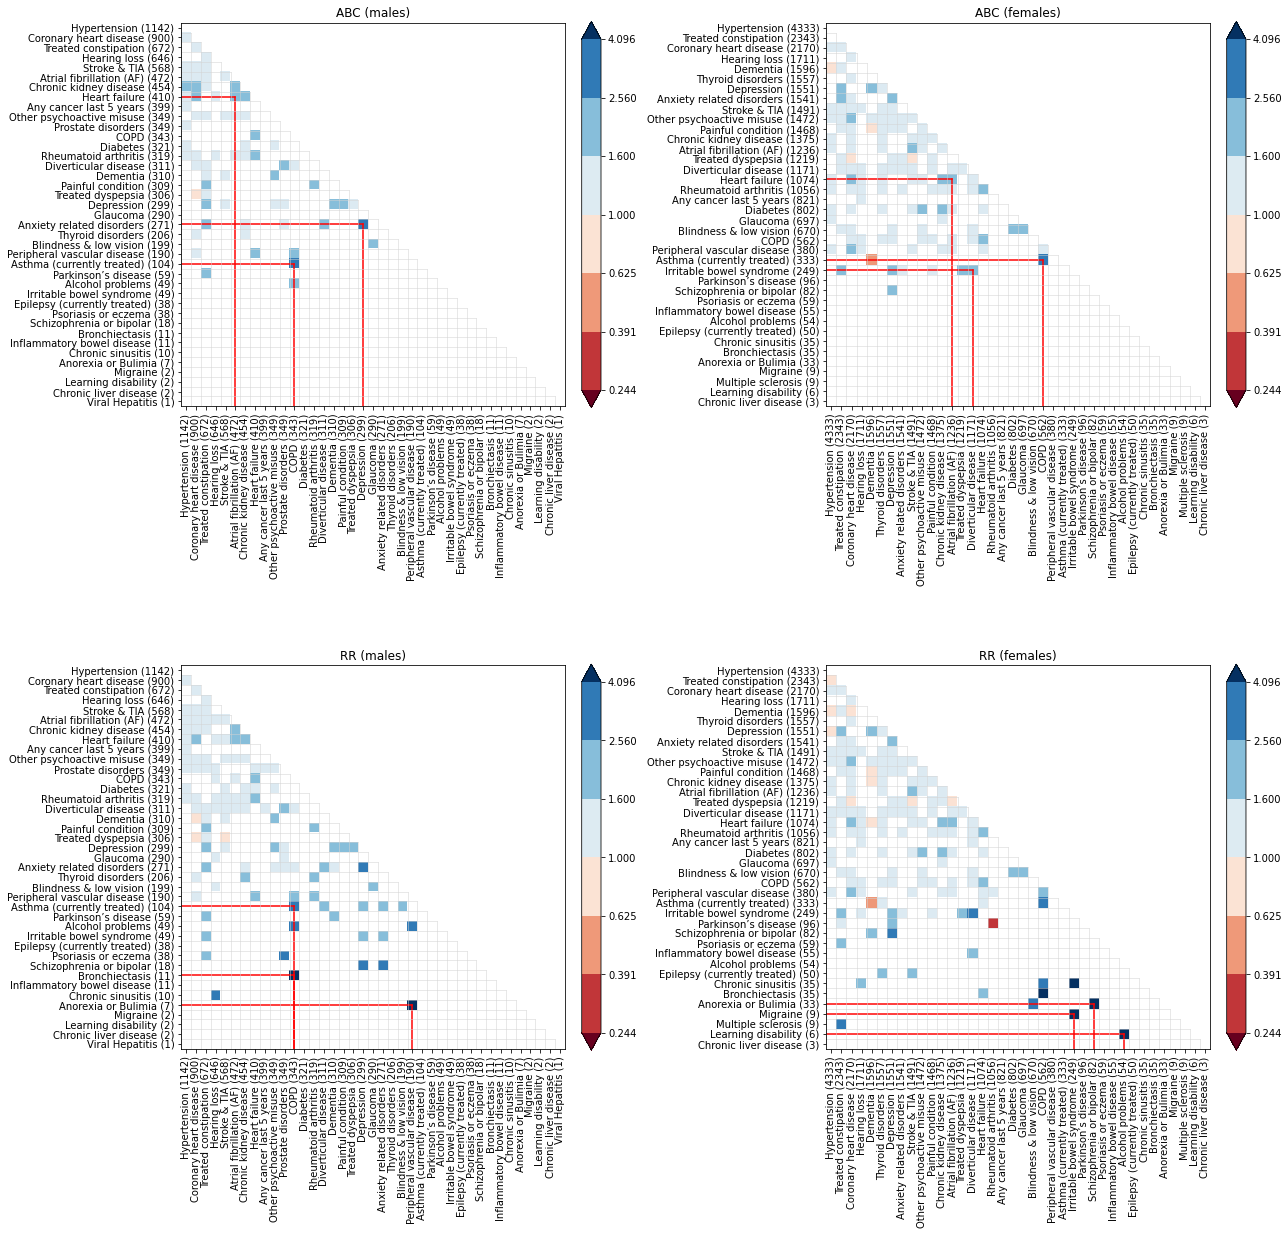

In [18]:
max_val = 5  # None # max([models[index].RRs.max() for index in indices])
# heatmap_kwargs = {}
# heatmap_kwargs = {"norm_kwargs": {"extend":"both"}, "max_val": max_val, "cbar_ticklabels": ["0.3", "0.5", "0.7", "1", "2", "3", "4", "5"]}#[""]*8 + [f"${el}\cdot 10^0" for el in (1, 2, 3, 4, 5)], }
heatmap_kwargs = {"norm_kwargs": {"extend":"both"}, "max_val": max_val, "boundaries": np.power(1.6, np.arange(-3, 4))}

fig, axes = plt.subplots(2, 2, figsize=(18,)*2)
models[ind_dict["male"]].plot_heatmap("ABC", title="ABC (males)", ax=axes[0, 0], **heatmap_kwargs)
models[ind_dict["female"]].plot_heatmap("ABC", title="ABC (females)", ax=axes[0, 1], **heatmap_kwargs)
models[ind_dict["male"]].plot_heatmap("RR", title="RR (males)", ax=axes[1, 0], **heatmap_kwargs)
models[ind_dict["female"]].plot_heatmap("RR", title="RR (females)", ax=axes[1, 1], **heatmap_kwargs)
fig.tight_layout()

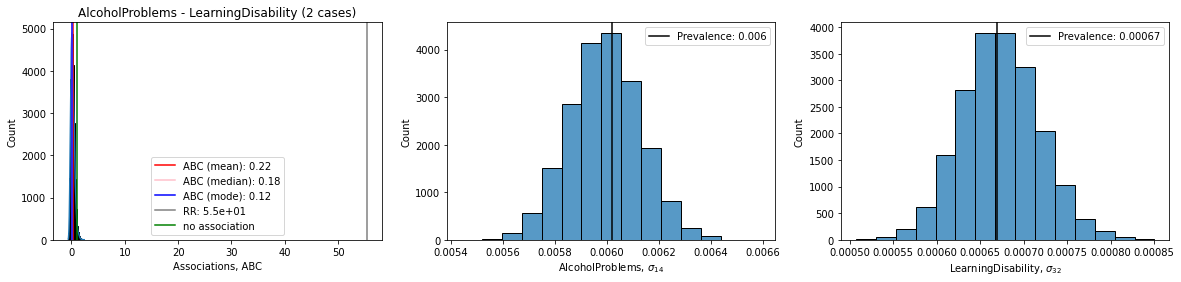

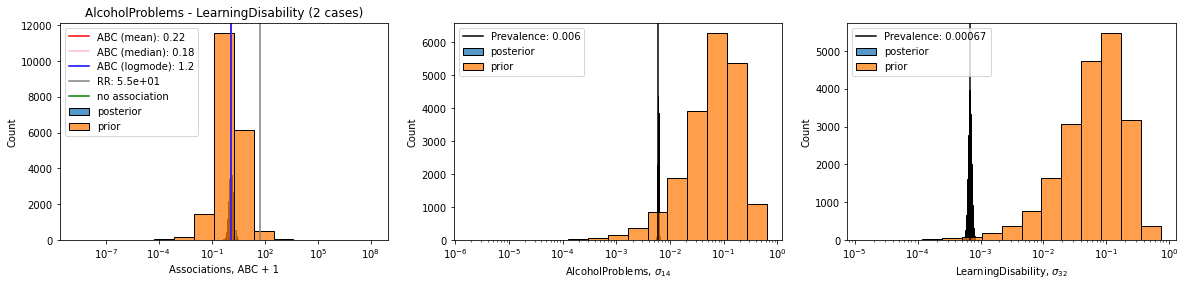

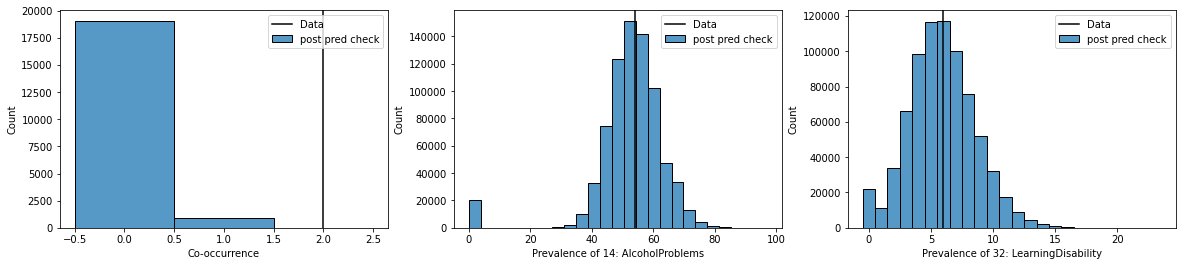

In [19]:
models[19].diagnose_condition_pair("AlcoholProblems","LearningDisability")

In [20]:
tops_male, tops_female = [models[index].summarise_relevant_associations() for index in ind_dict.values()]

In [23]:
tops_male[0]

a_f_sig_CI  \
Depression - Anxiety & other neurotic, stress r...  3.35 (2.57 - 4.42)   
Asthma (currently treated) - Chronic obstructiv...  3.15 (2.12 - 4.65)   
Atrial fibrillation (AF) - Heart failure            2.27 (1.83 - 2.82)   
Chronic kidney disease (CKD) - Heart failure        2.16 (1.77 - 2.75)   
Depression - Dementia                               2.15 (1.61 - 2.95)   
Coronary heart disease (CHD) - Heart failure        2.09 (1.76 - 2.44)   
Anxiety & other neurotic, stress related & soma...  2.07 (1.63 - 2.57)   
Chronic obstructive pulmonary disease (COPD) - ...  2.04 (1.13 - 3.63)   
Depression - Painful condition                      2.02 (1.44 - 2.75)   
Depression - Treated constipation                   2.01 (1.59 - 2.47)   

                                                           RR_f_sig_CI  
Depression - Anxiety & other neurotic, stress r...  3.64 (3.55 - 3.73)  
Asthma (currently treated) - Chronic obstructiv...   4.0 (3.79 - 4.23)  
Atrial fibrillation (AF) - Heart failure             2.26 (2.22 - 2.3)  
Chronic kidney disease (CKD) - Heart failure         2.2 (2.16 - 2.24)  
Depression - Dementia                               2.36 (2.28 - 2.44)  
Coronary heart disease (CHD) - Heart failure         2.0 (1.98 - 2.02)  
Anxiety & other neurotic, stress related & soma...  2.07 (2.03 - 2.11)  
Chronic obstructive pulmonary disease (COPD) - ...  3.25 (2.82 - 3.75)  
Depression - Painful condition                      2.14 (2.06 - 2.22)  
Depression - Treated constipation                   1.98 (1.94 - 2.02)

In [24]:
tops_female[0]

a_f_sig_CI  \
Asthma (currently treated) - Chronic obstructiv...  3.21 (2.41 - 4.33)   
Irritable bowel syndrome (IBS) - Diverticular d...  2.48 (1.89 - 3.27)   
Atrial fibrillation (AF) - Heart failure            2.45 (2.07 - 2.73)   
Depression - Schizophrenia (and related non-org...  2.41 (1.61 - 3.55)   
Coronary heart disease (CHD) - Heart failure        2.28 (2.05 - 2.54)   
Depression - Anxiety & other neurotic, stress r...   2.21 (2.0 - 2.47)   
Glaucoma - Blindness & low vision                   2.14 (1.72 - 2.74)   
Diabetes - Chronic kidney disease (CKD)             1.97 (1.66 - 2.32)   
Chronic kidney disease (CKD) - Heart failure        1.87 (1.61 - 2.16)   
Chronic obstructive pulmonary disease (COPD) - ...  1.87 (1.48 - 2.32)   

                                                           RR_f_sig_CI  
Asthma (currently treated) - Chronic obstructiv...  3.83 (3.71 - 3.96)  
Irritable bowel syndrome (IBS) - Diverticular d...  2.74 (2.66 - 2.82)  
Atrial fibrillation (AF) - Heart failure             2.32 (2.3 - 2.33)  
Depression - Schizophrenia (and related non-org...   3.1 (2.93 - 3.29)  
Coronary heart disease (CHD) - Heart failure        2.17 (2.17 - 2.18)  
Depression - Anxiety & other neurotic, stress r...  2.14 (2.13 - 2.14)  
Glaucoma - Blindness & low vision                    2.3 (2.26 - 2.35)  
Diabetes - Chronic kidney disease (CKD)             1.94 (1.92 - 1.96)  
Chronic kidney disease (CKD) - Heart failure         1.8 (1.79 - 1.82)  
Chronic obstructive pulmonary disease (COPD) - ...  1.89 (1.85 - 1.93)

In [25]:
tops_male[2]

RR_f_sig_CI  \
Peripheral vascular disease - Anorexia or Bulimia    6.85 (2.9 - 16.2)   
Chronic obstructive pulmonary disease (COPD) - ...   5.64 (3.9 - 8.14)   
Asthma (currently treated) - Chronic obstructiv...   4.0 (3.79 - 4.23)   
Depression - Schizophrenia (and related non-org...  3.95 (2.74 - 5.71)   
Anxiety & other neurotic, stress related & soma...  3.74 (2.43 - 5.74)   
Depression - Anxiety & other neurotic, stress r...  3.64 (3.55 - 3.73)   
Chronic obstructive pulmonary disease (COPD) - ...  3.25 (2.82 - 3.75)   
Hearing loss - Chronic sinusitis                    2.82 (1.84 - 4.33)   
Prostate disorders - Psoriasis or eczema            2.75 (2.22 - 3.41)   
Alcohol problems - Peripheral vascular disease       2.61 (1.89 - 3.6)   

                                                            a_f_sig_CI  
Peripheral vascular disease - Anorexia or Bulimia                   NS  
Chronic obstructive pulmonary disease (COPD) - ...                  NS  
Asthma (currently treated) - Chronic obstructiv...  3.15 (2.12 - 4.65)  
Depression - Schizophrenia (and related non-org...                  NS  
Anxiety & other neurotic, stress related & soma...                  NS  
Depression - Anxiety & other neurotic, stress r...  3.35 (2.57 - 4.42)  
Chronic obstructive pulmonary disease (COPD) - ...  2.04 (1.13 - 3.63)  
Hearing loss - Chronic sinusitis                                    NS  
Prostate disorders - Psoriasis or eczema                            NS  
Alcohol problems - Peripheral vascular disease                      NS

In [23]:
print(tops_male[2].to_latex())

\begin{tabular}{lll}
\toprule
{} &         RR\_f\_sig\_CI &          a\_f\_sig\_CI \\
\midrule
Peripheral vascular disease - Anorexia or Bulimia  &   6.85 (2.9 - 16.2) &                  NS \\
Chronic obstructive pulmonary disease (COPD) - ... &   5.64 (3.9 - 8.14) &                  NS \\
Asthma (currently treated) - Chronic obstructiv... &   4.0 (3.79 - 4.23) &  3.15 (2.12 - 4.65) \\
Depression - Schizophrenia (and related non-org... &  3.95 (2.74 - 5.71) &                  NS \\
Anxiety \& other neurotic, stress related \& soma... &  3.74 (2.43 - 5.74) &                  NS \\
Depression - Anxiety \& other neurotic, stress r... &  3.64 (3.55 - 3.73) &  3.35 (2.57 - 4.42) \\
Chronic obstructive pulmonary disease (COPD) - ... &  3.25 (2.82 - 3.75) &  2.04 (1.13 - 3.63) \\
Hearing loss - Chronic sinusitis                   &  2.82 (1.84 - 4.33) &                  NS \\
Prostate disorders - Psoriasis or eczema           &  2.75 (2.22 - 3.41) &                  NS \\
Alcohol problems - P

/tmp/ipykernel_3423776/2585172274.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tops_male[2].to_latex())


In [26]:
tops_female[2]

RR_f_sig_CI  \
Alcohol problems - Learning disability              55.4 (15.2 - 2.02e+02)   
Irritable bowel syndrome (IBS) - Migraine               12.0 (5.08 - 28.4)   
Schizophrenia (and related non-organic psychosi...      9.94 (4.21 - 23.5)   
Irritable bowel syndrome (IBS) - Chronic sinusitis      5.15 (3.07 - 8.61)   
Chronic obstructive pulmonary disease (COPD) - ...       4.56 (3.53 - 5.9)   
Asthma (currently treated) - Chronic obstructiv...      3.83 (3.71 - 3.96)   
Chronic obstructive pulmonary disease (COPD) - ...      3.65 (2.64 - 5.03)   
Treated constipation - Multiple sclerosis                3.4 (2.47 - 4.69)   
Depression - Schizophrenia (and related non-org...       3.1 (2.93 - 3.29)   
Blindness & low vision - Anorexia or Bulimia             2.84 (1.97 - 4.1)   

                                                            a_f_sig_CI  
Alcohol problems - Learning disability                              NS  
Irritable bowel syndrome (IBS) - Migraine                           NS  
Schizophrenia (and related non-organic psychosi...                  NS  
Irritable bowel syndrome (IBS) - Chronic sinusitis                  NS  
Chronic obstructive pulmonary disease (COPD) - ...                  NS  
Asthma (currently treated) - Chronic obstructiv...  3.21 (2.41 - 4.33)  
Chronic obstructive pulmonary disease (COPD) - ...                  NS  
Treated constipation - Multiple sclerosis                           NS  
Depression - Schizophrenia (and related non-org...  2.41 (1.61 - 3.55)  
Blindness & low vision - Anorexia or Bulimia                        NS

In [24]:
print(tops_female[2].to_latex())

\begin{tabular}{lll}
\toprule
{} &             RR\_f\_sig\_CI &          a\_f\_sig\_CI \\
\midrule
Alcohol problems - Learning disability             &  55.4 (15.2 - 2.02e+02) &                  NS \\
Irritable bowel syndrome (IBS) - Migraine          &      12.0 (5.08 - 28.4) &                  NS \\
Schizophrenia (and related non-organic psychosi... &      9.94 (4.21 - 23.5) &                  NS \\
Irritable bowel syndrome (IBS) - Chronic sinusitis &      5.15 (3.07 - 8.61) &                  NS \\
Chronic obstructive pulmonary disease (COPD) - ... &       4.56 (3.53 - 5.9) &                  NS \\
Asthma (currently treated) - Chronic obstructiv... &      3.83 (3.71 - 3.96) &  3.21 (2.41 - 4.33) \\
Chronic obstructive pulmonary disease (COPD) - ... &      3.65 (2.64 - 5.03) &                  NS \\
Treated constipation - Multiple sclerosis          &       3.4 (2.47 - 4.69) &                  NS \\
Depression - Schizophrenia (and related non-org... &       3.1 (2.93 - 3.29) &  2.41 

/tmp/ipykernel_3423776/142246805.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tops_female[2].to_latex())


In [27]:
tops_male[3]

RR_f_sig_CI  \
Coronary heart disease (CHD) - Treated dyspepsia    0.629 (0.602 - 0.658)   
Treated dyspepsia - Stroke & transient ischaemi...  0.647 (0.604 - 0.693)   
Coronary heart disease (CHD) - Dementia             0.784 (0.757 - 0.812)   

                                                               a_f_sig_CI  
Coronary heart disease (CHD) - Treated dyspepsia    0.673 (0.478 - 0.916)  
Treated dyspepsia - Stroke & transient ischaemi...                     NS  
Coronary heart disease (CHD) - Dementia                                NS

In [25]:
print(tops_male[3].to_latex())

\begin{tabular}{lll}
\toprule
{} &            RR\_f\_sig\_CI &             a\_f\_sig\_CI \\
\midrule
Coronary heart disease (CHD) - Treated dyspepsia   &  0.629 (0.602 - 0.658) &  0.673 (0.478 - 0.916) \\
Treated dyspepsia - Stroke \& transient ischaemi... &  0.647 (0.604 - 0.693) &                     NS \\
Coronary heart disease (CHD) - Dementia            &  0.784 (0.757 - 0.812) &                     NS \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3423776/352419149.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tops_male[3].to_latex())


In [28]:
tops_female[3]

RR_f_sig_CI  \
Rheumatoid arthritis, other inflammatory polyar...  0.265 (0.113 - 0.626)   
Asthma (currently treated) - Dementia               0.456 (0.414 - 0.501)   
Painful condition - Dementia                        0.662 (0.653 - 0.672)   
Treated dyspepsia - Stroke & transient ischaemi...  0.686 (0.674 - 0.699)   
Coronary heart disease (CHD) - Treated dyspepsia      0.8 (0.792 - 0.809)   
Treated dyspepsia - Atrial fibrillation (AF)        0.804 (0.789 - 0.819)   
Hypertension - Dementia                              0.807 (0.804 - 0.81)   
Heart failure - Dementia                             0.827 (0.814 - 0.84)   
Chronic kidney disease (CKD) - Dementia             0.834 (0.824 - 0.844)   
Coronary heart disease (CHD) - Dementia             0.868 (0.861 - 0.874)   
Hypertension - Depression                           0.901 (0.898 - 0.904)   
Hypertension - Treated constipation                 0.943 (0.941 - 0.945)   

                                                               a_f_sig_CI  
Rheumatoid arthritis, other inflammatory polyar...                     NS  
Asthma (currently treated) - Dementia               0.556 (0.382 - 0.835)  
Painful condition - Dementia                         0.683 (0.559 - 0.82)  
Treated dyspepsia - Stroke & transient ischaemi...  0.723 (0.574 - 0.883)  
Coronary heart disease (CHD) - Treated dyspepsia    0.821 (0.695 - 0.973)  
Treated dyspepsia - Atrial fibrillation (AF)                           NS  
Hypertension - Dementia                             0.795 (0.714 - 0.893)  
Heart failure - Dementia                                               NS  
Chronic kidney disease (CKD) - Dementia                                NS  
Coronary heart disease (CHD) - Dementia                                NS  
Hypertension - Depression                                              NS  
Hypertension - Treated constipation                                    NS

In [26]:
print(tops_female[3].to_latex())

\begin{tabular}{lll}
\toprule
{} &            RR\_f\_sig\_CI &             a\_f\_sig\_CI \\
\midrule
Rheumatoid arthritis, other inflammatory polyar... &  0.265 (0.113 - 0.626) &                     NS \\
Asthma (currently treated) - Dementia              &  0.456 (0.414 - 0.501) &  0.556 (0.382 - 0.835) \\
Painful condition - Dementia                       &  0.662 (0.653 - 0.672) &   0.683 (0.559 - 0.82) \\
Treated dyspepsia - Stroke \& transient ischaemi... &  0.686 (0.674 - 0.699) &  0.723 (0.574 - 0.883) \\
Coronary heart disease (CHD) - Treated dyspepsia   &    0.8 (0.792 - 0.809) &  0.821 (0.695 - 0.973) \\
Treated dyspepsia - Atrial fibrillation (AF)       &  0.804 (0.789 - 0.819) &                     NS \\
Hypertension - Dementia                            &   0.807 (0.804 - 0.81) &  0.795 (0.714 - 0.893) \\
Heart failure - Dementia                           &   0.827 (0.814 - 0.84) &                     NS \\
Chronic kidney disease (CKD) - Dementia            &  0.834 (0.824

/tmp/ipykernel_3423776/1960424146.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tops_female[3].to_latex())


68/741 data points
0/741 data points
45/741 data points
628/741 data points


/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);


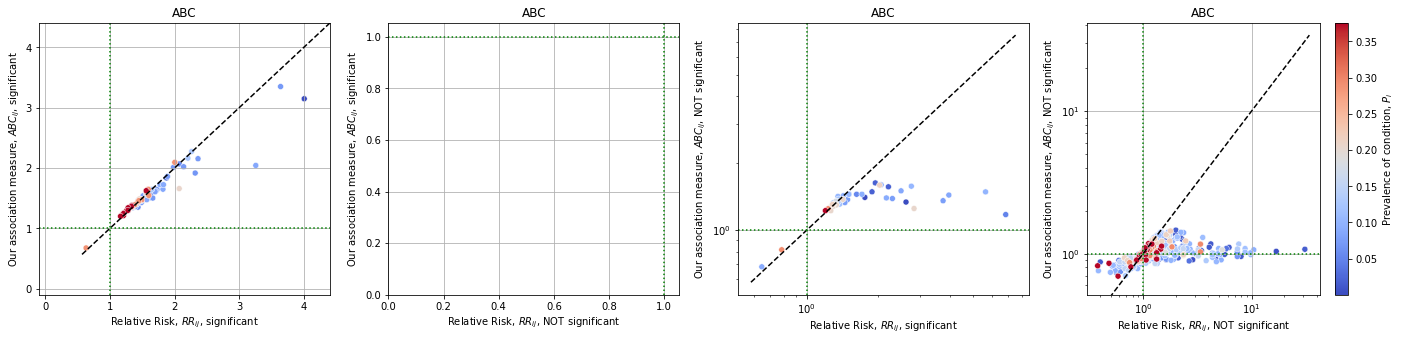

In [29]:
index = 18
dat = dats["male"]

fig, axes = plt.subplots(1,4, figsize=(24,5)) #, sharex=True) #, sharey=True)
plot_ABC_vs_RR(axes[0], dat, log=False)  # xlim=[0, 5.1], ylim=[0, 4])
plot_ABC_vs_RR(axes[1], dat, RR_conf=False, log=False, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[2], dat, a_conf=False, log=True, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[3], dat, RR_conf=False, a_conf=False, colorbar=True, log=True, xlim=0, ylim=0, fig=fig)

124/703 data points
0/703 data points
31/703 data points
548/703 data points


/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_3739438/2830569097.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);


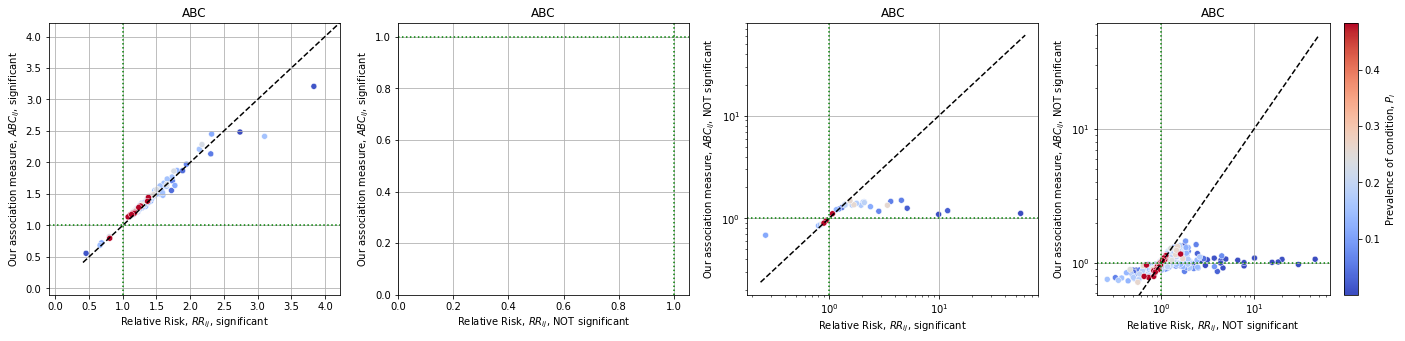

In [30]:
index = 19
dat = dats["female"]

fig, axes = plt.subplots(1,4, figsize=(24,5)) #, sharex=True) #, sharey=True)
plot_ABC_vs_RR(axes[0], dat, log=False)  # xlim=[0, 5.1], ylim=[0, 4])
plot_ABC_vs_RR(axes[1], dat, RR_conf=False, log=False, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[2], dat, a_conf=False, log=True, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[3], dat, RR_conf=False, a_conf=False, colorbar=True, log=True, xlim=0, ylim=0, fig=fig)

### Network visualisation and analysis

In [ ]:
def beautify_node_labels(a_list_of_names, sep="\n"):
    beautify_dict = {name: sep.join(re.findall('[A-Z]+[a-z]*|\d+', name)) for name in a_list_of_names}
    beautify_dict.update({"AnyCancer_Last5Yrs": "Any Cancer\nLast 5 Years",
                         "ChronicLiverDisease": "Chronic Liver\nDisease",
                         "PeripheralVascularDisease": "Peripheral Vascular\nDisease",
                         "RheumatoidArthritisEtc": "Rheumaotid\nArthritis",
                         "IrritableBowelSyndrome": "IBS", })
    return [beautify_dict[name] for name in a_list_of_names]

def plot_group_network(group, var, title=None, **kwargs):
    assert group in ("male", "female")
    model = models[ind_dict[group]]
    dat = dats[group]
    title = f"{var} {group}" if title is None else title

    return plot_network(model, dat, var=var, beautify_list_funct=beautify_node_labels, **kwargs)

In [484]:
plot_kwargs = {"communities": False, "figsize":(600, 550), "interactive":True}

male_G_ABC, ax1 = plot_group_network("male", var="ABC", **plot_kwargs)
female_G_ABC, ax2 = plot_group_network("female", "ABC", **plot_kwargs)
male_G_RR, ax3 = plot_group_network("male", var="RR", title="RR males", **plot_kwargs)
female_G_RR, ax4 = plot_group_network("female", "RR", title="RR females", **plot_kwargs)

gr = grid([[ax1, ax2], [ax3, ax4]])
show(gr)

Original size: 68 edges, 27 nodes, filtered size: 68 edges, 27 nodes.
Original size: 125 edges, 26 nodes, filtered size: 125 edges, 26 nodes.
Original size: 113 edges, 33 nodes, filtered size: 113 edges, 33 nodes.
Original size: 155 edges, 37 nodes, filtered size: 155 edges, 37 nodes.


In [485]:
plot_kwargs = {"communities": False, "figsize":(600, 550), "layout":nx.circular_layout}

male_G_ABC, ax1 = plot_group_network("male", var="ABC", **plot_kwargs)
female_G_ABC, ax2 = plot_group_network("female", "ABC", **plot_kwargs)
male_G_RR, ax3 = plot_group_network("male", var="RR", title="RR males", **plot_kwargs)
female_G_RR, ax4 = plot_group_network("female", "RR", title="RR females", **plot_kwargs)

gr = grid([[ax1, ax2], [ax3, ax4]])
show(gr)

Original size: 68 edges, 27 nodes, filtered size: 68 edges, 27 nodes.
Original size: 125 edges, 26 nodes, filtered size: 125 edges, 26 nodes.
Original size: 113 edges, 33 nodes, filtered size: 113 edges, 33 nodes.
Original size: 155 edges, 37 nodes, filtered size: 155 edges, 37 nodes.


In [483]:
plot_kwargs = {"communities": True, "layout":nx.circular_layout, "figsize":(600, 550), "build_kwargs":{"cutoff":0.25}}

male_G_ABC, ax1 = plot_group_network("male", var="ABC", **plot_kwargs)
female_G_ABC, ax2 = plot_group_network("female", "ABC", **plot_kwargs)
male_G_RR, ax3 = plot_group_network("male", var="RR", title="RR males", **plot_kwargs)
female_G_RR, ax4 = plot_group_network("female", "RR", title="RR females", **plot_kwargs)

gr = grid([[ax1, ax2], [ax3, ax4]])
show(gr)

Original size: 68 edges, 27 nodes, filtered size: 62 edges, 26 nodes.
Original size: 125 edges, 26 nodes, filtered size: 85 edges, 26 nodes.
Original size: 113 edges, 33 nodes, filtered size: 96 edges, 33 nodes.
Original size: 155 edges, 37 nodes, filtered size: 101 edges, 37 nodes.


In [317]:
plot_kwargs = {"communities": True, "figsize":(600, 550), "interactive":True, "cutoff":0, "prev_size":True, "community_weight":True,
               "layout": nx.kamada_kawai_layout, "span":9}

male_G_ABC, ax1, comm_male_ABC = plot_group_network("male", var="ABC", **plot_kwargs)
female_G_ABC, ax2, comm_female_ABC = plot_group_network("female", "ABC", **plot_kwargs)
male_G_RR, ax3, comm_male_RR = plot_group_network("male", var="RR", title="RR males", **plot_kwargs)
female_G_RR, ax4, comm_female_RR = plot_group_network("female", "RR", title="RR females", **plot_kwargs)

gr = grid([[ax1, ax2], [ax3, ax4]])
show(gr)

Original size: 68 edges, 27 nodes, filtered size: 68 edges, 27 nodes.
Modularity: 0.26330017301038056 coverage-performance (0.7352941176470589, 0.7549857549857549)
Original size: 124 edges, 26 nodes, filtered size: 124 edges, 26 nodes.
Modularity: 0.20213319458896978 coverage-performance (0.6129032258064516, 0.7846153846153846)
Original size: 113 edges, 33 nodes, filtered size: 113 edges, 33 nodes.
Modularity: 0.2801707259769755 coverage-performance (0.5752212389380531, 0.7973484848484849)
Original size: 155 edges, 37 nodes, filtered size: 155 edges, 37 nodes.
Modularity: 0.19843912591050986 coverage-performance (0.6129032258064516, 0.7447447447447447)


In [320]:
comm_male_ABC, comm_male_RR

([['Hypertension',
   'Coronary heart disease',
   'Diabetes',
   'Thyroid disorders',
   'Rheumatoid arthritis',
   'Hearing loss',
   'Any cancer last 5 years',
   'Other psychoactive misuse',
   'Stroke & TIA',
   'Chronic kidney disease',
   'Atrial fibrillation (AF)',
   'Peripheral vascular disease',
   'Heart failure'],
  ['Depression',
   'Painful condition',
   'Parkinson’s disease',
   'Treated dyspepsia',
   'Anxiety related disorders',
   'Treated constipation',
   'Diverticular disease',
   'Prostate disorders',
   'Dementia'],
  ['COPD', 'Asthma (currently treated)', 'Alcohol problems'],
  ['Glaucoma', 'Blindness & low vision']],
 [['Depression',
   'Painful condition',
   'Parkinson’s disease',
   'Treated dyspepsia',
   'Anxiety related disorders',
   'Irritable bowel syndrome',
   'Other psychoactive misuse',
   'Treated constipation',
   'Dementia',
   'Schizophrenia or bipolar'],
  ['Hypertension',
   'Coronary heart disease',
   'Diabetes',
   'Thyroid disorders',
 

In [321]:
comm_female_ABC, comm_female_RR

([['Hypertension',
   'Coronary heart disease',
   'Diabetes',
   'Thyroid disorders',
   'Rheumatoid arthritis',
   'Other psychoactive misuse',
   'Stroke & TIA',
   'Chronic kidney disease',
   'Atrial fibrillation (AF)',
   'Peripheral vascular disease',
   'Heart failure'],
  ['Depression',
   'Painful condition',
   'Treated dyspepsia',
   'Anxiety related disorders',
   'Irritable bowel syndrome',
   'Treated constipation',
   'Diverticular disease',
   'Dementia',
   'Schizophrenia or bipolar'],
  ['Hearing loss',
   'COPD',
   'Asthma (currently treated)',
   'Any cancer last 5 years'],
  ['Glaucoma', 'Blindness & low vision']],
 [['Hypertension',
   'Asthma (currently treated)',
   'Coronary heart disease',
   'Bronchiectasis',
   'Diabetes',
   'Thyroid disorders',
   'Rheumatoid arthritis',
   'COPD',
   'Other psychoactive misuse',
   'Stroke & TIA',
   'Chronic kidney disease',
   'Atrial fibrillation (AF)',
   'Peripheral vascular disease',
   'Heart failure',
   'Epilep

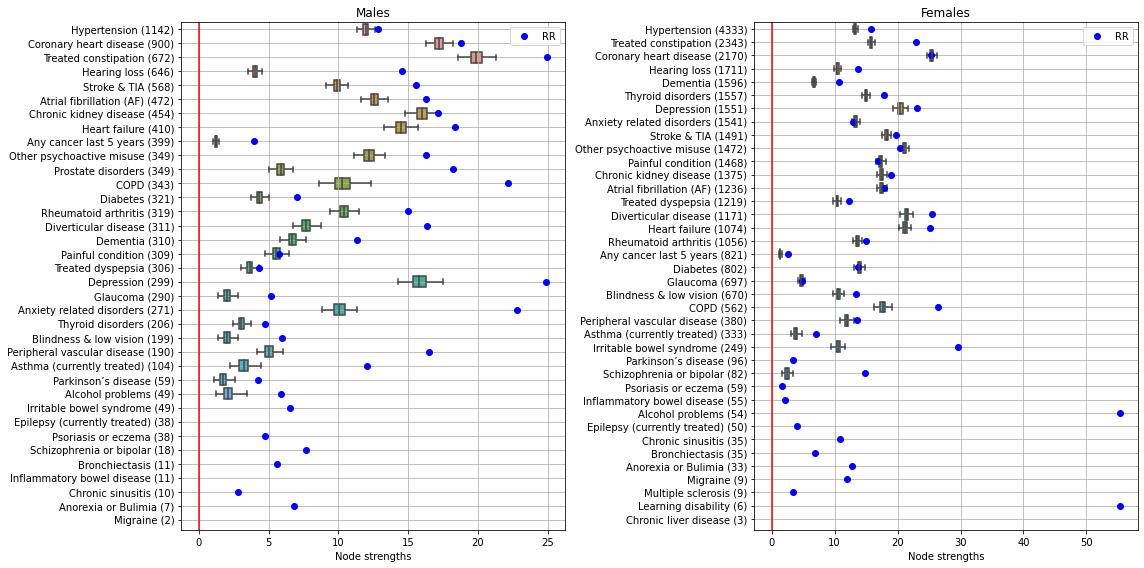

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
models[ind_dict["male"]].plot_node_degrees(axes[0], pval, title="Males");
models[ind_dict["female"]].plot_node_degrees(axes[1], pval, title="Females");
fig.tight_layout();

In [38]:
(268 - 193), (268 - 193) / 268

(75, 0.2798507462686567)

In [37]:
(113 + 155), 193 / (113 + 155)

(268, 0.7201492537313433)

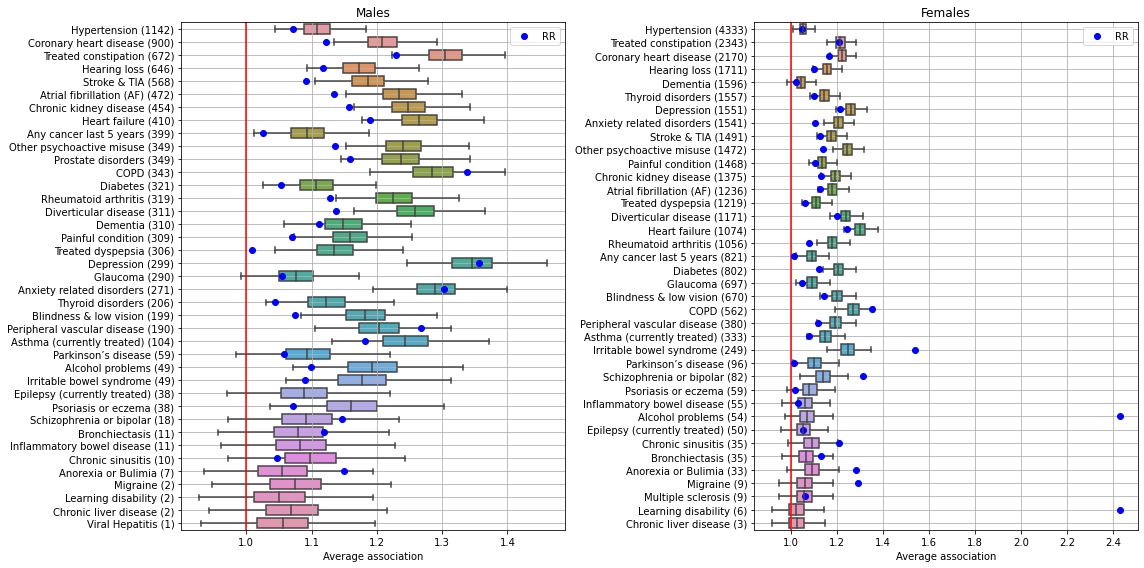

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
models[ind_dict["male"]].plot_node_degrees(axes[0], pval, title="Males", catch_all=True);
deg, _, _, _ = models[ind_dict["female"]].plot_node_degrees(axes[1], pval, title="Females", catch_all=True);
fig.tight_layout();

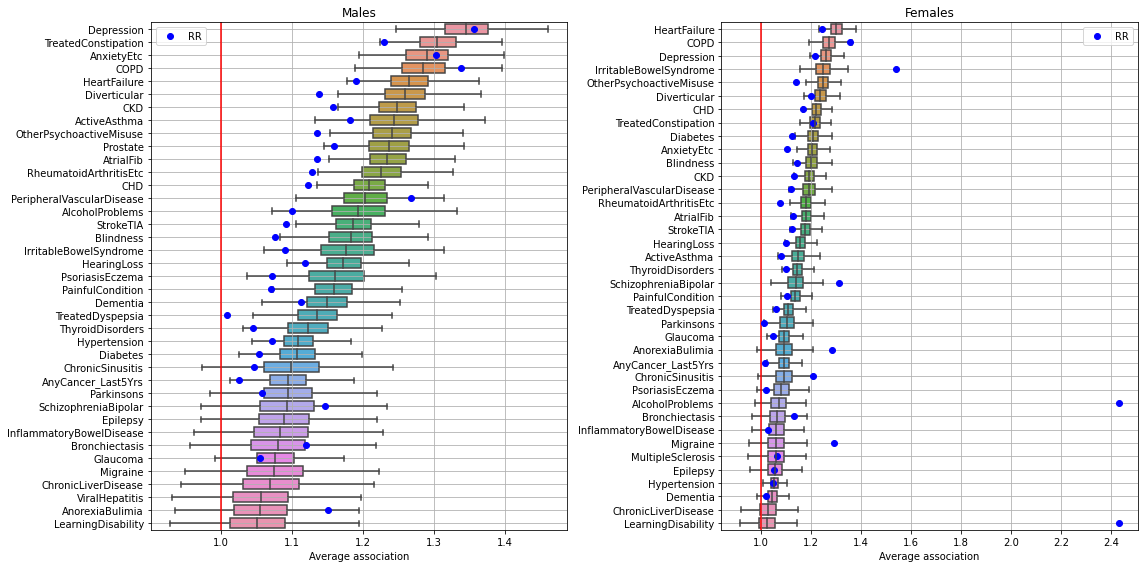

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_kwargs = {"pvalue":pval, "catch_all":True, "sort_by":"degree"}
models[ind_dict["male"]].plot_node_degrees(axes[0], title="Males", **plot_kwargs);
deg, _, _, _ = models[ind_dict["female"]].plot_node_degrees(axes[1], title="Females", **plot_kwargs);
fig.tight_layout();

In [45]:
degs = {key:val.mean() for key, val in deg.items()}
{list(degs.keys())[el]: degs[list(degs.keys())[el]] for el in np.argsort(list(degs.values()))[::-1]}

{'HeartFailure': 1.3015103256495602,
 'COPD': 1.2723492527584135,
 'Depression': 1.2603862148640916,
 'IrritableBowelSyndrome': 1.2474570064261006,
 'OtherPsychoactiveMisuse': 1.2465996070871876,
 'Diverticular': 1.2380672575942524,
 'CHD': 1.2216387127068349,
 'TreatedConstipation': 1.215832521093248,
 'Diabetes': 1.207030525671984,
 'AnxietyEtc': 1.2060522102314664,
 'Blindness': 1.2011227034820735,
 'CKD': 1.1935474946502909,
 'PeripheralVascularDisease': 1.1930620344252172,
 'RheumatoidArthritisEtc': 1.1814953743932828,
 'AtrialFib': 1.1811786937325883,
 'StrokeTIA': 1.1767634894462935,
 'HearingLoss': 1.1572527206744976,
 'ActiveAsthma': 1.1492330756229523,
 'ThyroidDisorders': 1.1450537481256822,
 'SchizophreniaBipolar': 1.1395770405678658,
 'PainfulCondition': 1.1373507570411086,
 'TreatedDyspepsia': 1.1092977638313757,
 'Parkinsons': 1.103862154659759,
 'Glaucoma': 1.0925570985017565,
 'AnorexiaBulimia': 1.0918989267238282,
 'ChronicSinusitis': 1.0911271748257731,
 'AnyCancer_L

In [475]:
deg["LearningDisability"].mean(), np.percentile(deg["LearningDisability"], 1), np.percentile(deg["LearningDisability"], 99) 

(0.9104321244678187, -3.095307565873874, 5.074153998520767)

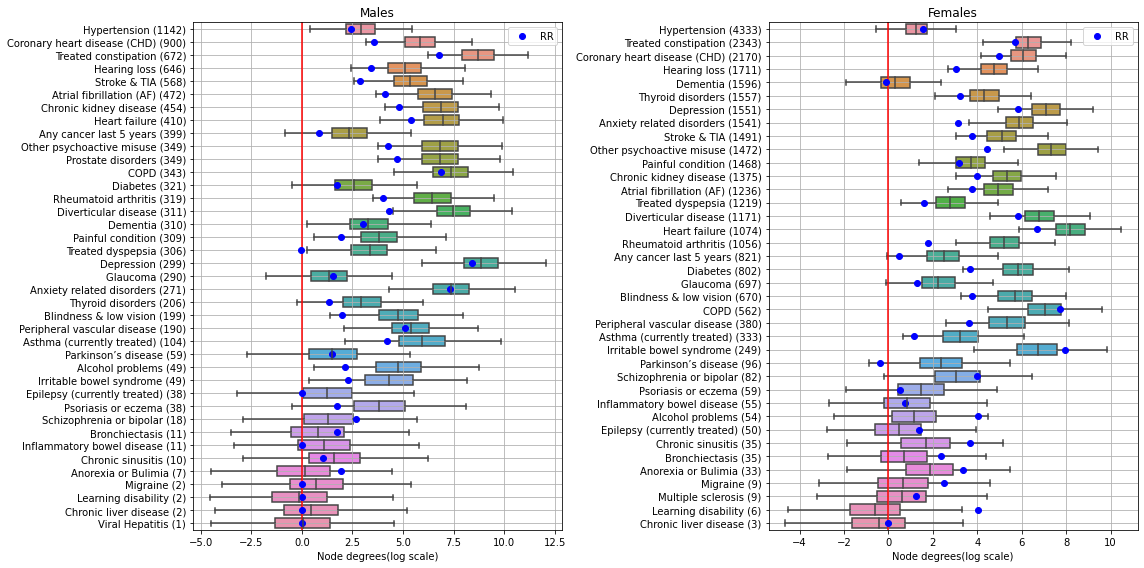

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
models[ind_dict["male"]].plot_node_degrees(axes[0], pval, title="Males", catch_all=True, log=True);
models[ind_dict["female"]].plot_node_degrees(axes[1], pval, title="Females", catch_all=True, log=True);
fig.tight_layout();

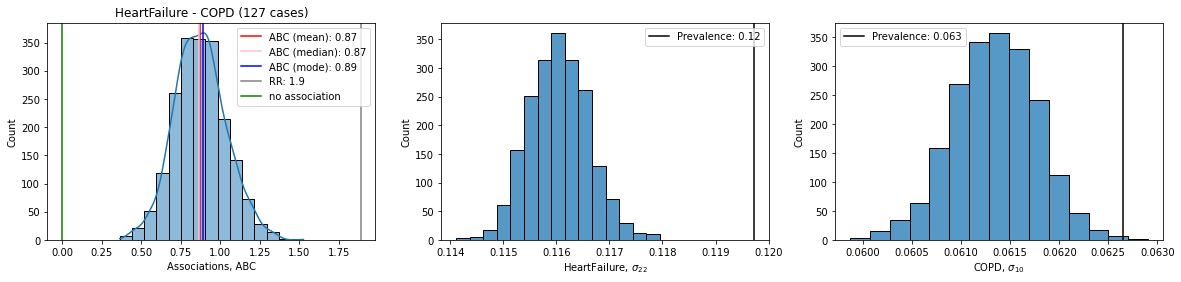

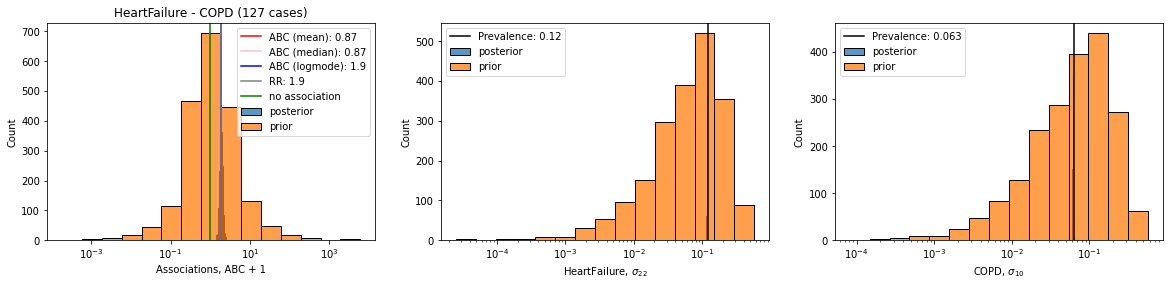

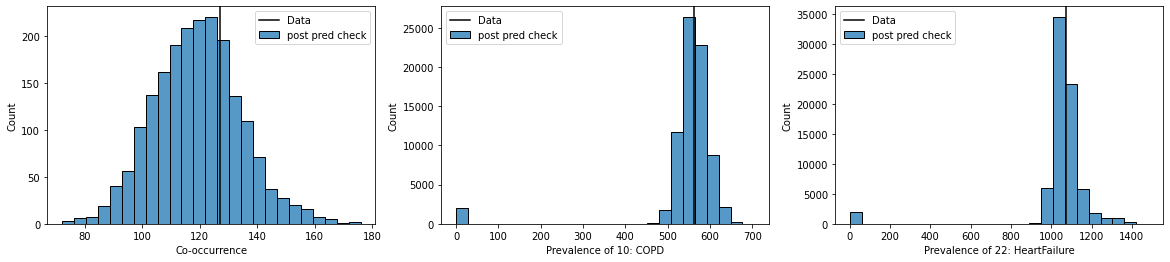

In [74]:
models[19].diagnose_condition_pair("HeartFailure", "COPD")

In [124]:
[models[index]._fit["std_lognormal_prior"].mean() for index in indices]

[0.3291728884525761, 0.28561721335289875]

In [134]:
(dfs[18]["LearningDisability"] & dfs[18]["AlcoholProblems"]).sum()

0

### Comparisons between sex groups

For performing comparisons between sex, we will first build a single dataframe that unifies results from both subgroups and compute their differeces.

In [31]:
def get_val(group, col, LTC1, LTC2):
    dat = dats[group]
    if ((row_mask := ((dat["namei"] == LTC1) & (dat["namej"] == LTC2))).sum() > 0):
        return dat[row_mask][col].values[0]
    elif ((row_mask := ((dat["namei"] == LTC2) & (dat["namej"] == LTC1))).sum() > 0):
        return dat[row_mask][col]
    else:
        return None if var not in ("a_sig", "fisher_sig") else False

    
dat_comp = []
for i, j in it.combinations(range(N), 2):
    row = {"i": i, "j": j, "namei": names[i], "namej": names[j], "names": f"{names[i]}-{names[j]}",
           "conf_ABC_diff": np.NaN, "conf_RR_diff": np.NaN,}
    
    for group in ("male", "female"):
        for var in ("ABC", "a_sig", "RR", "fisher_sig", "Xi", "Xj", "Xij", "a_f_sig_CI", "RR_f_sig_CI"):
            row[f"{var}_{group}"] = get_val(group, var, names[i], names[j])
            
    dat_comp.append(row)

dat_comp = pd.DataFrame(dat_comp)
dat_comp["diff_ABC"] = dat_comp["ABC_male"] - dat_comp["ABC_female"]
dat_comp["diff_RR"] = dat_comp["RR_male"] - dat_comp["RR_female"]
dat_comp["diff_ABC_abs"] = dat_comp["diff_ABC"].abs()
dat_comp["diff_RR_abs"] = dat_comp["diff_RR"].abs()
dat_comp = dat_comp.set_index(dat_comp["names"])

We then need to compute the probabilities of the distributions being different.

In [32]:
def compute_overlap_between_normals(m01,m02,std01,std02):
    # https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy
    # Alternatively: https://rpsychologist.com/calculating-the-overlap-of-two-normal-distributions-using-monte-carlo-integration
    if m01 < m02:
        m1, m2 = m01, m02
        std1, std2 = std01, std02
    else:
        m1, m2 = m02, m01
        std1, std2 = std02, std01
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    r = np.roots([a,b,c])
    return min(sp.stats.norm.cdf(r,m2,std2) + (1. - sp.stats.norm.cdf(r,m1,std1)))


for i, row in dat_comp.iterrows():
    if np.isfinite([row[f"ABC_{group}"] for group in ind_dict]).all():
        _, pvalue = probability_of_larger(*[model._get_var("r", LTC1=row["namei"], LTC2=row["namej"]) for model in models.values()])
        dat_comp.loc[row["names"], "conf_ABC_diff"] = pvalue
        
    if np.isfinite((RRs_row := [row[f"RR_{group}"] for group in ind_dict])).all() and not np.isclose(RRs_row, 0).any():
        # print(np.isfinite(RRs_row).all(), end="")
        m1, m2 = np.log(RRs_row)
        std1, std2 = [1/row[f"Xij_{group}"] - 1/Ms[ind] + 1 / row[f"Xi_{group}"] / row[f"Xj_{group}"] - 1/Ms[ind]**2 for group, ind in ind_dict.items()]
        # print(row.name, m1, m2, std1, std2)
        dat_comp.loc[row["names"], "conf_RR_diff"] = compute_overlap_between_normals(m1,m2,std1,std2)
        # print(dat_comp.loc[row.name, "sig_RR_diff"])

And finally set a threshold for their significance.

In [33]:
a_thresh = 0.05
RR_thresh = 0.05
dat_comp["sig_ABC_diff"] = dat_comp["conf_ABC_diff"] < a_thresh
dat_comp["sig_RR_diff"] = dat_comp["conf_RR_diff"] < RR_thresh
dat_comp["sig_ABC"] = dat_comp["a_sig_male"] & dat_comp["a_sig_female"] & dat_comp["sig_ABC_diff"]
dat_comp["sig_RR"] = dat_comp["fisher_sig_male"] & dat_comp["fisher_sig_female"] & dat_comp["sig_RR_diff"]
dat_comp

i   j              namei  \
names                                                              
Hypertension-Depression                 0   1       Hypertension   
Hypertension-PainfulCondition           0   2       Hypertension   
Hypertension-ActiveAsthma               0   3       Hypertension   
Hypertension-CHD                        0   4       Hypertension   
Hypertension-TreatedDyspepsia           0   5       Hypertension   
...                                    ..  ..                ...   
Parkinsons-ViralHepatitis              36  38         Parkinsons   
Parkinsons-ChronicLiverDisease         36  39         Parkinsons   
MultipleSclerosis-ViralHepatitis       37  38  MultipleSclerosis   
MultipleSclerosis-ChronicLiverDisease  37  39  MultipleSclerosis   
ViralHepatitis-ChronicLiverDisease     38  39     ViralHepatitis   

                                                     namej  \
names                                                        
Hypertension-Depression                         Depression   
Hypertension-PainfulCondition             PainfulCondition   
Hypertension-ActiveAsthma                     ActiveAsthma   
Hypertension-CHD                                       CHD   
Hypertension-TreatedDyspepsia             TreatedDyspepsia   
...                                                    ...   
Parkinsons-ViralHepatitis                   ViralHepatitis   
Parkinsons-ChronicLiverDisease         ChronicLiverDisease   
MultipleSclerosis-ViralHepatitis            ViralHepatitis   
MultipleSclerosis-ChronicLiverDisease  ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease     ChronicLiverDisease   

                                                                       names  \
names                                                                          
Hypertension-Depression                              Hypertension-Depression   
Hypertension-PainfulCondition                  Hypertension-PainfulCondition   
Hypertension-ActiveAsthma                          Hypertension-ActiveAsthma   
Hypertension-CHD                                            Hypertension-CHD   
Hypertension-TreatedDyspepsia                  Hypertension-TreatedDyspepsia   
...                                                                      ...   
Parkinsons-ViralHepatitis                          Parkinsons-ViralHepatitis   
Parkinsons-ChronicLiverDisease                Parkinsons-ChronicLiverDisease   
MultipleSclerosis-ViralHepatitis            MultipleSclerosis-ViralHepatitis   
MultipleSclerosis-ChronicLiverDisease  MultipleSclerosis-ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease        ViralHepatitis-ChronicLiverDisease   

                                       conf_ABC_diff  conf_RR_diff  ABC_male  \
names                                                                          
Hypertension-Depression                      0.06070  1.093496e-51  1.096118   
Hypertension-PainfulCondition                0.25350  2.942051e-11  0.982322   
Hypertension-ActiveAsthma                    0.15280  2.610363e-09  0.957032   
Hypertension-CHD                             0.33975  6.794006e-21  1.198077   
Hypertension-TreatedDyspepsia                0.49000  6.468880e-01  0.976102   
...                                              ...           ...       ...   
Parkinsons-ViralHepatitis                        NaN           NaN  0.840439   
Parkinsons-ChronicLiverDisease               0.49770           NaN  0.955667   
MultipleSclerosis-ViralHepatitis                 NaN           NaN       NaN   
MultipleSclerosis-ChronicLiverDisease            NaN           NaN       NaN   
ViralHepatitis-ChronicLiverDisease               NaN           NaN  0.996992   

                                       a_sig_male   RR_male  ...  \
names                                                        ...   
Hypertension-Depression                     False  1.041308  ...   
Hypertension-PainfulCondition               False  0.964549  .

#### Associations only found in one sex

This section analysis how many associations are only found in one of the sexes, by method.

Let's look at ABC first.

In [34]:
ABC_only_males = dat_comp[dat_comp["a_sig_male"] & ~ dat_comp["a_sig_female"]].sort_values(by="ABC_male", ascending=False).loc[:, ["ABC_male","RR_male", "fisher_sig_male", "fisher_sig_female"]] # "a_f","a CI (99%)", "RR_f", "RR CI (99%)", "Xi", "Xj", "Xij", "RR/a"]]
ABC_only_females = dat_comp[dat_comp["a_sig_female"] & ~ dat_comp["a_sig_male"]].sort_values(by="ABC_female", ascending=False).loc[:, ["ABC_female","RR_female", "fisher_sig_female", "fisher_sig_male", "a_sig_male"]] # "a_f","a CI (99%)", "RR_f", "RR CI (99%)", "Xi", "Xj", "Xij", "RR/a"]]
ABC_both = dat_comp[dat_comp["a_sig_female"] & dat_comp["a_sig_male"]].sort_values(by="diff_ABC", ascending=False).loc[:, ["ABC_female","ABC_male", "diff_ABC"]]

"only males", len(ABC_only_males), "only females", len(ABC_only_females), "both", len(ABC_both)

('only males', 12, 'only females', 68, 'both', 56)

So by ABC, there are double associations found in females (56+68=124) than in males (56+12=68).

How about RR?

In [35]:
RR_only_males = dat_comp[dat_comp["fisher_sig_male"] & ~ dat_comp["fisher_sig_female"]].sort_values(by="RR_male", ascending=False).loc[:, ["RR_male","ABC_male", "a_sig_male", "a_sig_female"]] # "a_f","a CI (99%)", "RR_f", "RR CI (99%)", "Xi", "Xj", "Xij", "RR/a"]]
RR_only_females = dat_comp[dat_comp["fisher_sig_female"] & ~ dat_comp["fisher_sig_male"]].sort_values(by="RR_female", ascending=False).loc[:, ["RR_female","ABC_female", "a_sig_female", "a_sig_male"]] # "a_f","a CI (99%)", "RR_f", "RR CI (99%)", "Xi", "Xj", "Xij", "RR/a"]]
RR_both = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).loc[:, ["RR_female","RR_male", "diff_RR"]]

"only males", len(RR_only_males), "only females", len(RR_only_females), "both", len(RR_both)

('only males', 34, 'only females', 76, 'both', 79)

The disparity is more nuanced, with 79+76=155 in women and 79+34=113 in men.

Are all 56 associations found in both sexes by ABC also among the ones found by RR in both sexes?

In [36]:
for association in ABC_both.index:
    if association not in RR_both.index:
        print("No!")
        break
else:
    print("Yes!")

Yes!


Let's look now at which associations are specific to each subgroup, by method.

In [37]:
ABC_only_males

ABC_male   RR_male  fisher_sig_male  \
names                                                                  
COPD-AlcoholProblems             2.040366  3.254715             True   
TreatedConstipation-Parkinsons   1.657189  2.069537             True   
Diverticular-Prostate            1.616427  1.707948             True   
AnxietyEtc-Prostate              1.514742  1.574462             True   
Depression-Prostate              1.427010  1.485266             True   
StrokeTIA-Dementia               1.401275  1.415254             True   
AnxietyEtc-CKD                   1.348980  1.432628             True   
TreatedConstipation-AtrialFib    1.333159  1.303042             True   
TreatedConstipation-CKD          1.319153  1.284977             True   
HearingLoss-TreatedConstipation  1.289402  1.281091             True   
Hypertension-Prostate            1.248544  1.212373             True   
Hypertension-AnyCancer_Last5Yrs  1.209517  1.207175             True   

                                 fisher_sig_female  
names                                               
COPD-AlcoholProblems                         False  
TreatedConstipation-Parkinsons                True  
Diverticular-Prostate                        False  
AnxietyEtc-Prostate                          False  
Depression-Prostate                          False  
StrokeTIA-Dementia                           False  
AnxietyEtc-CKD                               False  
TreatedConstipation-AtrialFib                False  
TreatedConstipation-CKD                      False  
HearingLoss-TreatedConstipation              False  
Hypertension-Prostate                        False  
Hypertension-AnyCancer_Last5Yrs              False

There are 12 such associations by ABC, 4 of which relate to *Prostate* (expected) and 4 of which relate to *Treated constipation*. One of them was deemed as also present in females by RR: *Treated constipation* with *Parkinsons*.

How about RR?

In [38]:
RR_only_males

RR_male  ABC_male  a_sig_male  \
names                                                                       
PeripheralVascularDisease-AnorexiaBulimia  6.854887  1.174127       False   
AnxietyEtc-SchizophreniaBipolar            3.738007  1.355556       False   
COPD-AlcoholProblems                       3.254715  2.040366        True   
Prostate-PsoriasisEczema                   2.749811  1.575911       False   
AlcoholProblems-PeripheralVascularDisease  2.611386  1.337025       False   
ActiveAsthma-Blindness                     2.202600  1.565686       False   
Dementia-Parkinsons                        2.160033  1.395222       False   
Depression-ActiveAsthma                    2.052322  1.598812       False   
ActiveAsthma-AnxietyEtc                    1.940888  1.630280       False   
ActiveAsthma-Diverticular                  1.879174  1.486921       False   
Diverticular-Prostate                      1.707948  1.616427        True   
AnxietyEtc-Prostate                        1.574462  1.514742        True   
COPD-AnxietyEtc                            1.503921  1.452156       False   
Prostate-Glaucoma                          1.501334  1.447767       False   
Depression-Prostate                        1.485266  1.427010        True   
AnxietyEtc-Dementia                        1.483145  1.371340       False   
AnxietyEtc-CKD                             1.432628  1.348980        True   
OtherPsychoactiveMisuse-Prostate           1.422180  1.427608       False   
HearingLoss-Blindness                      1.418392  1.374671       False   
StrokeTIA-Dementia                         1.415254  1.401275        True   
AnyCancer_Last5Yrs-Prostate                1.374906  1.308199       False   
HeartFailure-Prostate                      1.359256  1.379779       False   
CKD-Diverticular                           1.355985  1.343817       False   
HearingLoss-Glaucoma                       1.330191  1.296672       False   
TreatedConstipation-AtrialFib              1.303042  1.333159        True   
HearingLoss-Prostate                       1.294029  1.303823       False   
RheumatoidArthritisEtc-StrokeTIA           1.291464  1.325460       False   
TreatedConstipation-CKD                    1.284977  1.319153        True   
TreatedConstipation-Prostate               1.282836  1.304521       False   
HearingLoss-TreatedConstipation            1.281091  1.289402        True   
CHD-Prostate                               1.228758  1.247188       False   
HearingLoss-AtrialFib                      1.225918  1.236273       False   
Hypertension-Prostate                      1.212373  1.248544        True   
Hypertension-AnyCancer_Last5Yrs            1.207175  1.209517        True   

                                           a_sig_female  
names                                                    
PeripheralVascularDisease-AnorexiaBulimia         False  
AnxietyEtc-SchizophreniaBipolar                   False  
COPD-AlcoholProblems                              False  
Prostate-PsoriasisEczema                          False  
AlcoholProblems-PeripheralVascularDisease         False  
ActiveAsthma-Blindness                            False  
Dementia-Parkinsons                               False  
Depression-ActiveAsthma                           False  
ActiveAsthma-AnxietyEtc                           False  
ActiveAsthma-Diverticular                         False  
Diverticular-Prostate                             False  
AnxietyEtc-Prostate                               False  
COPD-AnxietyEtc                                   False  
Prostate-Glaucoma                                 False  
Depression-Prostate                               False  
AnxietyEtc-Dementia                               False  
AnxietyEtc-CKD                                    False  
OtherPsychoactiveMisuse-Prostate                  False  
HearingLoss-Blindness                             False  
StrokeTIA-Dementia                                Fal

34 associations. Only 11 of them were found significant in men by ABC, corresponding to the ones above. None of them was considered significant in women by ABC either.

Let's look now at which associations are specific to women, first by ABC.

In [39]:
ABC_only_females

ABC_female  RR_female  \
names                                                               
IrritableBowelSyndrome-Diverticular           2.482993   2.737954   
Depression-SchizophreniaBipolar               2.414409   3.103269   
Diabetes-Blindness                            1.707332   1.736107   
TreatedDyspepsia-IrritableBowelSyndrome       1.633344   1.773130   
IrritableBowelSyndrome-TreatedConstipation    1.624230   1.645147   
...                                                ...        ...   
Hypertension-OtherPsychoactiveMisuse          1.134295   1.078677   
Hypertension-Dementia                         0.795450   0.806791   
TreatedDyspepsia-StrokeTIA                    0.722542   0.686003   
PainfulCondition-Dementia                     0.683387   0.662338   
ActiveAsthma-Dementia                         0.555722   0.455700   

                                            fisher_sig_female  \
names                                                           
IrritableBowelSyndrome-Diverticular                      True   
Depression-SchizophreniaBipolar                          True   
Diabetes-Blindness                                       True   
TreatedDyspepsia-IrritableBowelSyndrome                  True   
IrritableBowelSyndrome-TreatedConstipation               True   
...                                                       ...   
Hypertension-OtherPsychoactiveMisuse                     True   
Hypertension-Dementia                                    True   
TreatedDyspepsia-StrokeTIA                               True   
PainfulCondition-Dementia                                True   
ActiveAsthma-Dementia                                    True   

                                            fisher_sig_male  a_sig_male  
names                                                                    
IrritableBowelSyndrome-Diverticular                   False       False  
Depression-SchizophreniaBipolar                        True       False  
Diabetes-Blindness                                    False       False  
TreatedDyspepsia-IrritableBowelSyndrome               False       False  
IrritableBowelSyndrome-TreatedConstipation             True       False  
...                                                     ...         ...  
Hypertension-OtherPsychoactiveMisuse                   True       False  
Hypertension-Dementia                                 False       False  
TreatedDyspepsia-StrokeTIA                             True       False  
PainfulCondition-Dementia                             False       False  
ActiveAsthma-Dementia                                 False       False  

[68 rows x 5 columns]

And by RR

In [40]:
RR_only_females

RR_female  ABC_female  a_sig_female  \
names                                                                          
AlcoholProblems-LearningDisability       55.370370    1.119610         False   
IrritableBowelSyndrome-Migraine          12.008032    1.188878         False   
SchizophreniaBipolar-AnorexiaBulimia      9.944568    1.095285         False   
IrritableBowelSyndrome-ChronicSinusitis   5.146299    1.256101         False   
COPD-ChronicSinusitis                     3.648195    1.464117         False   
...                                            ...         ...           ...   
Hypertension-Dementia                     0.806791    0.795450          True   
TreatedDyspepsia-AtrialFib                0.803719    0.848943         False   
PainfulCondition-Dementia                 0.662338    0.683387          True   
ActiveAsthma-Dementia                     0.455700    0.555722          True   
RheumatoidArthritisEtc-Parkinsons         0.265447    0.685845         False   

                                         a_sig_male  
names                                                
AlcoholProblems-LearningDisability            False  
IrritableBowelSyndrome-Migraine               False  
SchizophreniaBipolar-AnorexiaBulimia          False  
IrritableBowelSyndrome-ChronicSinusitis       False  
COPD-ChronicSinusitis                         False  
...                                             ...  
Hypertension-Dementia                         False  
TreatedDyspepsia-AtrialFib                    False  
PainfulCondition-Dementia                     False  
ActiveAsthma-Dementia                         False  
RheumatoidArthritisEtc-Parkinsons             False  

[76 rows x 4 columns]

Not as big a discrepancy, although a more thorough analysis is needed.

#### Associations found in both sexes and differences significant (by method)

Number of associations found by both methods in both sexes:

In [41]:
dat_comp_by_both_both = dat_comp[dat_comp["a_sig_male"] & dat_comp["a_sig_female"] & dat_comp["fisher_sig_male"] & dat_comp["fisher_sig_female"]]
len(dat_comp_by_both_both)

56

Associations found by ABC with significant differences in ABC:

In [42]:
beautify_index(dat_comp[(dat_comp["a_sig_male"] | dat_comp["a_sig_female"]) & dat_comp["sig_ABC_diff"]].sort_values(by="diff_ABC", ascending=False).loc[:, ["a_f_sig_CI_male", "a_f_sig_CI_female", "conf_ABC_diff"]]) # , "diff_ABC", "sig_a1", "sig_a2"]]

a_f_sig_CI_male  \
Depression - Anxiety & other neurotic, stress r...  3.35 (2.57 - 4.42)   
Depression - Painful condition                      2.02 (1.44 - 2.75)   
Anxiety & other neurotic, stress related & soma...  2.07 (1.63 - 2.57)   
Depression - Dementia                               2.15 (1.61 - 2.95)   
Other psychoactive misuse - Dementia                1.72 (1.26 - 2.36)   
Thyroid disorders - Chronic kidney disease (CKD)    1.51 (1.08 - 2.15)   
Treated constipation - Atrial fibrillation (AF)     1.33 (1.07 - 1.67)   
Chronic kidney disease (CKD) - Heart failure        2.16 (1.77 - 2.75)   
Painful condition - Treated constipation            1.86 (1.49 - 2.35)   
Depression - Stroke & transient ischaemic attac...  1.46 (1.12 - 1.94)   
Treated constipation - Chronic kidney disease (...  1.32 (1.05 - 1.65)   
Hearing loss - Treated constipation                 1.29 (1.08 - 1.59)   
Hypertension - Chronic kidney disease (CKD)         1.62 (1.39 - 1.89)   
Coronary heart disease (CHD) - Other psychoacti...   1.6 (1.31 - 1.94)   
Coronary heart disease (CHD) - Diabetes                             NS   
Hearing loss - New diagnosis of cancer in last ...                  NS   
Hypertension - Glaucoma                                             NS   
Coronary heart disease (CHD) - Chronic obstruct...                  NS   
Other psychoactive misuse - Blindness & low vision                  NS   
Other psychoactive misuse - Heart failure                           NS   
Painful condition - Thyroid disorders                               NS   
Diabetes - Chronic kidney disease (CKD)             1.52 (1.16 - 2.06)   
Painful condition - Irritable bowel syndrome (IBS)                  NS   
Irritable bowel syndrome (IBS) - Diverticular d...                  NS   

                                                     a_f_sig_CI_female  \
Depression - Anxiety & other neurotic, stress r...   2.21 (2.0 - 2.47)   
Depression - Painful condition                      1.54 (1.35 - 1.76)   
Anxiety & other neurotic, stress related & soma...  1.63 (1.46 - 1.79)   
Depression - Dementia                               1.77 (1.57 - 1.99)   
Other psychoactive misuse - Dementia                1.38 (1.19 - 1.58)   
Thyroid disorders - Chronic kidney disease (CKD)    1.17 (1.01 - 1.39)   
Treated constipation - Atrial fibrillation (AF)                     NS   
Chronic kidney disease (CKD) - Heart failure        1.87 (1.61 - 2.16)   
Painful condition - Treated constipation            1.58 (1.43 - 1.77)   
Depression - Stroke & transient ischaemic attac...   1.21 (1.04 - 1.4)   
Treated constipation - Chronic kidney disease (...                  NS   
Hearing loss - Treated constipation                                 NS   
Hypertension - Chronic kidney disease (CKD)         1.45 (1.32 - 1.57)   
Coronary heart disease (CHD) - Other psychoacti...  1.86 (1.67 - 2.04)   
Coronary heart disease (CHD) - Diabetes              1.46 (1.25 - 1.7)   
Hearing loss - New diagnosis of cancer in last ...  1.32 (1.11 - 1.58)   
Hypertension - Glaucoma                             1.19 (1.04 - 1.35)   
Coronary heart disease (CHD) - Chronic obstruct...   1.47 (1.2 - 1.73)   
Other psychoactive misuse - Blindness & low vision   1.5 (1.24 - 1.84)   
Other psychoactive misuse - Heart failure           1.55 (1.31 - 1.79)   
Painful condition - Thyroid disorders               1.19 (1.02 - 1.38)   
Diabetes - Chronic kidney disease (CKD)             1.97 (1.66 - 2.32)   
Painful condition - Irritable bowel syndrome (IBS)  1.48 (1.12 - 2.06)   
Irritable bowel syndrome (IBS) - Diverticular d...  2.48 (1.89 - 3.27)   

                                                    conf_ABC_diff  
Depression - Anxiety & other neurotic, stress r...        0.00015  
Depression - Painful condition                            0.02700  
Anxiety & other neurotic, stress related & soma...        0.00815  
Depression - Dementia                                     0.04295  
Other psychoa

In [43]:
beautify_index(dat_comp[dat_comp["a_sig_male"] & dat_comp["a_sig_female"] & dat_comp["sig_ABC_diff"]].sort_values(by="diff_ABC", ascending=False).loc[:, ["a_f_sig_CI_male", "a_f_sig_CI_female", "conf_ABC_diff"]]) # , "diff_ABC", "sig_a1", "sig_a2"]]

a_f_sig_CI_male  \
Depression - Anxiety & other neurotic, stress r...  3.35 (2.57 - 4.42)   
Depression - Painful condition                      2.02 (1.44 - 2.75)   
Anxiety & other neurotic, stress related & soma...  2.07 (1.63 - 2.57)   
Depression - Dementia                               2.15 (1.61 - 2.95)   
Other psychoactive misuse - Dementia                1.72 (1.26 - 2.36)   
Thyroid disorders - Chronic kidney disease (CKD)    1.51 (1.08 - 2.15)   
Chronic kidney disease (CKD) - Heart failure        2.16 (1.77 - 2.75)   
Painful condition - Treated constipation            1.86 (1.49 - 2.35)   
Depression - Stroke & transient ischaemic attac...  1.46 (1.12 - 1.94)   
Hypertension - Chronic kidney disease (CKD)         1.62 (1.39 - 1.89)   
Coronary heart disease (CHD) - Other psychoacti...   1.6 (1.31 - 1.94)   
Diabetes - Chronic kidney disease (CKD)             1.52 (1.16 - 2.06)   

                                                     a_f_sig_CI_female  \
Depression - Anxiety & other neurotic, stress r...   2.21 (2.0 - 2.47)   
Depression - Painful condition                      1.54 (1.35 - 1.76)   
Anxiety & other neurotic, stress related & soma...  1.63 (1.46 - 1.79)   
Depression - Dementia                               1.77 (1.57 - 1.99)   
Other psychoactive misuse - Dementia                1.38 (1.19 - 1.58)   
Thyroid disorders - Chronic kidney disease (CKD)    1.17 (1.01 - 1.39)   
Chronic kidney disease (CKD) - Heart failure        1.87 (1.61 - 2.16)   
Painful condition - Treated constipation            1.58 (1.43 - 1.77)   
Depression - Stroke & transient ischaemic attac...   1.21 (1.04 - 1.4)   
Hypertension - Chronic kidney disease (CKD)         1.45 (1.32 - 1.57)   
Coronary heart disease (CHD) - Other psychoacti...  1.86 (1.67 - 2.04)   
Diabetes - Chronic kidney disease (CKD)             1.97 (1.66 - 2.32)   

                                                    conf_ABC_diff  
Depression - Anxiety & other neurotic, stress r...        0.00015  
Depression - Painful condition                            0.02700  
Anxiety & other neurotic, stress related & soma...        0.00815  
Depression - Dementia                                     0.04295  
Other psychoactive misuse - Dementia                      0.04410  
Thyroid disorders - Chronic kidney disease (CKD)          0.03765  
Chronic kidney disease (CKD) - Heart failure              0.04650  
Painful condition - Treated constipation                  0.04330  
Depression - Stroke & transient ischaemic attac...        0.04605  
Hypertension - Chronic kidney disease (CKD)               0.04595  
Coronary heart disease (CHD) - Other psychoacti...        0.04940  
Diabetes - Chronic kidney disease (CKD)                   0.02925

In [44]:
comp_kwargs = {"kmin": 18, "kmax": 19, "labels": labels_as}#, "xlim":(0.7, 3.1), "sharex":True}
plot_comparison((("Hypertension", "CKD"),), **comp_kwargs)

NameError: name 'labels_as' is not defined

Associations found in both and with significant differences by ABC:

In [45]:
sig_diff_by_ABC = beautify_index(dat_comp_by_both_both[dat_comp_by_both_both["sig_ABC_diff"]].sort_values(by="diff_ABC", ascending=False).loc[:, ["a_f_sig_CI_male", "a_f_sig_CI_female", "conf_ABC_diff"]]) # , "diff_ABC", "sig_a1", "sig_a2"]]
sig_diff_by_ABC

a_f_sig_CI_male  \
Depression - Anxiety & other neurotic, stress r...  3.35 (2.57 - 4.42)   
Depression - Painful condition                      2.02 (1.44 - 2.75)   
Anxiety & other neurotic, stress related & soma...  2.07 (1.63 - 2.57)   
Depression - Dementia                               2.15 (1.61 - 2.95)   
Other psychoactive misuse - Dementia                1.72 (1.26 - 2.36)   
Thyroid disorders - Chronic kidney disease (CKD)    1.51 (1.08 - 2.15)   
Chronic kidney disease (CKD) - Heart failure        2.16 (1.77 - 2.75)   
Painful condition - Treated constipation            1.86 (1.49 - 2.35)   
Depression - Stroke & transient ischaemic attac...  1.46 (1.12 - 1.94)   
Hypertension - Chronic kidney disease (CKD)         1.62 (1.39 - 1.89)   
Coronary heart disease (CHD) - Other psychoacti...   1.6 (1.31 - 1.94)   
Diabetes - Chronic kidney disease (CKD)             1.52 (1.16 - 2.06)   

                                                     a_f_sig_CI_female  \
Depression - Anxiety & other neurotic, stress r...   2.21 (2.0 - 2.47)   
Depression - Painful condition                      1.54 (1.35 - 1.76)   
Anxiety & other neurotic, stress related & soma...  1.63 (1.46 - 1.79)   
Depression - Dementia                               1.77 (1.57 - 1.99)   
Other psychoactive misuse - Dementia                1.38 (1.19 - 1.58)   
Thyroid disorders - Chronic kidney disease (CKD)    1.17 (1.01 - 1.39)   
Chronic kidney disease (CKD) - Heart failure        1.87 (1.61 - 2.16)   
Painful condition - Treated constipation            1.58 (1.43 - 1.77)   
Depression - Stroke & transient ischaemic attac...   1.21 (1.04 - 1.4)   
Hypertension - Chronic kidney disease (CKD)         1.45 (1.32 - 1.57)   
Coronary heart disease (CHD) - Other psychoacti...  1.86 (1.67 - 2.04)   
Diabetes - Chronic kidney disease (CKD)             1.97 (1.66 - 2.32)   

                                                    conf_ABC_diff  
Depression - Anxiety & other neurotic, stress r...        0.00015  
Depression - Painful condition                            0.02700  
Anxiety & other neurotic, stress related & soma...        0.00815  
Depression - Dementia                                     0.04295  
Other psychoactive misuse - Dementia                      0.04410  
Thyroid disorders - Chronic kidney disease (CKD)          0.03765  
Chronic kidney disease (CKD) - Heart failure              0.04650  
Painful condition - Treated constipation                  0.04330  
Depression - Stroke & transient ischaemic attac...        0.04605  
Hypertension - Chronic kidney disease (CKD)               0.04595  
Coronary heart disease (CHD) - Other psychoacti...        0.04940  
Diabetes - Chronic kidney disease (CKD)                   0.02925

In [46]:
print(sig_diff_by_ABC.loc[:, ["a_f_sig_CI_male", "a_f_sig_CI_female"]].to_latex())

\begin{tabular}{lll}
\toprule
{} &     a\_f\_sig\_CI\_male &   a\_f\_sig\_CI\_female \\
\midrule
Depression - Anxiety \& other neurotic, stress r... &  3.35 (2.57 - 4.42) &   2.21 (2.0 - 2.47) \\
Depression - Painful condition                     &  2.02 (1.44 - 2.75) &  1.54 (1.35 - 1.76) \\
Anxiety \& other neurotic, stress related \& soma... &  2.07 (1.63 - 2.57) &  1.63 (1.46 - 1.79) \\
Depression - Dementia                              &  2.15 (1.61 - 2.95) &  1.77 (1.57 - 1.99) \\
Other psychoactive misuse - Dementia               &  1.72 (1.26 - 2.36) &  1.38 (1.19 - 1.58) \\
Thyroid disorders - Chronic kidney disease (CKD)   &  1.51 (1.08 - 2.15) &  1.17 (1.01 - 1.39) \\
Chronic kidney disease (CKD) - Heart failure       &  2.16 (1.77 - 2.75) &  1.87 (1.61 - 2.16) \\
Painful condition - Treated constipation           &  1.86 (1.49 - 2.35) &  1.58 (1.43 - 1.77) \\
Depression - Stroke \& transient ischaemic attac... &  1.46 (1.12 - 1.94) &   1.21 (1.04 - 1.4) \\
Hypertension - Ch

/tmp/ipykernel_3078824/3003106734.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_diff_by_ABC.loc[:, ["a_f_sig_CI_male", "a_f_sig_CI_female"]].to_latex())


They are the same.

Associations found by RR and with significant differences by RR:

In [47]:
sig_diff_by_RR = beautify_index(dat_comp[dat_comp["fisher_sig_male"] & dat_comp["fisher_sig_female"] & dat_comp["sig_RR_diff"]].sort_values(by="diff_RR", ascending=False).loc[:, ["RR_f_sig_CI_male", "RR_f_sig_CI_female", "conf_RR_diff", "sig_ABC"]])  # "a_sig_male", "a_sig_female", "sig_a_diff"]]
sig_diff_by_RR.iloc[:10]

RR_f_sig_CI_male  \
Depression - Anxiety & other neurotic, stress r...  3.64 (3.55 - 3.73)   
Depression - Irritable bowel syndrome (IBS)         2.49 (2.01 - 3.08)   
Anxiety & other neurotic, stress related & soma...  2.29 (1.77 - 2.96)   
Depression - Painful condition                      2.14 (2.06 - 2.22)   
Depression - Dementia                               2.36 (2.28 - 2.44)   
Anxiety & other neurotic, stress related & soma...  2.07 (2.03 - 2.11)   
Treated constipation - Parkinson’s disease          2.07 (1.88 - 2.27)   
Other psychoactive misuse - Dementia                 1.83 (1.76 - 1.9)   
Thyroid disorders - Chronic kidney disease (CKD)    1.62 (1.54 - 1.71)   
Thyroid disorders - Rheumatoid arthritis, other...   1.62 (1.5 - 1.74)   

                                                    RR_f_sig_CI_female  \
Depression - Anxiety & other neurotic, stress r...  2.14 (2.13 - 2.14)   
Depression - Irritable bowel syndrome (IBS)         1.65 (1.59 - 1.71)   
Anxiety & other neurotic, stress related & soma...  1.59 (1.53 - 1.65)   
Depression - Painful condition                       1.5 (1.49 - 1.51)   
Depression - Dementia                               1.73 (1.72 - 1.74)   
Anxiety & other neurotic, stress related & soma...  1.55 (1.55 - 1.56)   
Treated constipation - Parkinson’s disease          1.56 (1.46 - 1.66)   
Other psychoactive misuse - Dementia                1.34 (1.33 - 1.35)   
Thyroid disorders - Chronic kidney disease (CKD)    1.15 (1.14 - 1.16)   
Thyroid disorders - Rheumatoid arthritis, other...   1.2 (1.19 - 1.21)   

                                                     conf_RR_diff  sig_ABC  
Depression - Anxiety & other neurotic, stress r...   0.000000e+00     True  
Depression - Irritable bowel syndrome (IBS)          1.654444e-05    False  
Anxiety & other neurotic, stress related & soma...   1.036508e-03    False  
Depression - Painful condition                       1.714426e-91     True  
Depression - Dementia                                2.231931e-88     True  
Anxiety & other neurotic, stress related & soma...  1.018421e-212     True  
Treated constipation - Parkinson’s disease           4.407795e-06    False  
Other psychoactive misuse - Dementia                 1.262933e-66     True  
Thyroid disorders - Chronic kidney disease (CKD)     8.450268e-50     True  
Thyroid disorders - Rheumatoid arthritis, other...   3.741849e-20    False

In [48]:
print(sig_diff_by_RR.loc[:, ["RR_f_sig_CI_male", "RR_f_sig_CI_female", "sig_ABC"]].to_latex())

\begin{tabular}{llll}
\toprule
{} &       RR\_f\_sig\_CI\_male &     RR\_f\_sig\_CI\_female &  sig\_ABC \\
\midrule
Depression - Anxiety \& other neurotic, stress r... &     3.64 (3.55 - 3.73) &     2.14 (2.13 - 2.14) &     True \\
Depression - Irritable bowel syndrome (IBS)        &     2.49 (2.01 - 3.08) &     1.65 (1.59 - 1.71) &    False \\
Anxiety \& other neurotic, stress related \& soma... &     2.29 (1.77 - 2.96) &     1.59 (1.53 - 1.65) &    False \\
Depression - Painful condition                     &     2.14 (2.06 - 2.22) &      1.5 (1.49 - 1.51) &     True \\
Depression - Dementia                              &     2.36 (2.28 - 2.44) &     1.73 (1.72 - 1.74) &     True \\
Anxiety \& other neurotic, stress related \& soma... &     2.07 (2.03 - 2.11) &     1.55 (1.55 - 1.56) &     True \\
Treated constipation - Parkinson’s disease         &     2.07 (1.88 - 2.27) &     1.56 (1.46 - 1.66) &    False \\
Other psychoactive misuse - Dementia               &      1.83 (1.76 - 1.9

/tmp/ipykernel_3078824/2963078158.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_diff_by_RR.loc[:, ["RR_f_sig_CI_male", "RR_f_sig_CI_female", "sig_ABC"]].to_latex())


Associations found in both and with significant differences by RR:

In [49]:
len(dat_comp_by_both_both[dat_comp_by_both_both["sig_RR_diff"]].sort_values(by="diff_RR", ascending=False).loc[:, ["RR_male", "RR_female", "conf_RR_diff", "sig_ABC"]])  # 1", "sig_a2", "sig_a_diff"]]

47

In [50]:
dat_comp[dat_comp["fisher_sig_male"] & dat_comp["fisher_sig_female"] & ~ dat_comp["sig_RR_diff"] & dat_comp["sig_ABC_diff"]].sort_values(by="diff_RR", ascending=False).loc[:, ["RR_male", "RR_female", "conf_RR_diff", "sig_ABC"]]  # 1", "sig_a2", "sig_a_diff"]]

Empty DataFrame
Columns: [RR_male, RR_female, conf_RR_diff, sig_ABC]
Index: []

All of the significant differences found by ABC were also found by RR.

#### Comparisons of comparisons

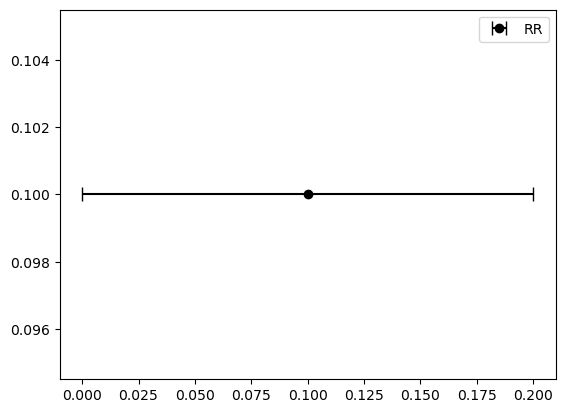

In [51]:
from scipy.stats import kstest, mannwhitneyu, ttest_ind
import matplotlib as mpl

_, black_ax = plt.subplots()
black_ax.errorbar(y=0.1, x=0.1, xerr=0.1, color="k", label="RR", fmt="o", capsize=5);
black_ax.legend();
black_handle, _ = black_ax.get_legend_handles_labels()

# def compare_overlap(sample1, sample2):
#     conf1 = compute_num_interval(sample1, pval)
#     conf2 = compute_num_interval(sample2, pval)
    
    
def compute_overlap_between_normals(m01,m02,std01,std02):
    # https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy
    # Alternatively: https://rpsychologist.com/calculating-the-overlap-of-two-normal-distributions-using-monte-carlo-integration
    if m01 < m02:
        m1, m2 = m01, m02
        std1, std2 = std01, std02
    else:
        m1, m2 = m02, m01
        std1, std2 = std02, std01
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    r = np.roots([a,b,c])
    return min(sp.stats.norm.cdf(r,m2,std2) + (1. - sp.stats.norm.cdf(r,m1,std1)))

In [69]:
def plot_comparison(pairs, kmin=0, kmax=9, labels=labels, tests=False, loc=None, xlim=None, sharex=False, figsize=None, panel_labels=False, log=False):
    k_range = range(kmin, kmax+1)
    # max_label_len = max([len(x) for x in labels])
    
    fig, axes = plt.subplots(len(pairs), 1, figsize=(13, (3 if not sharex else 2) * len(pairs)) if figsize is None else figsize, sharex=sharex)
    for l, pair in enumerate(pairs):
        # cond_names = [identify_LTC(cond, models[kmin].morb_names)[1] for cond in pair]
        # pair = [identify_LTC(cond, names)[0] for cond in pair]
        
        if tests:
            for k_pair in it.combinations(k_range, 2):
                sample_1, sample_2 = [models[k]._get_var("r", LTC1=pair[0], LTC2=pair[1]) for k in k_pair]
                pvalues = [f"{test_name} {test(sample_1, sample_2)[1]:.2}" for test_name, test in zip(("KS", "MW", "T", ""), (kstest, mannwhitneyu, ttest_ind, probability_of_larger))]  # , compare_overlap))]
                
                assert type(pair[0]) == str
                normal_params = [models[k].compute_RR_normal_params(*pair) for k in k_pair]
                if all([params[2] for params in normal_params]):
                    RR_overlap = compute_overlap_between_normals(*[params[0] for params in normal_params], *[params[1] for params in normal_params])
                    pvalues.append(f" {RR_overlap:.2}")
                
                # print(f"{labels[k_pair[0]]} - {labels[k_pair[1]]:21}: " + ", ".join(pvalues))
            # print("")
        
        ax = axes[l] if type(axes) == np.ndarray else axes
        for k in k_range:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # To avoid the annoying warning about distplots
                assert type(pair[0]) == str, f"{type(pair[0])}, {pair[0]}"
                sns.distplot(1 + models[k]._get_var("r", LTC1=pair[0], LTC2=pair[1]), kde=False, bins=50, ax=ax, label=f"ABC ({labels[k]})", norm_hist=True)
        
        # ax = axes[l,1]
        ax2 = ax.twinx()
        for k in k_range:
            assert type(pair[0]) == str, f"{type(pair[0])}, {pair[0]}"
            ij = tuple(identify_LTC(cond, models[k].morb_names)[0] for cond in pair)
            
            rr_ij = models[k].RRs[ij]
            kwargs = {"fmt":"o" if models[k].fishers_sig[ij] else "x"}
            ax2.errorbar(y=k, x=rr_ij, xerr=np.array([rr_ij - models[k].RRs_conf[0][ij], models[k].RRs_conf[1][ij] - rr_ij])[:,None], color=f"C{k-kmin}", label=f"RR ({labels[k]})", elinewidth=2.5, capthick=2.5, capsize=10, ms=10, **kwargs);
        ax2.set(ylim=[kmin - 0.5 * (kmax - kmin), kmax + 0.5 * (kmax - kmin)])
        # ax2.legend(loc="upper left");
                
        ax.axvline(1, ls="--", c="k")
        assert type(pair[0]) == str, f"{type(pair[0])}, {pair[0]}"
        ax.set(title=f"{beautify_name(pair[0], short=True)} - {beautify_name(pair[1], short=True)}")
        
        ax.text(0.03, 0.82, "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"[l], transform=ax.transAxes, ha="center", va="center", fontsize=20) if panel_labels else None
        
        handles, _ = ax.get_legend_handles_labels()
        RR_ABC_labels = ["RR" + (f" (p={pvalues[4]})" if tests else ""), "ABC" + (f" (p={pvalues[3]})" if tests else "")]
        ax2.legend(handles + black_handle + [mpl.patches.Patch(color="k")], [lbl for k, lbl in enumerate(labels) if k in k_range] + RR_ABC_labels, ncol=2, loc=loc)  # loc="lower left")  # ncol=2)
        ax.set(xlim=xlim) if xlim is not None else None
        ax.yaxis.set(ticks=[], ticklabels=[]),ax2.yaxis.set(ticks=[], ticklabels=[])
        
        if log:
            ax.set_xscale("log")
            ax2.set_xscale("log")
            
    ax.set(xlabel="Association measure")
    fig.tight_layout();

Highest differences in RR for associations that are present in both cohorts by both methods (note that differences may also be significant by ABC):

In [53]:
dat_comp_by_both_both.sort_values(by="diff_RR_abs", ascending=False).iloc[:5].loc[:, ["RR_f_sig_CI_male", "RR_f_sig_CI_female", "conf_ABC_diff", "conf_RR_diff"]]#, "Xi", "Xj", "Xij"]]  # , "RR1", "RR2"]]

RR_f_sig_CI_male  RR_f_sig_CI_female  \
names                                                                      
Depression-AnxietyEtc             3.64 (3.55 - 3.73)  2.14 (2.13 - 2.14)   
Depression-PainfulCondition       2.14 (2.06 - 2.22)   1.5 (1.49 - 1.51)   
Depression-Dementia               2.36 (2.28 - 2.44)  1.73 (1.72 - 1.74)   
AnxietyEtc-TreatedConstipation    2.07 (2.03 - 2.11)  1.55 (1.55 - 1.56)   
OtherPsychoactiveMisuse-Dementia   1.83 (1.76 - 1.9)  1.34 (1.33 - 1.35)   

                                  conf_ABC_diff   conf_RR_diff  
names                                                           
Depression-AnxietyEtc                   0.00015   0.000000e+00  
Depression-PainfulCondition             0.02700   1.714426e-91  
Depression-Dementia                     0.04295   2.231931e-88  
AnxietyEtc-TreatedConstipation          0.00815  1.018421e-212  
OtherPsychoactiveMisuse-Dementia        0.04410   1.262933e-66

In [54]:
labels_as = ["Men", "Women"] * int(len(fnames) / 2)
comp_kwargs = {"kmin": 18, "kmax": 19, "labels": labels_as, "xlim":(0.7, 3.1), "sharex":True}

Highest differences in RR for associations that are present in both cohorts by both methods and that are significant by RR but NOT significant by ABC:

In [55]:
comp_table = dat_comp[dat_comp["a_sig_male"] & dat_comp["a_sig_female"] & (dat_comp["conf_ABC_diff"] > 0.05) & dat_comp["sig_RR"]]
print(len(comp_table))
highest_diff_RR_not_sig_diff_ABC = comp_table.sort_values(by="diff_RR_abs", ascending=False).iloc[:5].loc[:, ["namei", "namej", "RR_f_sig_CI_male", "RR_f_sig_CI_female", "conf_ABC_diff", "conf_RR_diff"]]  # , "Xi", "Xj", "Xij"]] # , "diff_RR", "RR1", "RR2"]]
highest_diff_RR_not_sig_diff_ABC.iloc[:, 2:]

35


RR_f_sig_CI_male  \
names                                                         
AnxietyEtc-Diverticular                  1.69 (1.61 - 1.79)   
PeripheralVascularDisease-HeartFailure   1.87 (1.78 - 1.97)   
Depression-TreatedConstipation           1.98 (1.94 - 2.02)   
PainfulCondition-RheumatoidArthritisEtc  1.73 (1.65 - 1.81)   
Depression-OtherPsychoactiveMisuse       1.63 (1.56 - 1.71)   

                                         RR_f_sig_CI_female  conf_ABC_diff  \
names                                                                        
AnxietyEtc-Diverticular                  1.35 (1.34 - 1.36)        0.17940   
PeripheralVascularDisease-HeartFailure    1.54 (1.48 - 1.6)        0.20255   
Depression-TreatedConstipation           1.66 (1.65 - 1.66)        0.07085   
PainfulCondition-RheumatoidArthritisEtc  1.42 (1.41 - 1.44)        0.19885   
Depression-OtherPsychoactiveMisuse       1.33 (1.32 - 1.34)        0.16335   

                                         conf_RR_diff  
names                                                  
AnxietyEtc-Diverticular                  2.108452e-20  
PeripheralVascularDisease-HeartFailure   1.458668e-08  
Depression-TreatedConstipation           3.178965e-93  
PainfulCondition-RheumatoidArthritisEtc  1.760980e-19  
Depression-OtherPsychoactiveMisuse       4.402622e-24

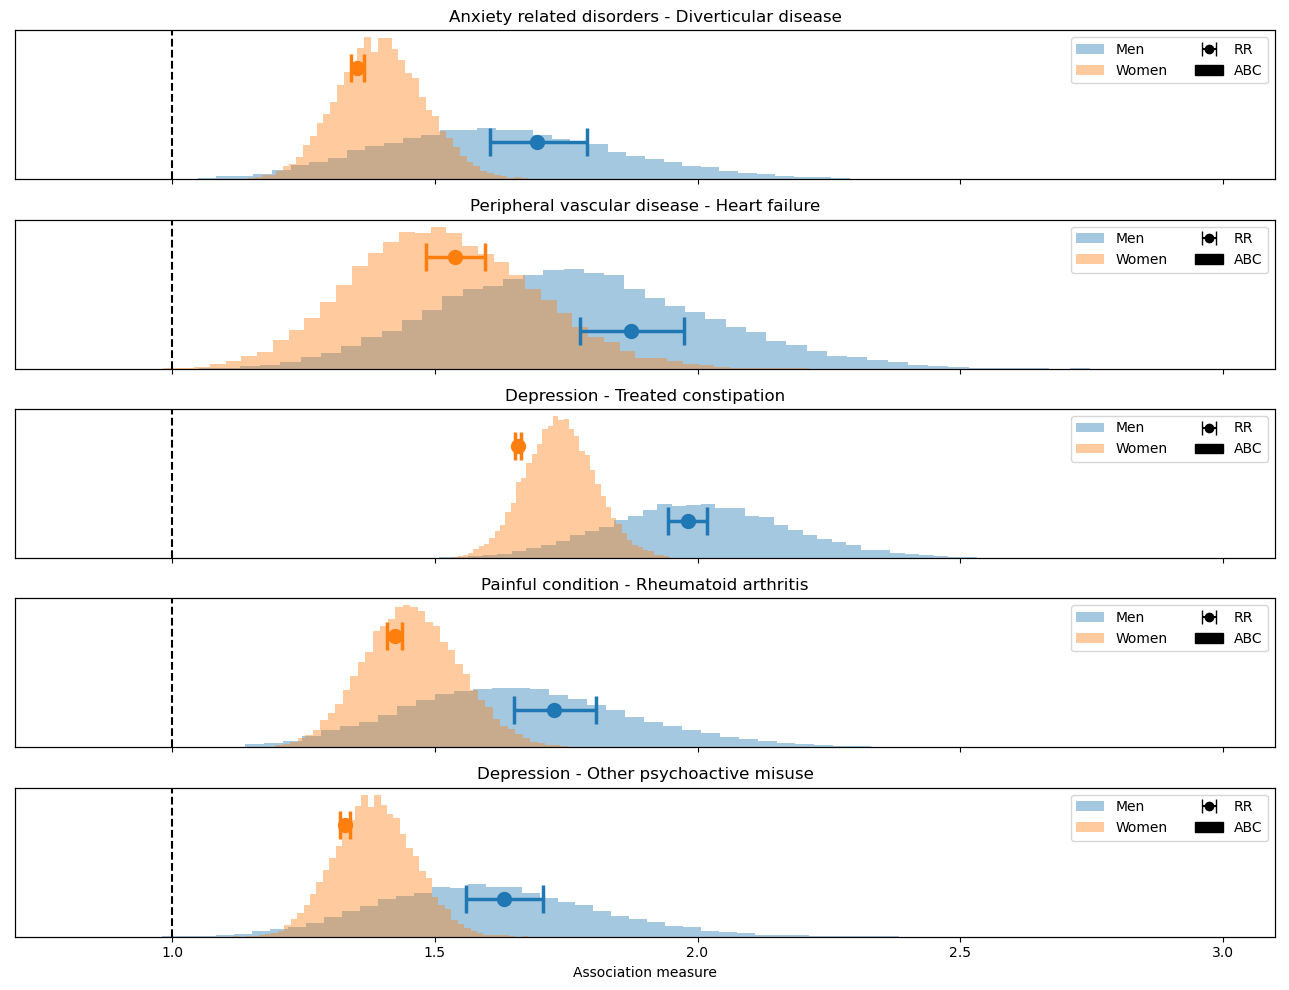

In [56]:
plot_comparison(highest_diff_RR_not_sig_diff_ABC.loc[:, ["namei","namej"]].values.tolist(), **comp_kwargs)

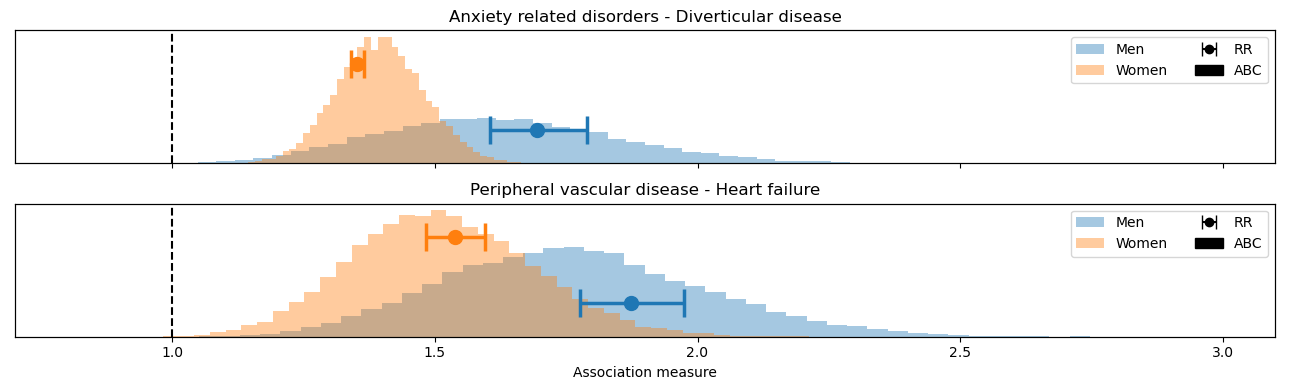

In [57]:
plot_comparison(highest_diff_RR_not_sig_diff_ABC.iloc[:2][["namei","namej"]].values.tolist(), **comp_kwargs)

Highest differences in RR for associations that are present in both cohorts by both methods and that are significant by RR but NOT significant by ABC:

In [58]:
comp_table = dat_comp[dat_comp["sig_RR"]].sort_values(by="conf_ABC_diff", ascending=False).iloc[:5]  # , "Xi", "Xj", "Xij"]] # , "sig_RR1", "sig_RR2"]]  # , "diff_RR", "RR1", "RR2"]]
comp_table.loc[:, ["conf_ABC_diff", "conf_RR_diff", "diff_RR"]]

conf_ABC_diff  conf_RR_diff   diff_RR
names                                                                     
Depression-IrritableBowelSyndrome          0.48015      0.000017  0.840041
AnxietyEtc-IrritableBowelSyndrome          0.45520      0.001037  0.698934
RheumatoidArthritisEtc-HeartFailure        0.45415      0.005197  0.082762
CHD-TreatedConstipation                    0.43925      0.001655  0.019415
StrokeTIA-Diverticular                     0.43835      0.008236  0.055705

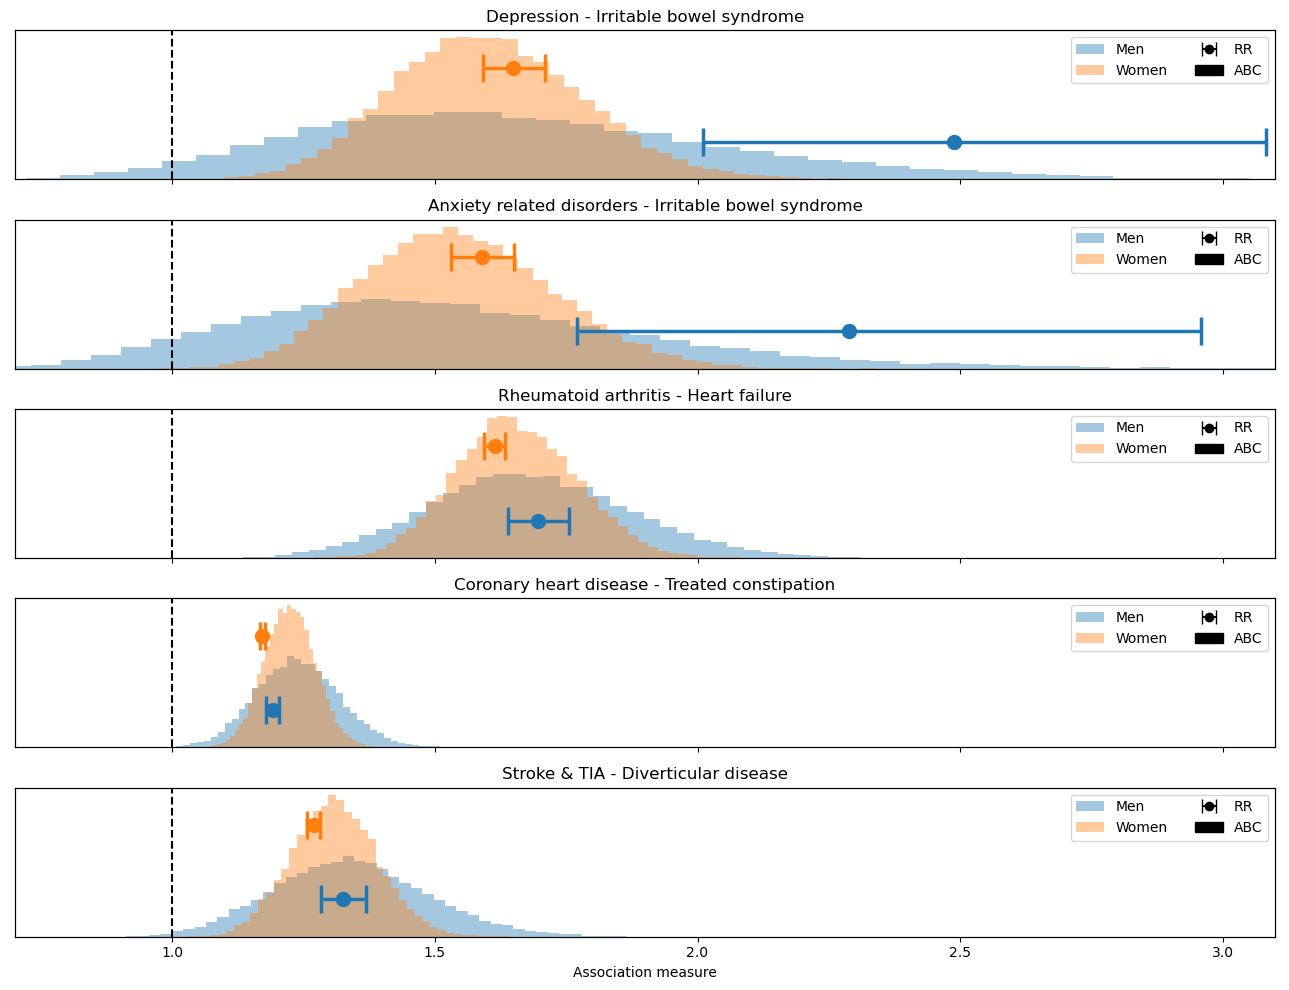

In [59]:
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), **comp_kwargs)

Highest signicant differences in RR for associations signifinat by RR in both sexes and whose differences are NOT significant by ABC:

In [60]:
comp_table = dat_comp[dat_comp["sig_RR"] & ~ dat_comp["sig_ABC_diff"]].sort_values(by="diff_RR_abs", ascending=False).iloc[:5]  # , "Xi", "Xj", "Xij"]] # , "sig_RR1", "sig_RR2"]]  # , "diff_RR", "RR1", "RR2"]]
top_RR_diff_not_ABC_sig = beautify_index(comp_table.loc[:, ["RR_f_sig_CI_male", "RR_f_sig_CI_female", "conf_RR_diff"]])  # , "diff_RR", "conf_ABC_diff"
top_RR_diff_not_ABC_sig

RR_f_sig_CI_male  \
Depression - Irritable bowel syndrome (IBS)         2.49 (2.01 - 3.08)   
Anxiety & other neurotic, stress related & soma...  2.29 (1.77 - 2.96)   
Treated constipation - Parkinson’s disease          2.07 (1.88 - 2.27)   
Thyroid disorders - Rheumatoid arthritis, other...   1.62 (1.5 - 1.74)   
Anxiety & other neurotic, stress related & soma...  1.69 (1.61 - 1.79)   

                                                    RR_f_sig_CI_female  \
Depression - Irritable bowel syndrome (IBS)         1.65 (1.59 - 1.71)   
Anxiety & other neurotic, stress related & soma...  1.59 (1.53 - 1.65)   
Treated constipation - Parkinson’s disease          1.56 (1.46 - 1.66)   
Thyroid disorders - Rheumatoid arthritis, other...   1.2 (1.19 - 1.21)   
Anxiety & other neurotic, stress related & soma...  1.35 (1.34 - 1.36)   

                                                    conf_RR_diff  
Depression - Irritable bowel syndrome (IBS)         1.654444e-05  
Anxiety & other neurotic, stress related & soma...  1.036508e-03  
Treated constipation - Parkinson’s disease          4.407795e-06  
Thyroid disorders - Rheumatoid arthritis, other...  3.741849e-20  
Anxiety & other neurotic, stress related & soma...  2.108452e-20

In [61]:
print(top_RR_diff_not_ABC_sig.to_latex())

\begin{tabular}{lllr}
\toprule
{} &    RR\_f\_sig\_CI\_male &  RR\_f\_sig\_CI\_female &  conf\_RR\_diff \\
\midrule
Depression - Irritable bowel syndrome (IBS)        &  2.49 (2.01 - 3.08) &  1.65 (1.59 - 1.71) &  1.654444e-05 \\
Anxiety \& other neurotic, stress related \& soma... &  2.29 (1.77 - 2.96) &  1.59 (1.53 - 1.65) &  1.036508e-03 \\
Treated constipation - Parkinson’s disease         &  2.07 (1.88 - 2.27) &  1.56 (1.46 - 1.66) &  4.407795e-06 \\
Thyroid disorders - Rheumatoid arthritis, other... &   1.62 (1.5 - 1.74) &   1.2 (1.19 - 1.21) &  3.741849e-20 \\
Anxiety \& other neurotic, stress related \& soma... &  1.69 (1.61 - 1.79) &  1.35 (1.34 - 1.36) &  2.108452e-20 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3078824/2946497668.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_RR_diff_not_ABC_sig.to_latex())


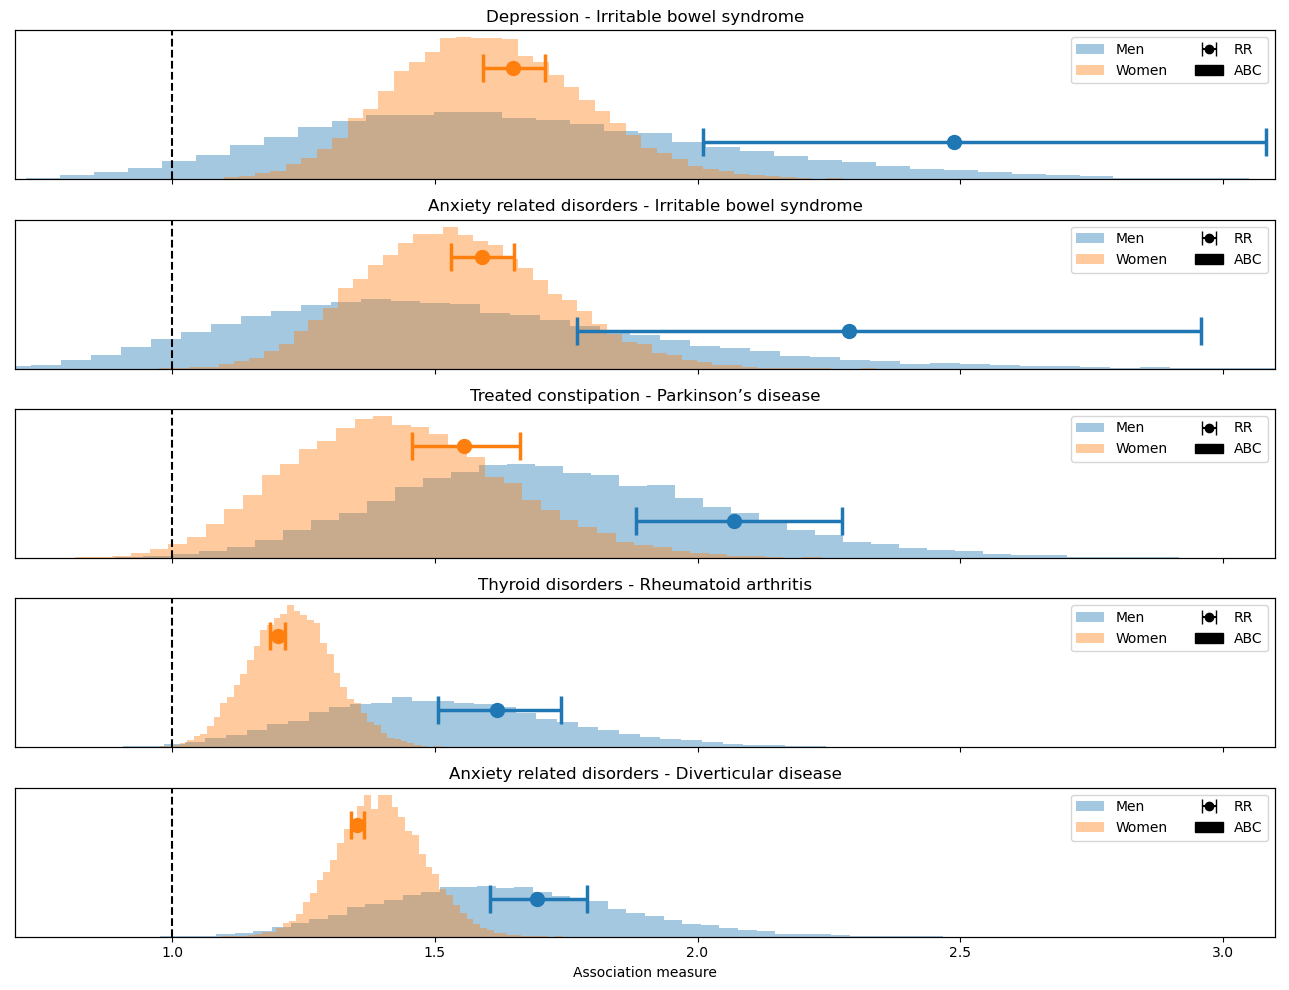

In [62]:
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), **comp_kwargs)

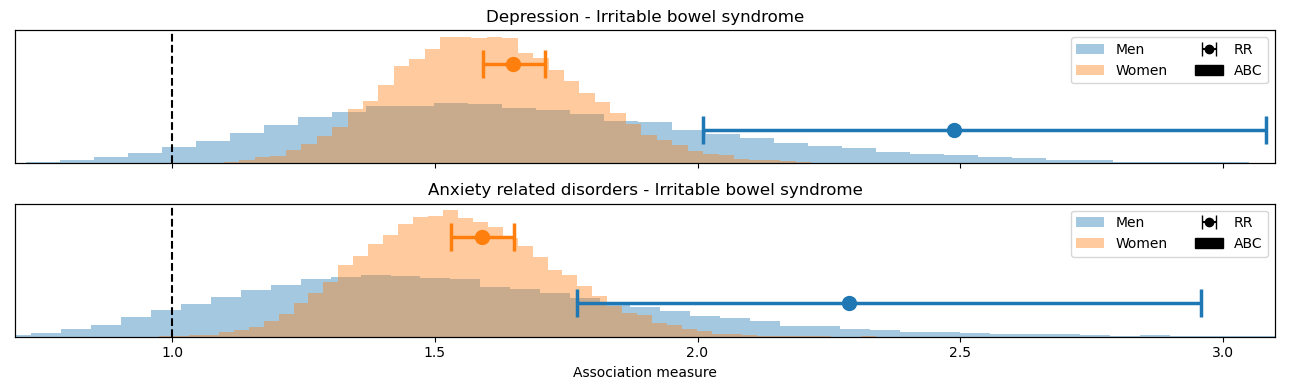

In [63]:
plot_comparison(comp_table.iloc[:2].loc[:, ["namei","namej"]].values.tolist(), **comp_kwargs)

In [64]:
comp_kwargs["xlim"] = (0.7, 4.5)  #, "sharex":True}

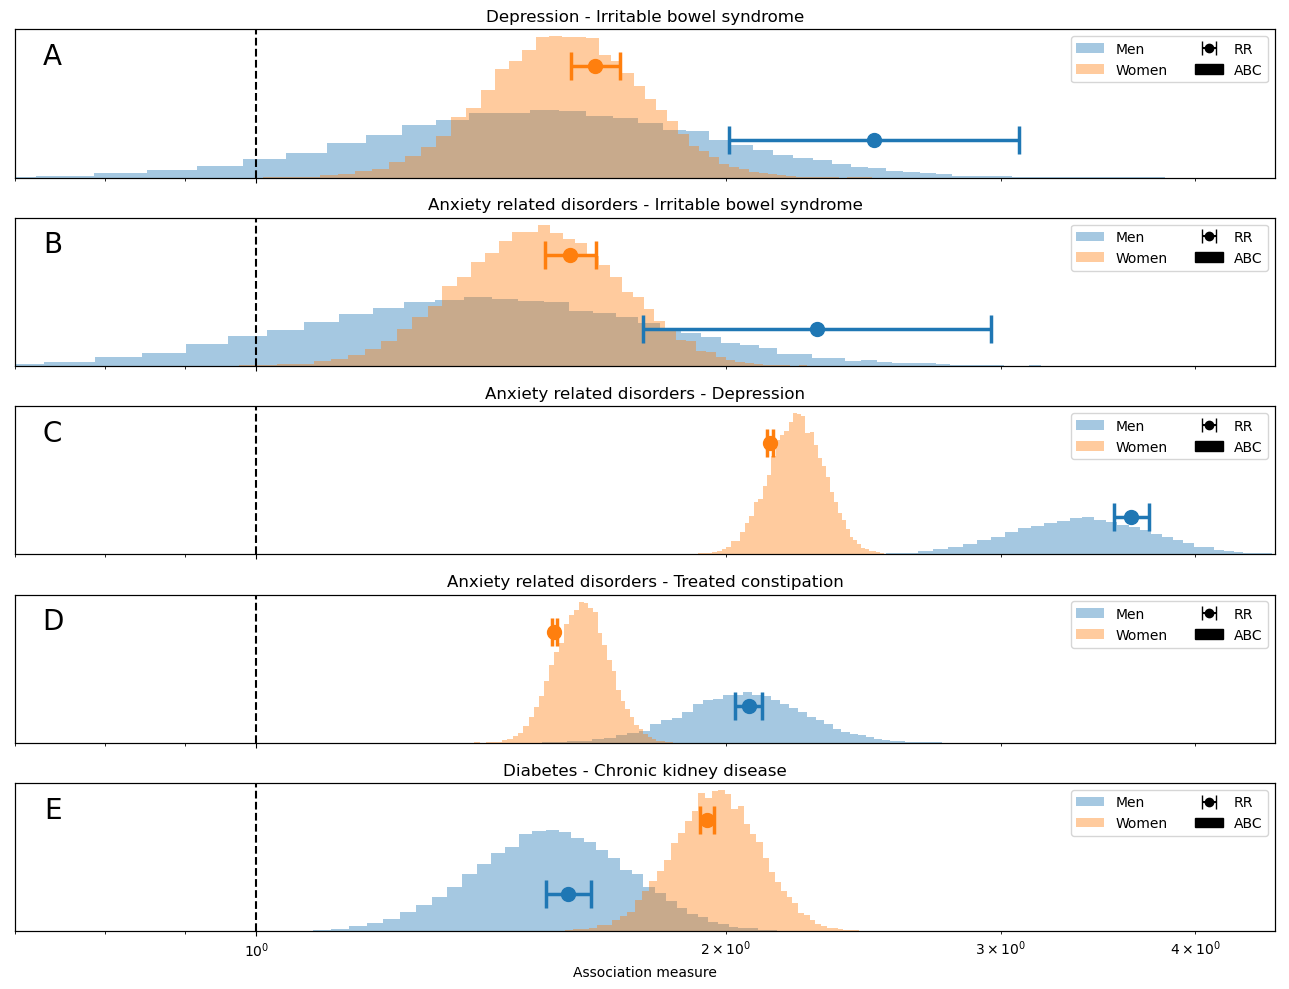

In [70]:
plot_comparison([("Depression", "IrritableBowelSyndrome"),
                 ("AnxietyEtc", "IrritableBowelSyndrome"),
                 ("AnxietyEtc", "Depression"), ("AnxietyEtc", "TreatedConstipation"), ("Diabetes", "CKD")], panel_labels=True, log=True, **comp_kwargs)

In [38]:
RR_both.max(), RR_both.min()

(RR_female    4.560244
 RR_male      5.638219
 diff_RR      1.502540
 dtype: float64,
 RR_female    0.686003
 RR_male      0.628987
 diff_RR     -0.359244
 dtype: float64)

In [82]:
comp_kwargs["log"] = True
comp_kwargs["xlim"] = (0.5, 9)  #, "sharex":True}

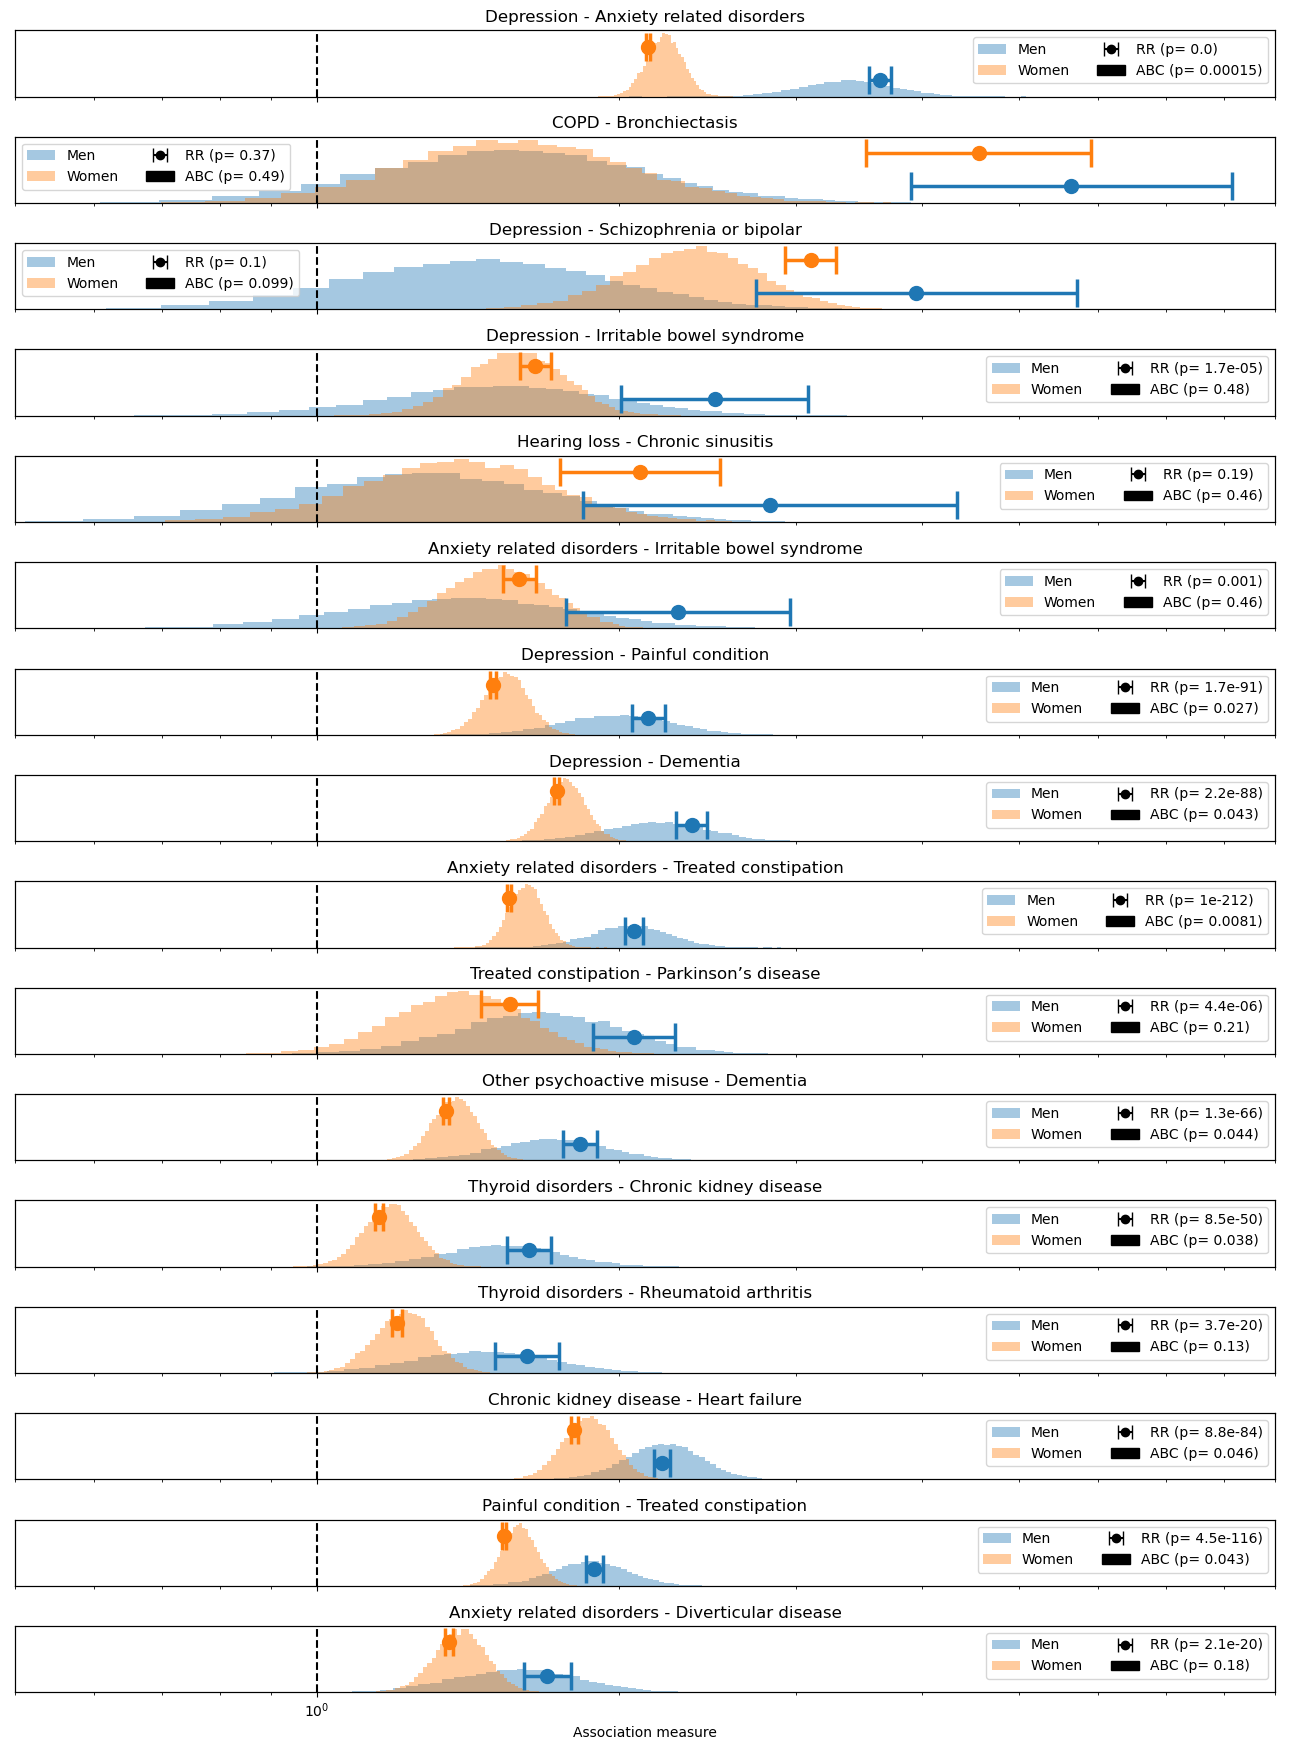

In [84]:
comp_table = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).iloc[:16]
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), tests=True, figsize=(13, 1.1*len(comp_table)), **comp_kwargs)

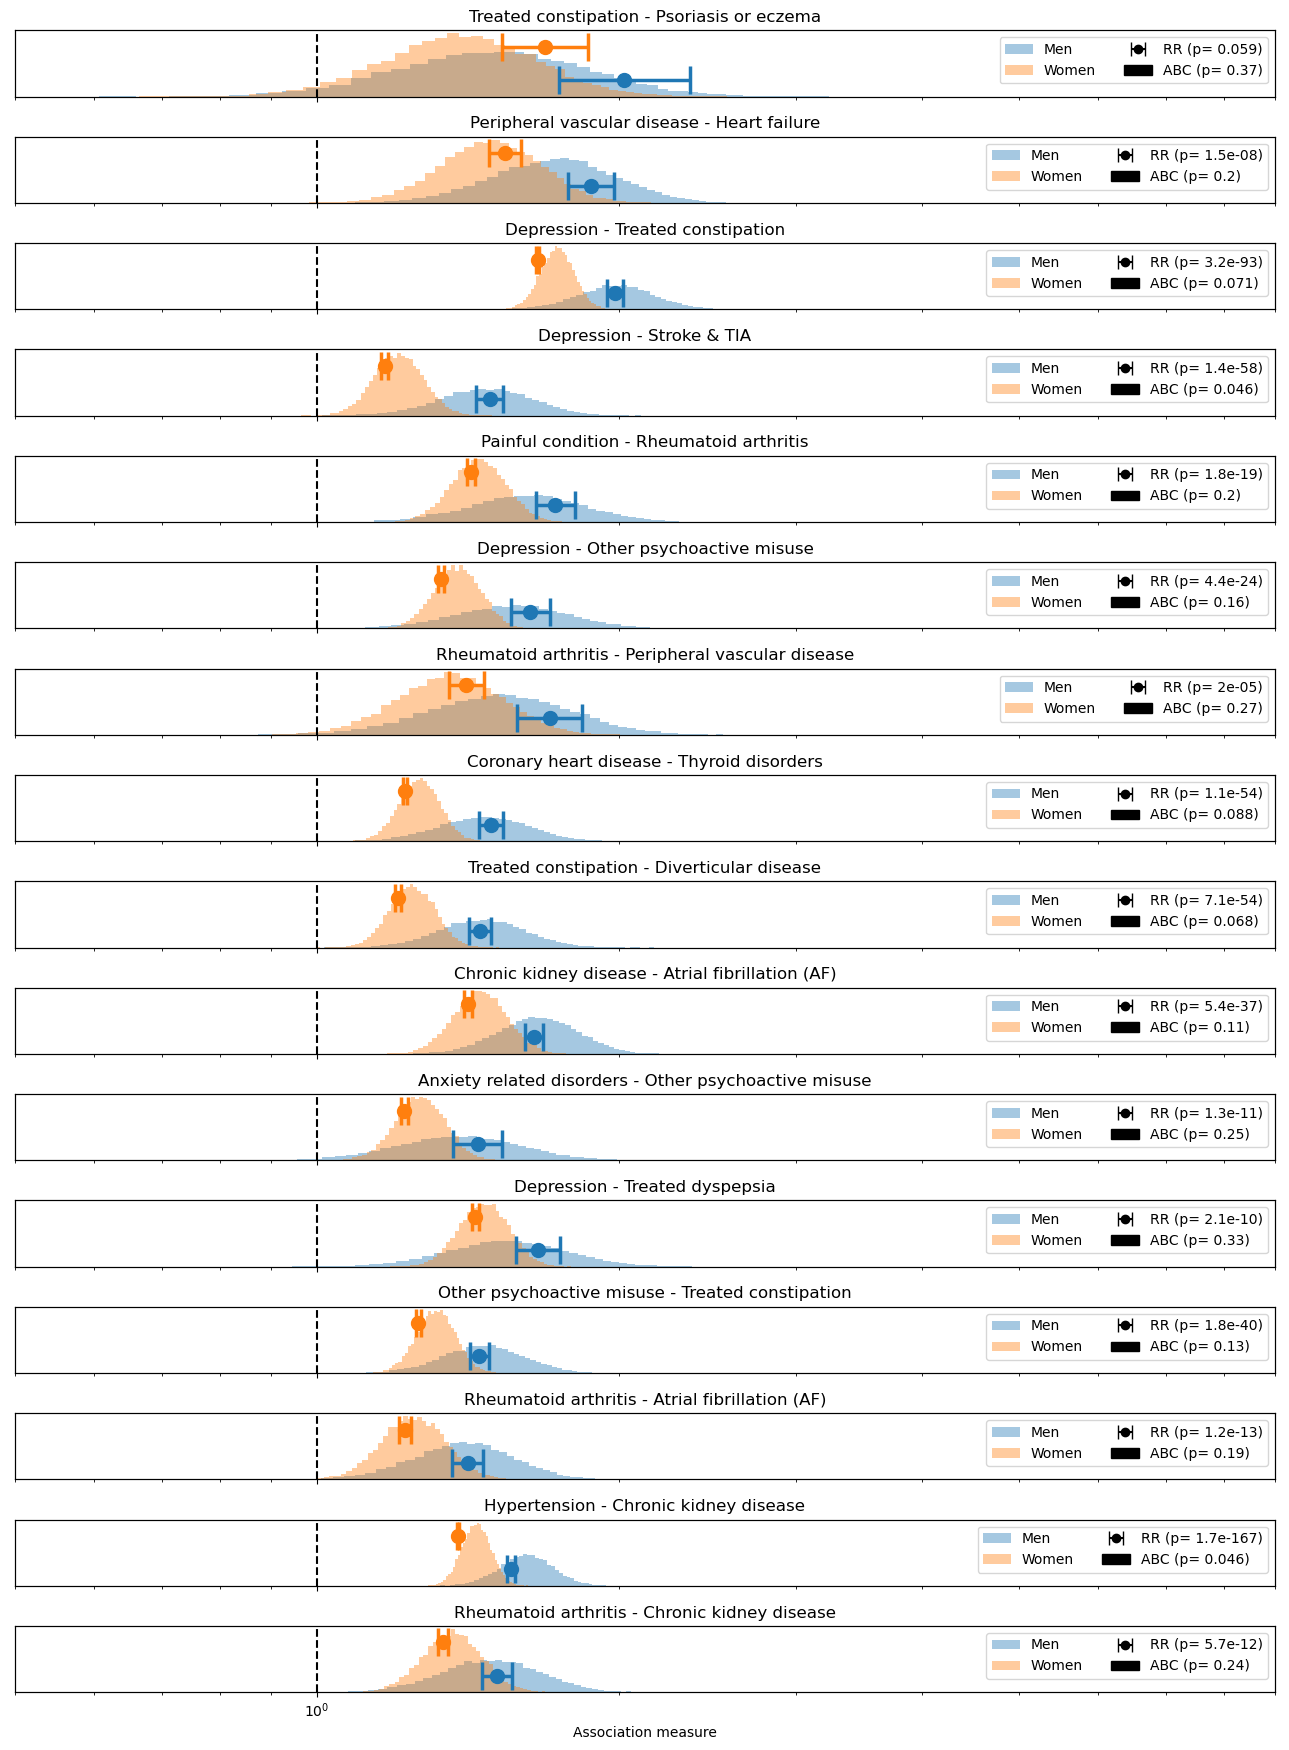

In [85]:
comp_table = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).iloc[16:32]
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), tests=True, figsize=(13, 1.1*len(comp_table)), **comp_kwargs)

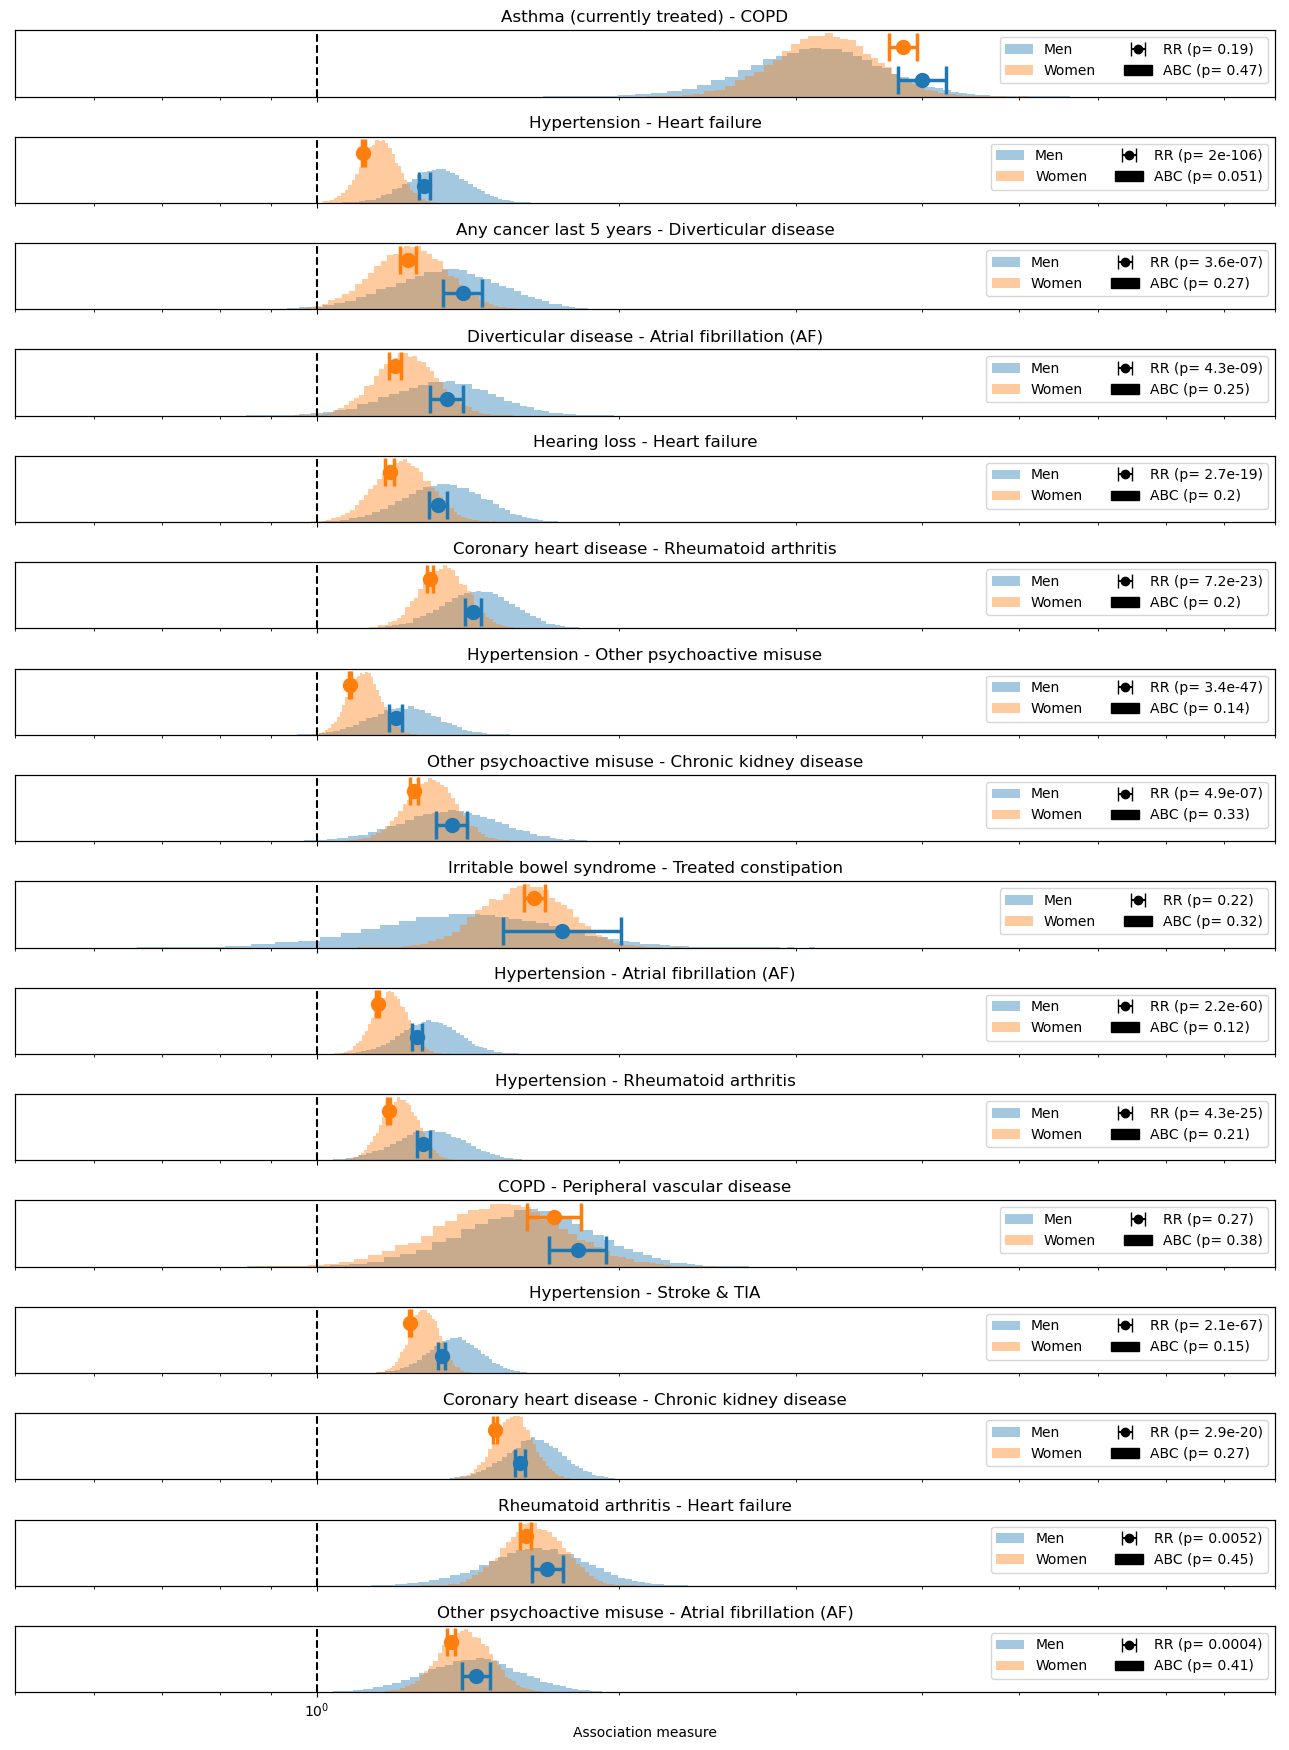

In [86]:
comp_table = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).iloc[32:48]
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), tests=True, figsize=(13, 1.1*len(comp_table)), **comp_kwargs)

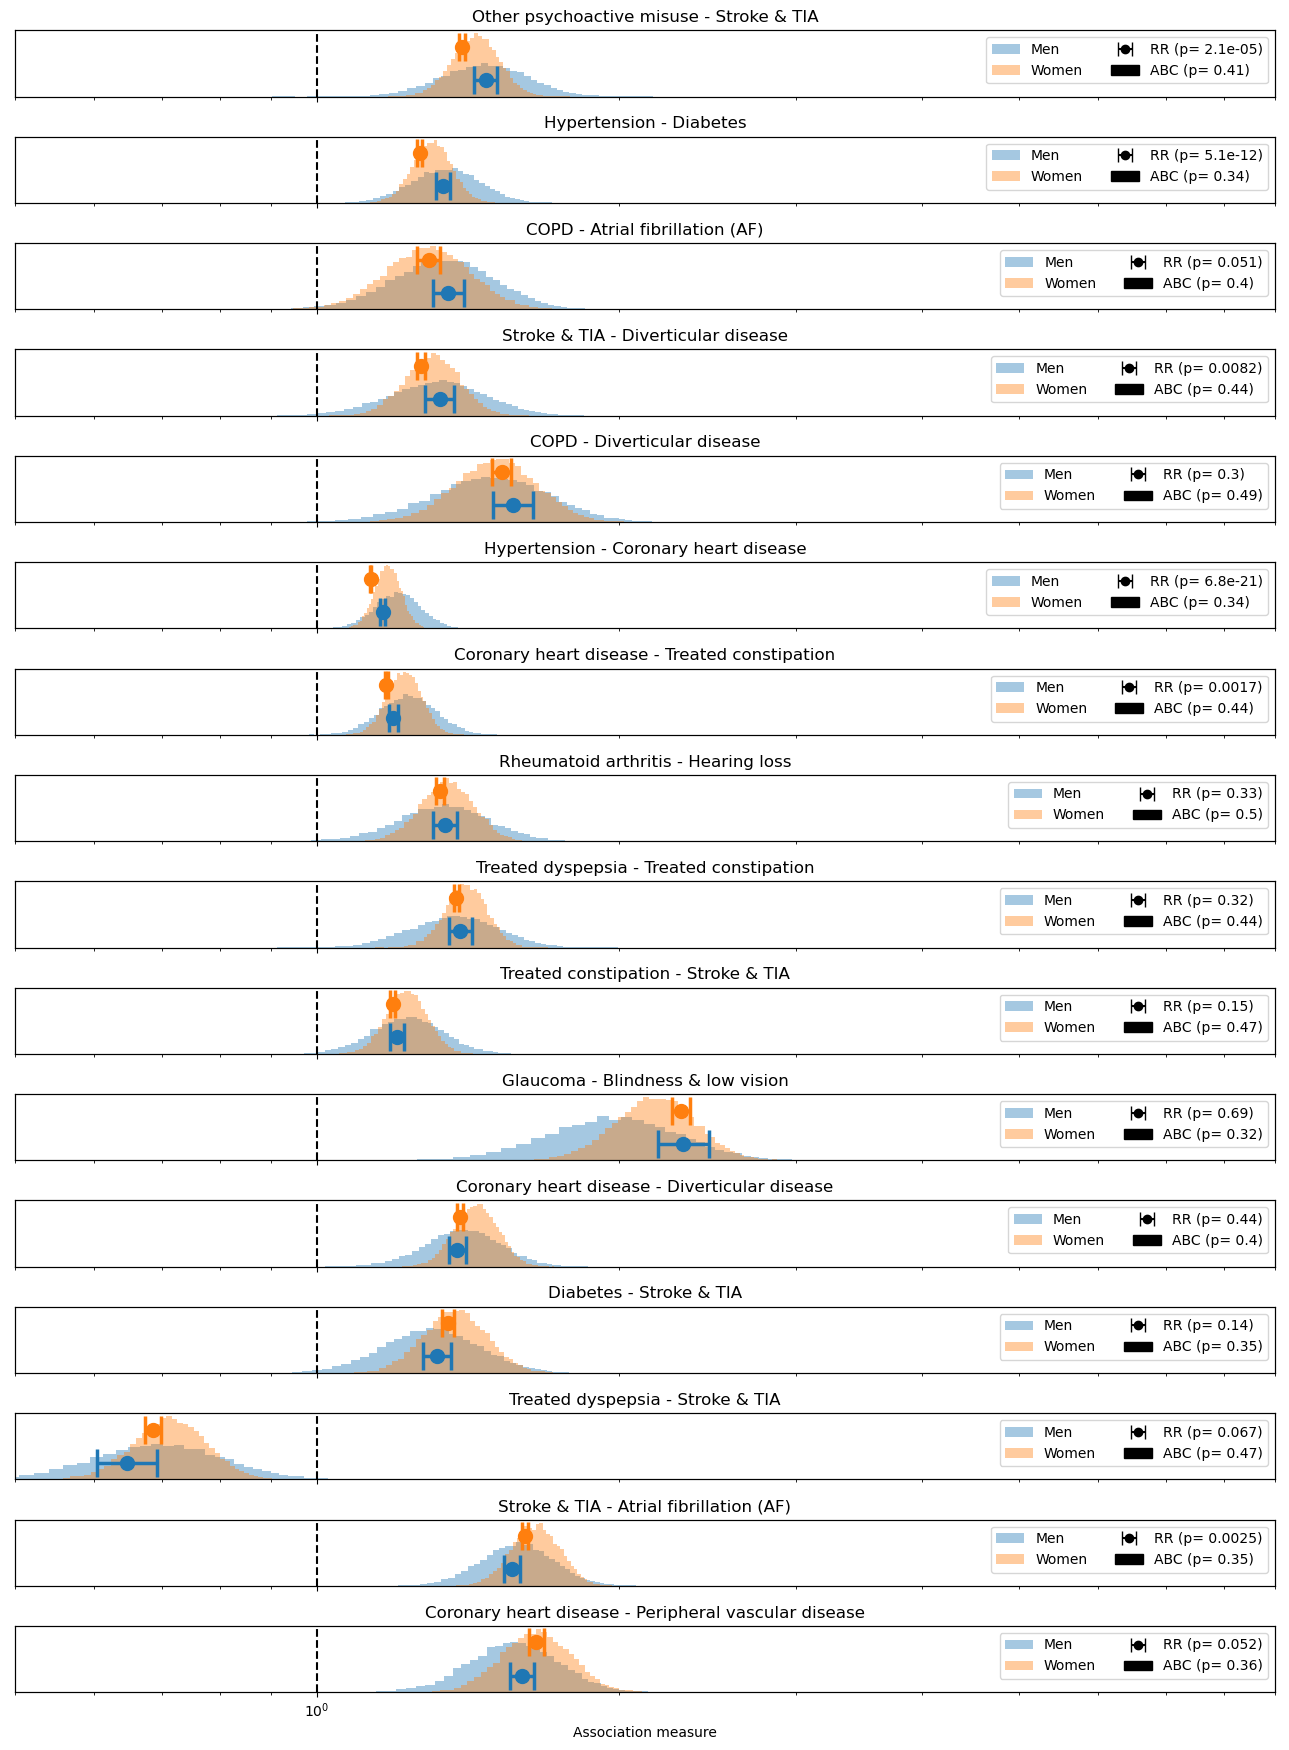

In [87]:
comp_table = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).iloc[48:64]
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), tests=True, figsize=(13, 1.1*len(comp_table)), **comp_kwargs)

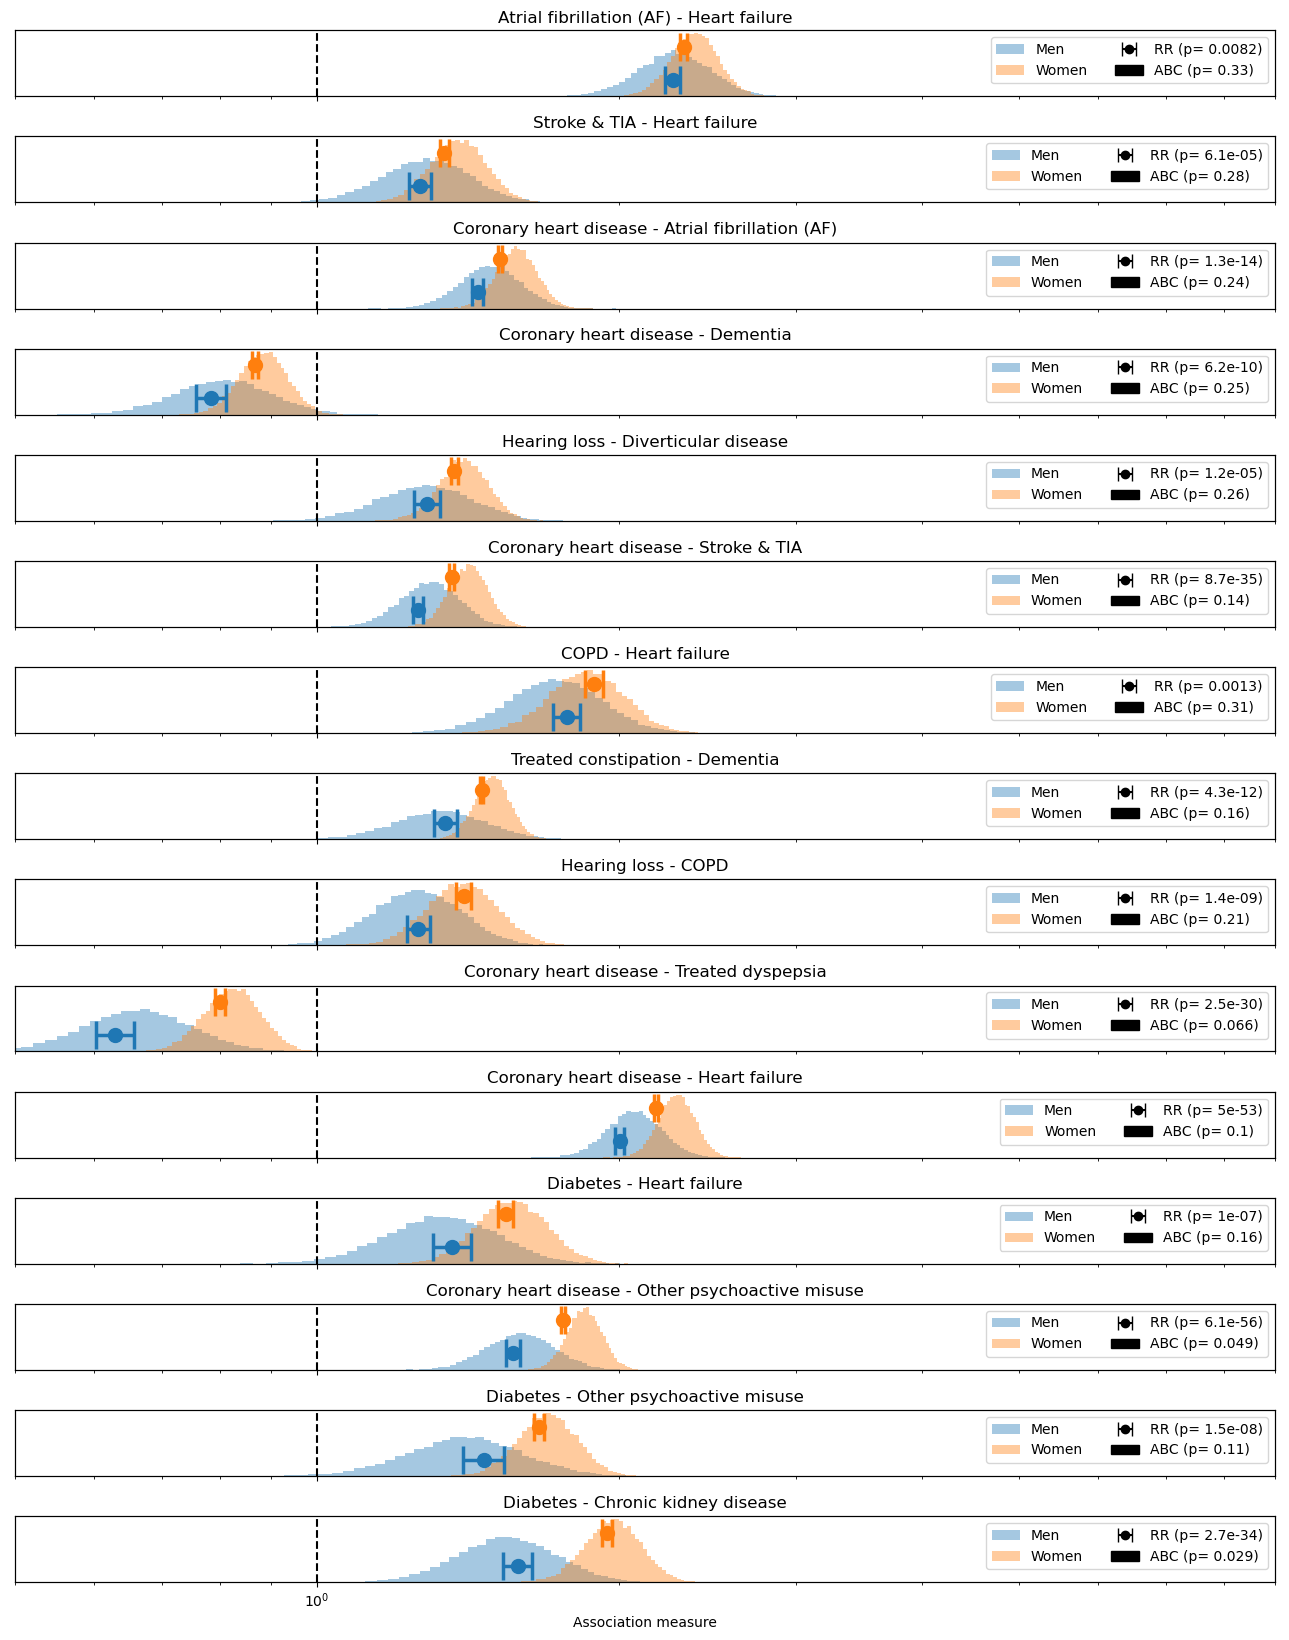

In [88]:
comp_table = dat_comp[dat_comp["fisher_sig_female"] & dat_comp["fisher_sig_male"]].sort_values(by="diff_RR", ascending=False).iloc[64:80]
plot_comparison(comp_table.loc[:, ["namei","namej"]].values.tolist(), tests=True, figsize=(13, 1.1*len(comp_table)), **comp_kwargs)

# Results 85yo+ population

Here, we include patients 85 years old and older to test the possibility of false positives.

## WITHOUT sex stratification

In [18]:
dfs, labels, fnames, L, Xs, Ps, Ms = stratify(df, "Age85")

Length of dataset: 479156


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 508389


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 473127


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 254600


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 36569


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


In [14]:
index = 4

In [15]:
def describe_subpopulation(index, lower_lim):
    df_eld = df[df["Age"] >= lower_lim]
    df_eld_male = df_eld[df_eld["Sex"]==0]
    df_eld_female = df_eld[df_eld["Sex"]==1]
    print(f"# of patients: Total {len(df_eld)}, males:{len(df_eld_male)} ({100 * len(df_eld_male)/len(df_eld):.2f}%), females:{len(df_eld_female)} ({100 * len(df_eld_female)/len(df_eld):.2f}%)")
    
    morb_cols = df_eld.columns[11:51]
    def describe_group(dfo, ax, label):
        counts, _ = np.histogram(dfo[morb_cols].values.sum(axis=1), bins=range(17))
        ax.bar(range(len(counts)), counts);
        ax.set(xlabel="# of diganosed LTCs", ylabel="# of patients >85yo", title=label)

        print(f"{label:7}| >=3 morb: {counts[3:].sum():5} ({100*counts[3:].sum()/len(dfo):.2f}%), >=2 morb: {100*counts[2:].sum()/len(dfo):.2f}%, mean morb: {(mean:= sum(i * count for i, count in enumerate(counts))/len(dfo)):.2f}+-{np.sqrt(sum((i - mean)**2 * count for i, count in enumerate(counts))/len(dfo)):.2f}")
        return list(zip(range(len(counts)), counts, counts/len(dfo)*100))
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    describe_group(df_eld, axes[0], "Total")
    describe_group(df_eld_male, axes[1], "Males")
    describe_group(df_eld_female, axes[2], "Females")
    
    LTC_prev_df = pd.DataFrame(index=names, columns=["Counts", "Prevalence"], data=np.array([Ps[index,:],Ps[index,:]/Ms[index]]).T).sort_values("Counts", ascending=False)
    LTC_prev_df["Counts"] = LTC_prev_df["Counts"].astype(int)
    LTC_prev_df["Prevalence"] = (100 * LTC_prev_df["Prevalence"]).apply(lambda x: f'{x:.2g}%')
    return LTC_prev_df

# of patients: Total 36569, males:11033 (30.17%), females:25536 (69.83%)
Total  | >=3 morb: 23653 (64.68%), >=2 morb: 81.48%, mean morb: 3.62+-2.30
Males  | >=3 morb:  6904 (62.58%), >=2 morb: 79.94%, mean morb: 3.52+-2.32
Females| >=3 morb: 16749 (65.59%), >=2 morb: 82.15%, mean morb: 3.66+-2.29


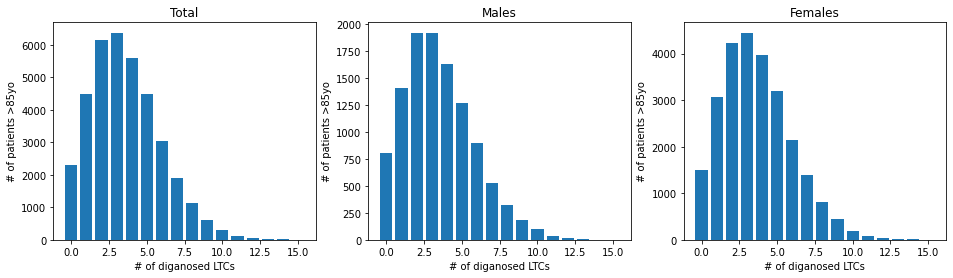

In [11]:
LTC_prev_df = describe_subpopulation(index=index, lower_lim=85)

In [8]:
LTC_prev_df

Counts Prevalence
Hypertension                18830        51%
CHD                          9491        26%
TreatedConstipation          7414        20%
HearingLoss                  6320        17%
PainfulCondition             6268        17%
CKD                          6059        17%
StrokeTIA                    5885        16%
Depression                   5554        15%
ThyroidDisorders             5153        14%
AnxietyEtc                   4887        13%
AtrialFib                    4835        13%
TreatedDyspepsia             4651        13%
Diverticular                 4635        13%
Dementia                     4481        12%
OtherPsychoactiveMisuse      4474        12%
RheumatoidArthritisEtc       4373        12%
Diabetes                     3983        11%
AnyCancer_Last5Yrs           3921        11%
HeartFailure                 3761        10%
COPD                         3353       9.2%
Glaucoma                     2762       7.6%
PeripheralVascularDisease    2140       5.9%
Blindness                    1982       5.4%
ActiveAsthma                 1717       4.7%
Prostate                     1386       3.8%
IrritableBowelSyndrome       1146       3.1%
Parkinsons                    526       1.4%
AlcoholProblems               442       1.2%
SchizophreniaBipolar          371         1%
PsoriasisEczema               346      0.95%
Epilepsy                      307      0.84%
InflammatoryBowelDisease      263      0.72%
ChronicSinusitis              180      0.49%
Bronchiectasis                168      0.46%
AnorexiaBulimia               109       0.3%
Migraine                       51      0.14%
MultipleSclerosis              40      0.11%
LearningDisability             32     0.088%
ChronicLiverDisease            22      0.06%
ViralHepatitis                  3    0.0082%

In [17]:
df_eldo = df[(df["Age"] >= 85) & (df["Age"] < 90)]
print(f"Total: {len(df_eldo)}")
morb_cols = df_eldo.columns[11:51]
for morb_col in morb_cols:
    print(morb_col, df_eldo[morb_col].sum(), f"{df_eldo[morb_col].mean() * 100:.2g}%")

Total: 24560
Hypertension 13355 54%
Depression 3704 15%
PainfulCondition 4491 18%
ActiveAsthma 1280 5.2%
CHD 6421 26%
TreatedDyspepsia 3126 13%
Diabetes 2860 12%
ThyroidDisorders 3390 14%
RheumatoidArthritisEtc 2998 12%
HearingLoss 3963 16%
COPD 2448 10%
AnxietyEtc 3075 13%
IrritableBowelSyndrome 848 3.5%
AnyCancer_Last5Yrs 2701 11%
AlcoholProblems 339 1.4%
OtherPsychoactiveMisuse 2653 11%
TreatedConstipation 4399 18%
StrokeTIA 3826 16%
CKD 4230 17%
Diverticular 3153 13%
AtrialFib 3127 13%
PeripheralVascularDisease 1570 6.4%
HeartFailure 2277 9.3%
Prostate 1037 4.2%
Glaucoma 1775 7.2%
Epilepsy 219 0.89%
Dementia 2575 10%
SchizophreniaBipolar 271 1.1%
PsoriasisEczema 249 1%
InflammatoryBowelDisease 197 0.8%
Migraine 40 0.16%
Blindness 1113 4.5%
ChronicSinusitis 135 0.55%
LearningDisability 24 0.098%
AnorexiaBulimia 69 0.28%
Bronchiectasis 122 0.5%
Parkinsons 371 1.5%
MultipleSclerosis 31 0.13%
ViralHepatitis 2 0.0081%
ChronicLiverDisease 17 0.069%


We will use a p-value of 0.01 for claiming significance and for computing confidence intervals. As the significance test, we will use [Fisher's exact test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html), as we have many pairs of conditions with very few observations.

In [19]:
num_warmup = 500

pval = 0.01
bonferroni = False
corrected_pval = pval if not bonferroni else pval / len(triu[0])
print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")

Corrected p-value: 0.01, min # of samples for assessing: 100.0, required percentile: 0.5


In [20]:
models = {}
RRs, RRs_conf_inf, RRs_conf_sup, RRs_significant, fishers_conf, a_num_mean, a_num_median, a_num_mode, a_num_conf_up, a_num_conf_down, a_num_signif = [np.full((L, N, N), np.NaN) for _ in range(11)]

for l in range(len(dfs)):
    print(l, end=" ")
    if l != 4:
        continue
    
    model = ABCModel()
    model.load_fit(dfs[l], fnames[l] + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    model.compute_RR(pval, corrected_pval)
    model.get_r_stats(pval, corrected_pval)
    
    models[l] = model
    print(model.RRs_signif[triu].sum(), model.fishers_sig[triu].sum(), model.r_sig[triu].sum())

0 1 2 3 4 

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:780: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:782: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


555 297 287


In [21]:
statsts, ntest = sp.stats.normaltest(np.log(model._get_var("r") + 1)[triu], axis=-1)
(ntest < 0.05).sum() / len(triu[0])

0.2012820512820513

In [21]:
dat_eld = model.get_results_dataframe(pval, corrected_pval)
dat_eld

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["a_f_sig_CI"][~res["a_sig"]] = "NS"
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:872: S

i   j              namei  \
names                                                              
Hypertension-Depression                 0   1       Hypertension   
Hypertension-PainfulCondition           0   2       Hypertension   
Hypertension-ActiveAsthma               0   3       Hypertension   
Hypertension-CHD                        0   4       Hypertension   
Hypertension-TreatedDyspepsia           0   5       Hypertension   
...                                    ..  ..                ...   
Parkinsons-ViralHepatitis              36  38         Parkinsons   
Parkinsons-ChronicLiverDisease         36  39         Parkinsons   
MultipleSclerosis-ViralHepatitis       37  38  MultipleSclerosis   
MultipleSclerosis-ChronicLiverDisease  37  39  MultipleSclerosis   
ViralHepatitis-ChronicLiverDisease     38  39     ViralHepatitis   

                                                     namej  \
names                                                        
Hypertension-Depression                         Depression   
Hypertension-PainfulCondition             PainfulCondition   
Hypertension-ActiveAsthma                     ActiveAsthma   
Hypertension-CHD                                       CHD   
Hypertension-TreatedDyspepsia             TreatedDyspepsia   
...                                                    ...   
Parkinsons-ViralHepatitis                   ViralHepatitis   
Parkinsons-ChronicLiverDisease         ChronicLiverDisease   
MultipleSclerosis-ViralHepatitis            ViralHepatitis   
MultipleSclerosis-ChronicLiverDisease  ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease     ChronicLiverDisease   

                                                                       names  \
names                                                                          
Hypertension-Depression                              Hypertension-Depression   
Hypertension-PainfulCondition                  Hypertension-PainfulCondition   
Hypertension-ActiveAsthma                          Hypertension-ActiveAsthma   
Hypertension-CHD                                            Hypertension-CHD   
Hypertension-TreatedDyspepsia                  Hypertension-TreatedDyspepsia   
...                                                                      ...   
Parkinsons-ViralHepatitis                          Parkinsons-ViralHepatitis   
Parkinsons-ChronicLiverDisease                Parkinsons-ChronicLiverDisease   
MultipleSclerosis-ViralHepatitis            MultipleSclerosis-ViralHepatitis   
MultipleSclerosis-ChronicLiverDisease  MultipleSclerosis-ChronicLiverDisease   
ViralHepatitis-ChronicLiverDisease        ViralHepatitis-ChronicLiverDisease   

                                          Xi    Xj   Xij        Pi        Pj  \
names                                                                          
Hypertension-Depression                18830  5554  2739  0.514917  0.151877   
Hypertension-PainfulCondition          18830  6268  3436  0.514917  0.171402   
Hypertension-ActiveAsthma              18830  1717   921  0.514917  0.046952   
Hypertension-CHD                       18830  9491  5264  0.514917  0.259537   
Hypertension-TreatedDyspepsia          18830  4651  2311  0.514917  0.127184   
...                                      ...   ...   ...       ...       ...   
Parkinsons-ViralHepatitis                526     3     0  0.014384  0.000082   
Parkinsons-ChronicLiverDisease           526    22     0  0.014384  0.000602   
MultipleSclerosis-ViralHepatitis          40     3     0  0.001094  0.000082   
MultipleSclerosis-ChronicLiverDisease     40    22     0  0.001094  0.000602   
ViralHepatitis-ChronicLiverDisease         3    22     0  0.000082  0.000602   

                                       ...  ABC_error_up    a_f    a CI (99%)  \
names                                  ...                                      
Hypertension-Depression                ...      0.031096    1.0   0.96 - 1.04   
Hypertension-PainfulCon

In [24]:
assoc_90yo = pd.DataFrame({'RR': {'IrritableBowelSyndrome-Migraine': 10.990543014032946, 'SchizophreniaBipolar-AnorexiaBulimia': 9.00675, 'IrritableBowelSyndrome-ChronicSinusitis': 5.373154362416107, 'COPD-Bronchiectasis': 4.903987509007926, 'Prostate-PsoriasisEczema': 4.25687531385697, 'ActiveAsthma-COPD': 3.856386462191992, 'PeripheralVascularDisease-AnorexiaBulimia': 3.6869736842105256, 'COPD-ChronicSinusitis': 3.538563535911602, 'Depression-SchizophreniaBipolar': 3.3105891891891894, 'COPD-AlcoholProblems': 3.220779917395269}, 'ABC': {'IrritableBowelSyndrome-Migraine': 1.1389073824005118, 'SchizophreniaBipolar-AnorexiaBulimia': 1.0473079828536456, 'IrritableBowelSyndrome-ChronicSinusitis': 1.3354070599875318, 'COPD-Bronchiectasis': 2.3833554037525673, 'Prostate-PsoriasisEczema': 1.5823041304888856, 'ActiveAsthma-COPD': 3.539388441906116, 'PeripheralVascularDisease-AnorexiaBulimia': 1.2881376792089787, 'COPD-ChronicSinusitis': 1.7064407810873226, 'Depression-SchizophreniaBipolar': 2.628905905039449, 'COPD-AlcoholProblems': 2.2523997990930895}, 'a_sig': {'IrritableBowelSyndrome-Migraine': False, 'SchizophreniaBipolar-AnorexiaBulimia': False, 'IrritableBowelSyndrome-ChronicSinusitis': False, 'COPD-Bronchiectasis': True, 'Prostate-PsoriasisEczema': False, 'ActiveAsthma-COPD': True, 'PeripheralVascularDisease-AnorexiaBulimia': False, 'COPD-ChronicSinusitis': False, 'Depression-SchizophreniaBipolar': True, 'COPD-AlcoholProblems': True}, 'RR_f_sig_CI': {'IrritableBowelSyndrome-Migraine': '11.0 (4.65 - 26.0)', 'SchizophreniaBipolar-AnorexiaBulimia': '9.01 (3.81 - 21.3)', 'IrritableBowelSyndrome-ChronicSinusitis': '5.37 (3.5 - 8.25)', 'COPD-Bronchiectasis': '4.9 (4.22 - 5.71)', 'Prostate-PsoriasisEczema': '4.26 (3.44 - 5.28)', 'ActiveAsthma-COPD': '3.86 (3.78 - 3.93)', 'PeripheralVascularDisease-AnorexiaBulimia': '3.69 (2.55 - 5.33)', 'COPD-ChronicSinusitis': '3.54 (2.86 - 4.39)', 'Depression-SchizophreniaBipolar': '3.31 (3.15 - 3.48)', 'COPD-AlcoholProblems': '3.22 (2.91 - 3.57)'}, 'a_f_sig_CI': {'IrritableBowelSyndrome-Migraine': 'NS', 'SchizophreniaBipolar-AnorexiaBulimia': 'NS', 'IrritableBowelSyndrome-ChronicSinusitis': 'NS', 'COPD-Bronchiectasis': '2.38 (1.24 - 4.24)', 'Prostate-PsoriasisEczema': 'NS', 'ActiveAsthma-COPD': '3.54 (2.87 - 4.43)', 'PeripheralVascularDisease-AnorexiaBulimia': 'NS', 'COPD-ChronicSinusitis': 'NS', 'Depression-SchizophreniaBipolar': '2.63 (1.89 - 3.84)', 'COPD-AlcoholProblems': '2.25 (1.28 - 3.4)'}, 'fisher_sig': {'IrritableBowelSyndrome-Migraine': True, 'SchizophreniaBipolar-AnorexiaBulimia': True, 'IrritableBowelSyndrome-ChronicSinusitis': True, 'COPD-Bronchiectasis': True, 'Prostate-PsoriasisEczema': True, 'ActiveAsthma-COPD': True, 'PeripheralVascularDisease-AnorexiaBulimia': True, 'COPD-ChronicSinusitis': True, 'Depression-SchizophreniaBipolar': True, 'COPD-AlcoholProblems': True}})
assoc_90yo

RR       ABC  a_sig  \
IrritableBowelSyndrome-Migraine            10.990543  1.138907  False   
SchizophreniaBipolar-AnorexiaBulimia        9.006750  1.047308  False   
IrritableBowelSyndrome-ChronicSinusitis     5.373154  1.335407  False   
COPD-Bronchiectasis                         4.903988  2.383355   True   
Prostate-PsoriasisEczema                    4.256875  1.582304  False   
ActiveAsthma-COPD                           3.856386  3.539388   True   
PeripheralVascularDisease-AnorexiaBulimia   3.686974  1.288138  False   
COPD-ChronicSinusitis                       3.538564  1.706441  False   
Depression-SchizophreniaBipolar             3.310589  2.628906   True   
COPD-AlcoholProblems                        3.220780  2.252400   True   

                                                  RR_f_sig_CI  \
IrritableBowelSyndrome-Migraine            11.0 (4.65 - 26.0)   
SchizophreniaBipolar-AnorexiaBulimia       9.01 (3.81 - 21.3)   
IrritableBowelSyndrome-ChronicSinusitis     5.37 (3.5 - 8.25)   
COPD-Bronchiectasis                         4.9 (4.22 - 5.71)   
Prostate-PsoriasisEczema                   4.26 (3.44 - 5.28)   
ActiveAsthma-COPD                          3.86 (3.78 - 3.93)   
PeripheralVascularDisease-AnorexiaBulimia  3.69 (2.55 - 5.33)   
COPD-ChronicSinusitis                      3.54 (2.86 - 4.39)   
Depression-SchizophreniaBipolar            3.31 (3.15 - 3.48)   
COPD-AlcoholProblems                       3.22 (2.91 - 3.57)   

                                                   a_f_sig_CI  fisher_sig  
IrritableBowelSyndrome-Migraine                            NS        True  
SchizophreniaBipolar-AnorexiaBulimia                       NS        True  
IrritableBowelSyndrome-ChronicSinusitis                    NS        True  
COPD-Bronchiectasis                        2.38 (1.24 - 4.24)        True  
Prostate-PsoriasisEczema                                   NS        True  
ActiveAsthma-COPD                          3.54 (2.87 - 4.43)        True  
PeripheralVascularDisease-AnorexiaBulimia                  NS        True  
COPD-ChronicSinusitis                                      NS        True  
Depression-SchizophreniaBipolar            2.63 (1.89 - 3.84)        True  
COPD-AlcoholProblems                        2.25 (1.28 - 3.4)        True

In [25]:
dat_eld.loc[assoc_90yo.index].loc[:, ["RR", "ABC", "RR_f_sig_CI", "a_f_sig_CI"]]

RR       ABC  \
IrritableBowelSyndrome-Migraine            5.631198  1.445435   
SchizophreniaBipolar-AnorexiaBulimia       2.712901  1.288841   
IrritableBowelSyndrome-ChronicSinusitis    3.368291  1.723162   
COPD-Bronchiectasis                        4.349557  2.570679   
Prostate-PsoriasisEczema                   2.668958  1.822080   
ActiveAsthma-COPD                          3.455478  2.877872   
PeripheralVascularDisease-AnorexiaBulimia  2.038056  1.561879   
COPD-ChronicSinusitis                      2.241861  1.655680   
Depression-SchizophreniaBipolar            3.584963  2.828350   
COPD-AlcoholProblems                       2.393476  1.998983   

                                                  RR_f_sig_CI  \
IrritableBowelSyndrome-Migraine             5.63 (4.23 - 7.5)   
SchizophreniaBipolar-AnorexiaBulimia                       NS   
IrritableBowelSyndrome-ChronicSinusitis    3.37 (2.94 - 3.86)   
COPD-Bronchiectasis                        4.35 (4.19 - 4.52)   
Prostate-PsoriasisEczema                   2.67 (2.48 - 2.87)   
ActiveAsthma-COPD                          3.46 (3.44 - 3.47)   
PeripheralVascularDisease-AnorexiaBulimia                  NS   
COPD-ChronicSinusitis                       2.24 (2.09 - 2.4)   
Depression-SchizophreniaBipolar            3.58 (3.54 - 3.63)   
COPD-AlcoholProblems                       2.39 (2.33 - 2.46)   

                                                   a_f_sig_CI  
IrritableBowelSyndrome-Migraine                            NS  
SchizophreniaBipolar-AnorexiaBulimia                       NS  
IrritableBowelSyndrome-ChronicSinusitis    1.72 (1.15 - 2.64)  
COPD-Bronchiectasis                        2.57 (1.99 - 3.67)  
Prostate-PsoriasisEczema                   1.82 (1.28 - 2.62)  
ActiveAsthma-COPD                          2.88 (2.58 - 3.19)  
PeripheralVascularDisease-AnorexiaBulimia                  NS  
COPD-ChronicSinusitis                      1.66 (1.16 - 2.36)  
Depression-SchizophreniaBipolar            2.83 (2.36 - 3.29)  
COPD-AlcoholProblems                        2.0 (1.59 - 2.51)

In [40]:
assoc_90yo_joint = pd.DataFrame({'RR (90yo+)': {'IrritableBowelSyndrome-Migraine': '11.0 (4.65 - 26.0)', 'SchizophreniaBipolar-AnorexiaBulimia': '9.01 (3.81 - 21.3)',
                                                'IrritableBowelSyndrome-ChronicSinusitis': '5.37 (3.5 - 8.25)', 'COPD-Bronchiectasis': '4.9 (4.22 - 5.71)',
                                                'Prostate-PsoriasisEczema': '4.26 (3.44 - 5.28)', 'ActiveAsthma-COPD': '3.86 (3.78 - 3.93)',
                                                'PeripheralVascularDisease-AnorexiaBulimia': '3.69 (2.55 - 5.33)', 'COPD-ChronicSinusitis': '3.54 (2.86 - 4.39)',
                                                'Depression-SchizophreniaBipolar': '3.31 (3.15 - 3.48)', 'COPD-AlcoholProblems': '3.22 (2.91 - 3.57)'},
                                 'ABC (90yo+)': {'IrritableBowelSyndrome-Migraine': 'NS', 'SchizophreniaBipolar-AnorexiaBulimia': 'NS',
                                                 'IrritableBowelSyndrome-ChronicSinusitis': 'NS', 'COPD-Bronchiectasis': '2.38 (1.24 - 4.24)', 'Prostate-PsoriasisEczema': 'NS',
                                                 'ActiveAsthma-COPD': '3.54 (2.87 - 4.43)', 'PeripheralVascularDisease-AnorexiaBulimia': 'NS', 'COPD-ChronicSinusitis': 'NS',
                                                 'Depression-SchizophreniaBipolar': '2.63 (1.89 - 3.84)', 'COPD-AlcoholProblems': '2.25 (1.28 - 3.4)'},})
assoc_85yo_joint = dat_eld.loc[assoc_90yo.index].loc[:, ["RR_f_sig_CI", "a_f_sig_CI"]]
assoc_85yo_joint.columns = ['RR (85yo+)', 'ABC (85yo+)']
assoc_joint = pd.concat([assoc_90yo_joint, assoc_85yo_joint], axis=1)
beautify_index(assoc_joint)

RR (90yo+)  \
Irritable bowel syndrome (IBS) - Migraine           11.0 (4.65 - 26.0)   
Schizophrenia (and related non-organic psychosi...  9.01 (3.81 - 21.3)   
Irritable bowel syndrome (IBS) - Chronic sinusitis   5.37 (3.5 - 8.25)   
Chronic obstructive pulmonary disease (COPD) - ...   4.9 (4.22 - 5.71)   
Prostate disorders - Psoriasis or eczema            4.26 (3.44 - 5.28)   
Asthma (currently treated) - Chronic obstructiv...  3.86 (3.78 - 3.93)   
Peripheral vascular disease - Anorexia or bulimia   3.69 (2.55 - 5.33)   
Chronic obstructive pulmonary disease (COPD) - ...  3.54 (2.86 - 4.39)   
Depression - Schizophrenia (and related non-org...  3.31 (3.15 - 3.48)   
Chronic obstructive pulmonary disease (COPD) - ...  3.22 (2.91 - 3.57)   

                                                           ABC (90yo+)  \
Irritable bowel syndrome (IBS) - Migraine                           NS   
Schizophrenia (and related non-organic psychosi...                  NS   
Irritable bowel syndrome (IBS) - Chronic sinusitis                  NS   
Chronic obstructive pulmonary disease (COPD) - ...  2.38 (1.24 - 4.24)   
Prostate disorders - Psoriasis or eczema                            NS   
Asthma (currently treated) - Chronic obstructiv...  3.54 (2.87 - 4.43)   
Peripheral vascular disease - Anorexia or bulimia                   NS   
Chronic obstructive pulmonary disease (COPD) - ...                  NS   
Depression - Schizophrenia (and related non-org...  2.63 (1.89 - 3.84)   
Chronic obstructive pulmonary disease (COPD) - ...   2.25 (1.28 - 3.4)   

                                                            RR (85yo+)  \
Irritable bowel syndrome (IBS) - Migraine            5.63 (4.23 - 7.5)   
Schizophrenia (and related non-organic psychosi...                  NS   
Irritable bowel syndrome (IBS) - Chronic sinusitis  3.37 (2.94 - 3.86)   
Chronic obstructive pulmonary disease (COPD) - ...  4.35 (4.19 - 4.52)   
Prostate disorders - Psoriasis or eczema            2.67 (2.48 - 2.87)   
Asthma (currently treated) - Chronic obstructiv...  3.46 (3.44 - 3.47)   
Peripheral vascular disease - Anorexia or bulimia                   NS   
Chronic obstructive pulmonary disease (COPD) - ...   2.24 (2.09 - 2.4)   
Depression - Schizophrenia (and related non-org...  3.58 (3.54 - 3.63)   
Chronic obstructive pulmonary disease (COPD) - ...  2.39 (2.33 - 2.46)   

                                                           ABC (85yo+)  
Irritable bowel syndrome (IBS) - Migraine                           NS  
Schizophrenia (and related non-organic psychosi...                  NS  
Irritable bowel syndrome (IBS) - Chronic sinusitis  1.72 (1.15 - 2.64)  
Chronic obstructive pulmonary disease (COPD) - ...  2.57 (1.99 - 3.67)  
Prostate disorders - Psoriasis or eczema            1.82 (1.28 - 2.62)  
Asthma (currently treated) - Chronic obstructiv...  2.88 (2.58 - 3.19)  
Peripheral vascular disease - Anorexia or bulimia                   NS  
Chronic obstructive pulmonary disease (COPD) - ...  1.66 (1.16 - 2.36)  
Depression - Schizophrenia (and related non-org...  2.83 (2.36 - 3.29)  
Chronic obstructive pulmonary disease (COPD) - ...   2.0 (1.59 - 2.51)

In [41]:
print(assoc_joint.style.to_latex())

\begin{tabular}{lllll}
 & RR (90yo+) & ABC (90yo+) & RR (85yo+) & ABC (85yo+) \\
Irritable bowel syndrome (IBS) - Migraine & 11.0 (4.65 - 26.0) & NS & 5.63 (4.23 - 7.5) & NS \\
Schizophrenia (and related non-organic psychosis) or bipolar disorder - Anorexia or bulimia & 9.01 (3.81 - 21.3) & NS & NS & NS \\
Irritable bowel syndrome (IBS) - Chronic sinusitis & 5.37 (3.5 - 8.25) & NS & 3.37 (2.94 - 3.86) & 1.72 (1.15 - 2.64) \\
Chronic obstructive pulmonary disease (COPD) - Bronchiectasis & 4.9 (4.22 - 5.71) & 2.38 (1.24 - 4.24) & 4.35 (4.19 - 4.52) & 2.57 (1.99 - 3.67) \\
Prostate disorders - Psoriasis or eczema & 4.26 (3.44 - 5.28) & NS & 2.67 (2.48 - 2.87) & 1.82 (1.28 - 2.62) \\
Asthma (currently treated) - Chronic obstructive pulmonary disease (COPD) & 3.86 (3.78 - 3.93) & 3.54 (2.87 - 4.43) & 3.46 (3.44 - 3.47) & 2.88 (2.58 - 3.19) \\
Peripheral vascular disease - Anorexia or bulimia & 3.69 (2.55 - 5.33) & NS & NS & NS \\
Chronic obstructive pulmonary disease (COPD) - Chronic sinusi

/tmp/ipykernel_2938171/3941146827.py:79: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  sub_fig.tight_layout()


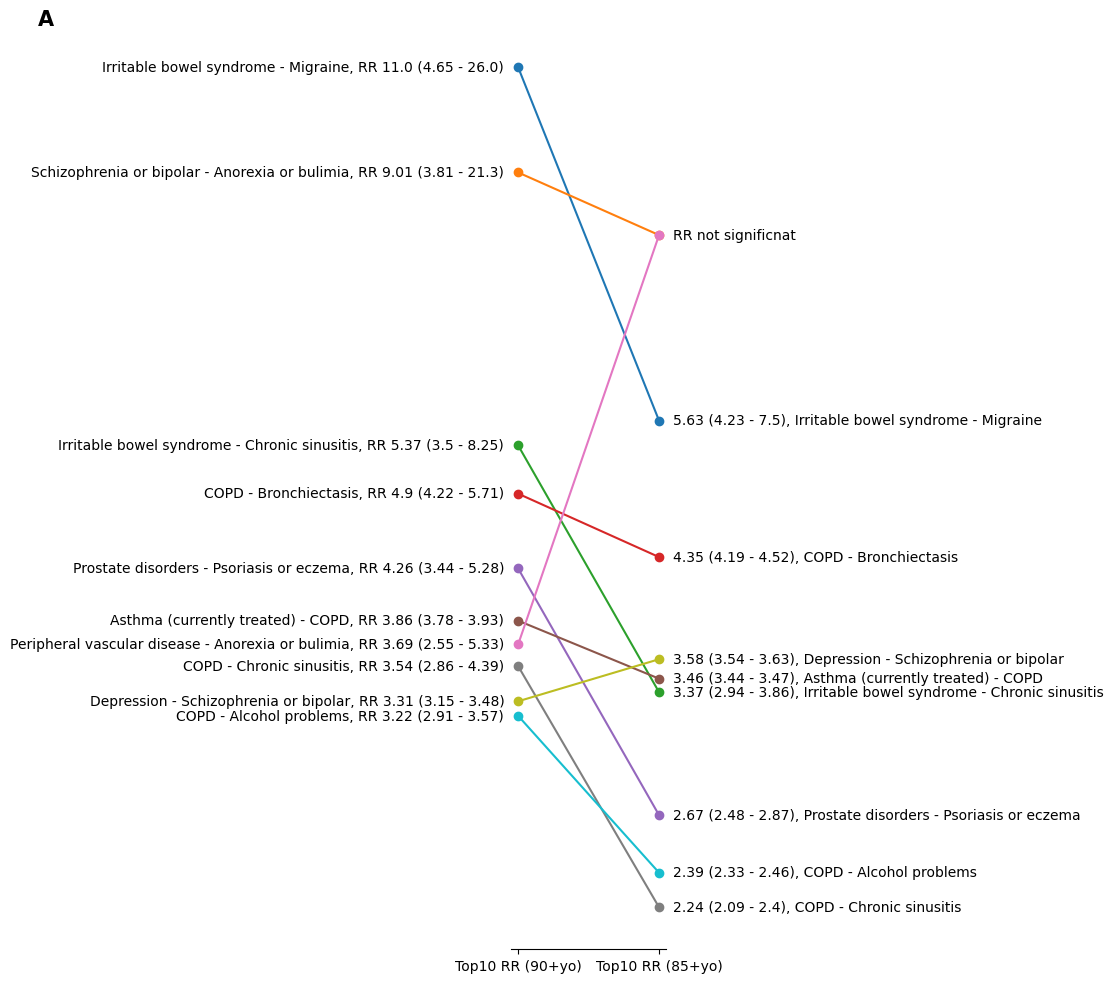

In [28]:
def plot_fig2(ax, panel):
    NS_pos = 8 if panel == "A" else 1
    y_dict = {"RR": {},#"COPD - Alcohol problems": -2,
        #              "Glaucoma - Blindness & low vision": -8,},
              "ABC": {},}#"COPD - Alcohol problems": 8,
        #              "Irritable bowel syndrome - Diverticular disease": 10,
        #              "Depression - Anxiety related disorders": 3,
        #              "Atrial fibrillation (AF) - Heart failure": -2,
        #              "Glaucoma - Blindness & low vision": -1}} if panel == "A" else {
        # "RR": {"Coronary heart disease - Dementia": 11,
        #             "Hypertension - Dementia": 3,
        #              "Treated dyspepsia - Atrial fibrillation (AF)": -2,
        #             "Chronic kidney disease - Dementia":-7,
        #             "Heart failure - Dementia": -4,},
        #       "ABC": {"Heart failure - Dementia": 6,
        #              "Chronic kidney disease - Dementia":-7}}

    if panel == "A":
        top_RRs_90s = assoc_90yo.sort_values("RR", ascending=False).iloc[:10].loc[:, ["RR", "ABC", "a_sig", "RR_f_sig_CI", "a_f_sig_CI"]]
        top_RRs_85s = dat_eld.loc[assoc_90yo.index].sort_values("RR", ascending=False).iloc[:10].loc[:, ["RR", "ABC", "fisher_sig", "RR_f_sig_CI", "a_f_sig_CI"]]
        # assocs = pd.concat([top_RRs_90s, top_RRs_85s])
        # assocs = assocs[~assocs.index.duplicated(keep='first')]
    else:
        cols = ["RR", "ABC", "a_sig", "RR_conf_down", "RR_conf_up", "a_conf_down", "a_conf_up"]
        neg_RRs = dat_eld[dat_eld["fisher_sig"].astype(bool) & (dat_eld["RR"] < 1)].sort_values("RR").loc[:, cols]
        neg_ABCs = dat_eld[dat_eld["a_sig"].astype(bool) & (dat_eld["ABC"] < 1)].sort_values("ABC").loc[:, cols]

        for res in (neg_RRs, neg_ABCs):
            res["a_f"] = res["ABC"].apply(lambda x: f"{x:.2f}")
            res["a CI (99%)"] = res["a_conf_down"].apply(lambda x: f"{x:.2f}") + " - " + res["a_conf_up"].apply(lambda x: f"{x:.2f}")
            res["a_f_sig_CI"] = res["a_f"] + " (" + res["a CI (99%)"] + ")"

            res["RR_f"] = res["RR"].apply(lambda x: f"{x:.2f}")
            res["RR CI (99%)"] = res["RR_conf_down"].apply(lambda x: f"{x:.2f}") + " - " + res["RR_conf_up"].apply(lambda x: f"{x:.2f}")
            res["RR_f_sig_CI"] = res["RR_f"] + " (" + res["RR CI (99%)"] + ")"

        assocs = pd.concat([neg_RRs, neg_ABCs])


    def beautify_index(table):
        table.index = [" - ".join([beautify_name(nam, short=True) for nam in re.findall('[^-]+', name)]) for name in list(table.index)]
        return table

    # assocs = assocs[~assocs.index.duplicated(keep='first')]
    # assocs = beautify_index(assocs) 
    top_RRs_90s = beautify_index(top_RRs_90s) 
    top_RRs_85s = beautify_index(top_RRs_85s) 

    anno_kwargs = {"va":"center", "textcoords":"offset points"}
    for i, (label, row) in enumerate(top_RRs_90s.iterrows()):
        row2 = top_RRs_85s.loc[label]
        ax.plot([0,1], [row["RR"], row2["RR"] if row2["fisher_sig"] else NS_pos], marker="o")

        ax.annotate(f'{label}, RR {row["RR_f_sig_CI"]}', (0, row["RR"]), xytext=(-10, y_dict["RR"][label] if label in y_dict["RR"] else 0), ha='right', 
                    color="black" if i < 10 or panel == "B" else "grey", **anno_kwargs)
        ax.annotate(f'{row2["RR_f_sig_CI"]}, {label}', (1, row2["RR"]), xytext=(10, y_dict["ABC"][label] if label in y_dict["ABC"] else 0), ha='left',
                    **anno_kwargs) if row2["fisher_sig"] else None
    ax.annotate("RR not significnat", (1, NS_pos), xytext=(10, 0), ha='left', **anno_kwargs)

    ax.set(yscale="log",ylim=[None,1] if panel == "B" else None);  # , ylim=1);
    ax.spines['top'].set_visible(False if panel == "A" else True)
    ax.spines['bottom'].set_visible(False if panel == "B" else True)
    ax.spines['left'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 1], ["Top10 RR (90+yo)", "Top10 RR (85+yo)"] if panel == "A" else ["Negative RR", "Negative ABC"]);
    ax.set_yticks([]);  # plt.tick_params(labelleft=False, left=False)
    ax.annotate(panel, xy=(-3.05, 1.), xycoords='axes fraction', fontweight='bold', fontsize=15)
    
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False) if panel == "B" else None  # labelleft=False, left=False)
    ax.minorticks_off();
    

# fig, axes = plt.subplots(2, 1, figsize=(2,12*2))
# for ax, panel in zip(axes, "AB"):

# plot_fig2(ax, panel)
panel="A"
sub_fig, ax = plt.subplots(figsize=(2,12))
plot_fig2(ax, panel)
sub_fig.tight_layout()
# sub_fig.savefig(f"figs/fig2{panel}.eps")
# break

# fig.tight_layout()
# fig.savefig("figs/fig2.eps")

How many pairs are marked as confident by either method?

In [24]:
f"Significant: Fisher: {dat_eld['fisher_sig'].sum():.0f} ({100*dat_eld['fisher_sig'].mean():.1f}%), ABC: {dat_eld['a_sig'].sum():.0f} ({100*dat_eld['a_sig'].mean():.1f}%)"

'Significant: Fisher: 297 (38.1%), ABC: 287 (36.8%)'

About one third of the links are not statistically significant from RR and about more than half of the links are not statistically significant from our association measure (99% confidence intervals).

Let's now look at the heatmaps.

max ABC: 2.88
max RR: 33.85


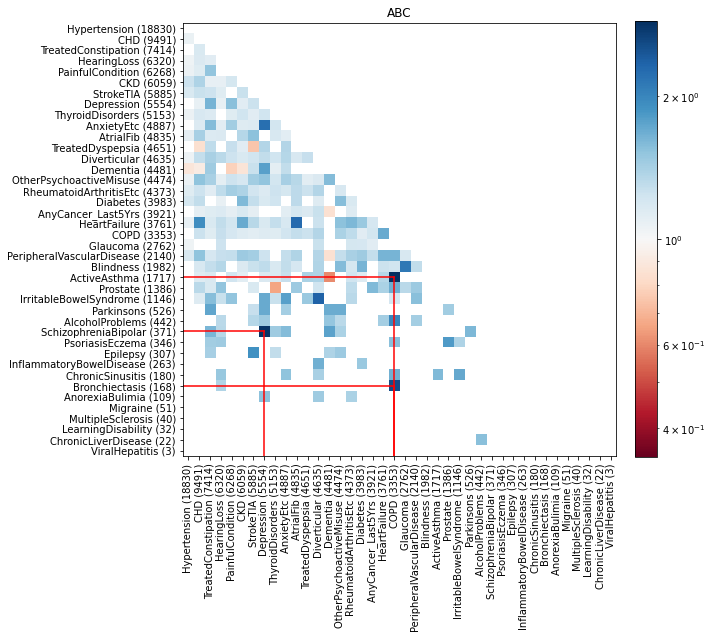

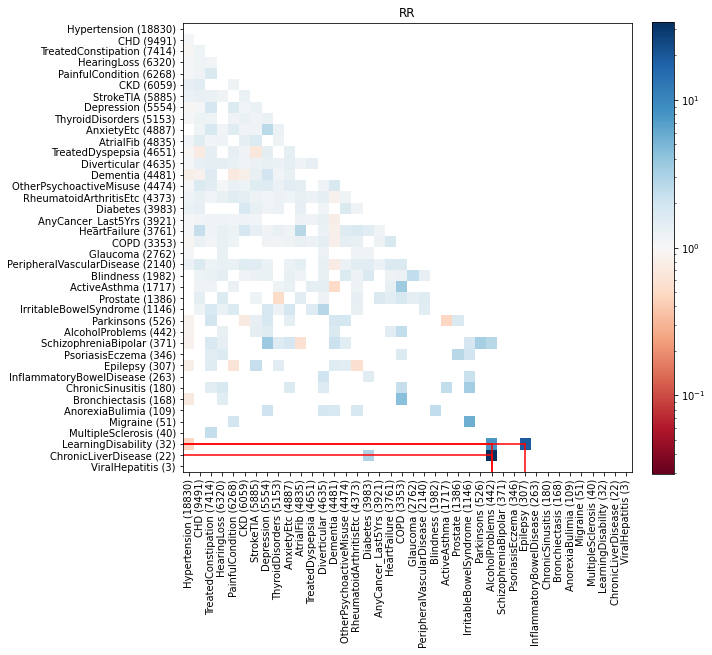

In [95]:
model.plot_heatmap("ABC")
model.plot_heatmap("RR")

The top 10 associations found by our method are

In [59]:
dat_eld[dat_eld["a_conf"].astype(bool)].sort_values("a+1(num, mode)", ascending=False).iloc[:10].loc[:, ["a_f", "a CI (99%)"]]

a_f   a CI (99%)
names                                                 
ActiveAsthma-COPD                    2.88  2.58 - 3.19
Depression-SchizophreniaBipolar      2.83  2.36 - 3.29
COPD-Bronchiectasis                  2.57  1.99 - 3.67
IrritableBowelSyndrome-Diverticular  2.34  2.10 - 2.64
AtrialFib-HeartFailure               2.27  2.12 - 2.42
Depression-AnxietyEtc                2.21  2.08 - 2.30
Glaucoma-Blindness                   2.14  1.90 - 2.41
COPD-AlcoholProblems                  2.0  1.59 - 2.51
CHD-HeartFailure                     1.93  1.83 - 2.01
StrokeTIA-Epilepsy                   1.89  1.54 - 2.32

The negative associations correspond to:

In [62]:
dat_eld[dat_eld["a_conf"].astype(bool) & (dat_eld["a+1(num, mode)"] < 1)].sort_values("a+1(num, mode)", ascending=True).loc[:, ["a_f", "a CI (99%)"]]

a_f   a CI (99%)
names                                                 
ActiveAsthma-Dementia               0.609  0.51 - 0.78
ThyroidDisorders-Prostate           0.658  0.55 - 0.80
TreatedDyspepsia-StrokeTIA          0.747  0.68 - 0.85
PainfulCondition-Dementia           0.784  0.71 - 0.86
CHD-TreatedDyspepsia                0.843  0.77 - 0.90
AnyCancer_Last5Yrs-Dementia         0.849  0.76 - 0.99
PeripheralVascularDisease-Dementia  0.852  0.71 - 0.99
CKD-Dementia                        0.875  0.80 - 0.96
Hypertension-Dementia                0.88  0.84 - 0.92
CHD-Dementia                        0.917  0.85 - 0.98

The top 10 significant associations found by relative risk correspond to

In [67]:
dat_eld[dat_eld["fisher_conf"].astype(bool)].sort_values("RR", ascending=False).iloc[:10].loc[:, ["RR_f", "RR CI (99%)", "a_f_sig"]] #  "a_conf", "a_f"]]  # .reset_index(drop=True)

RR_f    RR CI (99%) a_f_sig
names                                                               
AlcoholProblems-ChronicLiverDisease      33.8  25.42 - 45.07    1.55
Epilepsy-LearningDisability              18.6  11.12 - 31.16      NS
AlcoholProblems-LearningDisability       7.76   3.29 - 18.31      NS
IrritableBowelSyndrome-Migraine          5.63    4.23 - 7.50      NS
COPD-Bronchiectasis                      4.35    4.19 - 4.52    2.57
Depression-SchizophreniaBipolar          3.58    3.54 - 3.63    2.83
ActiveAsthma-COPD                        3.46    3.44 - 3.47    2.88
IrritableBowelSyndrome-ChronicSinusitis  3.37    2.94 - 3.86    1.72
SchizophreniaBipolar-Parkinsons          3.19    2.74 - 3.71    1.61
Diabetes-ChronicLiverDisease             2.92    2.02 - 4.22      NS

The bottom 10 significant associations found by relative risk correspond to

In [68]:
dat_eld[dat_eld["fisher_conf"].astype(bool) & (dat_eld["RR"] < 1)].sort_values("RR", ascending=True).iloc[:15].loc[:, ["RR_f", "RR CI (99%)", "a_f_sig"]]

RR_f  RR CI (99%) a_f_sig
names                                                         
Hypertension-LearningDisability     0.486  0.35 - 0.67      NS
ActiveAsthma-Parkinsons             0.486  0.39 - 0.60      NS
ActiveAsthma-Dementia                0.49  0.48 - 0.50   0.609
ThyroidDisorders-Prostate           0.517  0.50 - 0.53   0.658
RheumatoidArthritisEtc-Epilepsy     0.572  0.51 - 0.65      NS
AtrialFib-SchizophreniaBipolar      0.591  0.54 - 0.65      NS
PainfulCondition-Epilepsy           0.627  0.58 - 0.68      NS
TreatedDyspepsia-StrokeTIA          0.669  0.67 - 0.67   0.747
PainfulCondition-Dementia           0.706  0.70 - 0.71   0.784
CKD-Parkinsons                      0.723  0.69 - 0.75      NS
Hypertension-Bronchiectasis         0.728  0.70 - 0.76      NS
PeripheralVascularDisease-Dementia  0.747  0.74 - 0.76   0.852
CHD-TreatedDyspepsia                0.759  0.76 - 0.76   0.843
AnyCancer_Last5Yrs-Dementia         0.801  0.80 - 0.81   0.849
Hypertension-Dementia               0.809  0.81 - 0.81    0.88

267/780 data points
23/780 data points
30/780 data points
460/780 data points


/tmp/ipykernel_1919962/1886848901.py:48: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_1919962/1886848901.py:48: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_1919962/1886848901.py:48: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);
/tmp/ipykernel_1919962/1886848901.py:48: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=lim if xlim is None else xlim, ylim=lim if ylim is None else ylim, title=ABC_type);


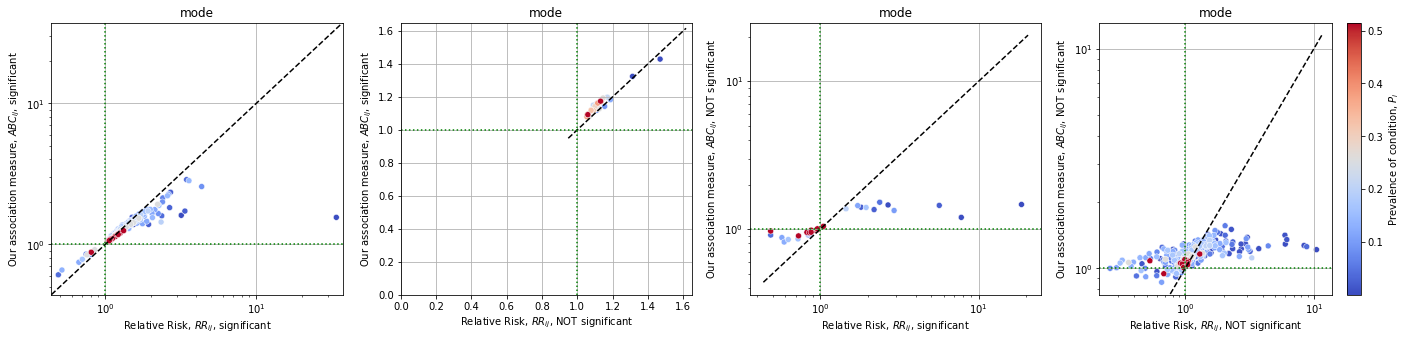

In [153]:
fig, axes = plt.subplots(1,4, figsize=(24,5)) #, sharex=True) #, sharey=True)
plot_ABC_vs_RR(axes[0], log=True)  # xlim=[0, 5.1], ylim=[0, 4])
plot_ABC_vs_RR(axes[1], RR_conf=False, log=False, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[2], a_conf=False, log=True, xlim=0, ylim=0)
plot_ABC_vs_RR(axes[3], RR_conf=False, a_conf=False, colorbar=True, log=True, xlim=0, ylim=0)

# fig, ax = plt.subplots(figsize=(7, 5))
# plot_ABC_vs_RR(ax, ABC_type="mode", colorbar=True, log=True);

## WITH sex stratification

In [ ]:
dfs, labels, fnames, L, Xs, Ps, Ms = stratify(df, "Age-Sex85")
fnames = [el for elo in fnames for el in elo]

Length of dataset: 245339


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 233817


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 259536


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 248853


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 237833


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 235294


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 113680


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 140920
Length of dataset: 11033


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


Length of dataset: 25536


/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../PCCIU/data.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.cols = {"morb": list(self.columns[11:51]) if morb_cols is None else morb_cols,


We will use a p-value of 0.01 for claiming significance and for computing confidence intervals. As the significance test, we will use [Fisher's exact test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html), as we have many pairs of conditions with very few observations.

In [ ]:
num_warmup = 500

pval = 0.01
bonferroni = False
corrected_pval = pval if not bonferroni else pval / len(triu[0])
print(f"Corrected p-value: {corrected_pval}, min # of samples for assessing: {1/corrected_pval}, required percentile: {corrected_pval * 100 / 2}")

Corrected p-value: 0.01, min # of samples for assessing: 100.0, required percentile: 0.5


In [ ]:
models = {}
RRs, RRs_conf_inf, RRs_conf_sup, RRs_significant, fishers_conf, a_num_mean, a_num_median, a_num_mode, a_num_conf_up, a_num_conf_down, a_num_signif = [np.full((L, N, N), np.NaN) for _ in range(11)]

for l in range(len(dfs)):
    print(l, end=" ")
    if l < 8:
        continue
    
    model = ABCModel(model_name="MLTC_atomic_hyp_mult", stan_api="cmdstanpy")
    model.load_fit(dfs[l], fnames[l] + model.create_file_name(num_warmup), num_warmup=num_warmup, random_seed=1)
    model.compute_RR(pval, corrected_pval)
    model.get_r_stats(pval, corrected_pval)
    
    models[l] = model
    print(model.RRs_signif[triu].sum(), model.fishers_sig[triu].sum(), model.r_sig[triu].sum())

0 1 2 3 4 5 6 7 8 Model '/disk/scratch/gromero/output/Age-Sex85-4-0_MLTC_atomic_hyp_mult_wu500' not found, fitting new model...
Max r:  54093573.11111113
Shape of co-occurrence matrix: (40, 40)
Sampling with params: {num_chains: 5, num_samples: 50, num_warmup: 500}


17:47:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

17:48:36 - cmdstanpy - INFO - CmdStan done processing.
17:48:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruc


Elapsed time: 00 hours, 01 minutes, 01 seconds.
Processing csv files: /tmp/tmpl0krzhtl/MLTC_atomic_hyp_mult62_3f3rf/MLTC_atomic_hyp_mult-20231101174735_1.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_mult62_3f3rf/MLTC_atomic_hyp_mult-20231101174735_2.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_mult62_3f3rf/MLTC_atomic_hyp_mult-20231101174735_3.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_mult62_3f3rf/MLTC_atomic_hyp_mult-20231101174735_4.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_mult62_3f3rf/MLTC_atomic_hyp_mult-20231101174735_5.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.

                       Mean      MCSE     StdDev            5%           50%  \
lp__          -4.273910e+06 

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:780: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:782: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


451 193 186
9 Model '/disk/scratch/gromero/output/Age-Sex85-4-1_MLTC_atomic_hyp_mult_wu500' not found, fitting new model...
Max r:  289799552.0
Shape of co-occurrence matrix: (40, 40)


17:49:26 - cmdstanpy - INFO - CmdStan start processing


Sampling with params: {num_chains: 5, num_samples: 50, num_warmup: 500}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

17:50:22 - cmdstanpy - INFO - CmdStan done processing.
17:50:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/models/MLTC_atomic_hyp_mult.stan', line 36, column 6 to column 53)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruc


Elapsed time: 00 hours, 00 minutes, 56 seconds.
Processing csv files: /tmp/tmpl0krzhtl/MLTC_atomic_hyp_multupvxfh93/MLTC_atomic_hyp_mult-20231101174926_1.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_multupvxfh93/MLTC_atomic_hyp_mult-20231101174926_2.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_multupvxfh93/MLTC_atomic_hyp_mult-20231101174926_3.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_multupvxfh93/MLTC_atomic_hyp_mult-20231101174926_4.csv, /tmp/tmpl0krzhtl/MLTC_atomic_hyp_multupvxfh93/MLTC_atomic_hyp_mult-20231101174926_5.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  r[37,26], P_post[5,4], P_post[7,22]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating y

/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:780: RuntimeWarning: divide by zero encountered in true_divide
  sigmas = 1 / self.X - 1 / self.M + 1 / self.P_abs[None, :] / self.P_abs[:, None] - 1 / self.M ** 2
/afs/inf.ed.ac.uk/user/g/gromero/Git/Multimorbidity-AIM-CISC/networks/reconstruction/notebooks/../../../networks/reconstruction/libs/stan_utils.py:782: RuntimeWarning: invalid value encountered in multiply
  self.RRs_conf = self.RRs * np.exp(zs[0] * sigmas), self.RRs * np.exp(zs[1] * sigmas)


488 249 236
